# Dogs vs Cats - Image classification notebook made by Øystein Knudsen
## 180236

![title](assets\dogcat.jpg)

### The notebooks structure

Given a large dataset of 25 000 photos (50/50 cats and dogs) I will
build and train a convolutional neural network to be able to classify the
new images correctly. I will be following the 8 step "Machine Learning Project Checklist" 
taken from the book "Hands on Machine Learning with Scikit Learn and TensorFlow" quite closely. 

 1. Frame the problem and look at the bigger picture.
 2. Get the data.
 3. Explore the data to gain insights.
 4. Prepeare the data to better expose the underlying data patterns to Machine Learning algorithms.
 5. Explore many different models and short-list the best ones.
 6. Fine-tune your models and combine them into a great solution.
 7. Present your solution.
 8. Launch, monitor and maintain your system. 
 

## Step 1: Framing the problem and looking at the bigger picture

### The task at hand 

The goal of this notebook is to create a model which is able to
classify an image to be either a dog or a cat.

(read more at https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)

### The tools 

In [48]:
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import keras as ks
import cv2
import random
import numpy as np
from random import shuffle #shuffling the data
from sklearn.model_selection import train_test_split
import time


#### Keras
Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research.

In my case I will be using Keras with a Tensorflow back-end. 

#### Tensorflow

Taken from tensorflow.org:

"TensorFlow™ is an open source software library for high performance numerical computation. Its flexible architecture allows easy deployment of computation across a variety of platforms (CPUs, GPUs, TPUs), and from desktops to clusters of servers to mobile and edge devices. Originally developed by researchers and engineers from the Google Brain team within Google’s AI organization, it comes with strong support for machine learning and deep learning and the flexible numerical computation core is used across many other scientific domains."


#### tqdm 
Simply just a tool for showing cool progress bars. It's nice to know the progress when working on big data sets.

#### NumPy

NumPy is the fundamental package for scientific computing with Python. It contains among other things:

- a powerful N-dimensional array object
- sophisticated (broadcasting) functions
- useful linear algebra, Fourier transform, and random number capabilities

Besides its obvious scientific uses, NumPy can also be used as an efficient multi-dimensional container of generic data. Arbitrary data-types can be defined. This allows NumPy to seamlessly and speedily integrate with a wide variety of databases.

#### Matplotlib.pyplot

pyplot is used for plotting data. e.g., create a figure, create plotting area in a figure, plot some lines in a plotting area, decorate the plot with labels, etc.

## Step 2: Getting the data

As mentioned the dataset is supplied in the Kaggle challenge. The dataset consists of 2 parts: 

Training set: 12500 pictures of dogs + 12500 pictures of cats. 
Test set: 12500 mixed pictures of dogs and cats.

The training set got the convenient naming convention of: "animal.number.jpg" For example: "cat.104.jpg" or "dog.0.jpg" which makes it an easy job to extract the label. 



    
    





#### Downloading the data from kaggle 

Using the Kaggle API I can easily download the images automatically with code. 

In [49]:
from pathlib import Path

In [50]:
#Creating the directory
NOTEBOOK_DIR = %pwd
NOTEBOOK_DIR = Path(NOTEBOOK_DIR)

DATA = NOTEBOOK_DIR/'data'
DATA.mkdir(exist_ok=True)


In [51]:
#Running the kaggle API using a subprocess
import subprocess

In [52]:
dataset_download_command = f'kaggle competitions download -c dogs-vs-cats-redux-kernels-edition -p {DATA}'

In [53]:
#subprocess.call(dataset_download_command, shell = True) #Uncomment to download data 

The data I downloaded consists of two zipped directories, the train and test data. 
In order to use this data I need to unzip it. This can be done with zipfile. 

In [54]:
import zipfile

In [58]:
#with zipfile.ZipFile(DATA/'test.zip',"r") as zip_ref: #unzipping the test data
#   zip_ref.extractall(DATA) #uncomment to unzip data 

In [57]:
# with zipfile.ZipFile(DATA/'train.zip',"r") as zip_ref: #unzipping the train data
#    zip_ref.extractall(DATA) #uncomment to unzip data

#### Loading the data 

Now that the data is successfully downloaded and extracted, it's ready to be loaded into the notebook. The first step is to get the path of all the different images in the dataset.  

In [55]:
TRAINING_DIRECTORY = 'data/train/'
TEST_DIRECTORY = 'data/test/'

In [56]:
train_images = [TRAINING_DIRECTORY+i for i in os.listdir(TRAINING_DIRECTORY)] # The full data set 
train_dogs =   [TRAINING_DIRECTORY+i for i in os.listdir(TRAINING_DIRECTORY) if 'dog' in i] # only dogs
train_cats =   [TRAINING_DIRECTORY+i for i in os.listdir(TRAINING_DIRECTORY) if 'cat' in i] # only cats
test_images =  [TEST_DIRECTORY+i for i in os.listdir(TEST_DIRECTORY)] # Test images used for final validation of the model

In [59]:
def create_data_set(number_of_images): 
    number_of_each = int(number_of_images/2)
    return train_dogs[0:number_of_each] + train_cats[0:number_of_each]

### A set of variables used for testing different parameters when fine tuneing the model

When later exploring different values and parameters used for improving the accuracy It's a convenient thing to have some variables defined in the same place. 

In [60]:
IMG_SIZE = 180
NUMBER_OF_IMAGES = 3000
BATCH_SIZE = 15
LEARNING_RATE = 0.001
EPOCHS = 5
MODEL_NAME = "Cats-vs-dogs-cnn-LR{}".format(int(time.time()))


When experimenting with different techniques for reaching my goal,

it might be useful to work with a smaller dataset than 25000 pictures. 

Creating a smaller data set to work with such that some tasks are not that time consuming.

In [61]:
train = create_data_set(NUMBER_OF_IMAGES)

## Step 3: Exploring the data to gain insights

### Looking at the data

In [62]:
#The amount of data
print ("Number of images in training data = " + str(len(train_images)))
print ("Number of images in test data = " + str(len(test_images)))
print ("Number of dogs in train data = " + str(len(train_dogs)))
print ("Number of cats in train data = " + str(len(train_cats)))

#Naming convention of the data
print ("Naming convention of dog files: " + str(train_dogs[0]))
print ("Naming convention of cat files: " + str(train_cats[0]))

#The shape of our data
example_instance = (train_images[0]) 
image = cv2.imread(example_instance)
print ("The shape of example image= " + str(image.shape))

Number of images in training data = 25000
Number of images in test data = 12500
Number of dogs in train data = 12500
Number of cats in train data = 12500
Naming convention of dog files: data/train/dog.0.jpg
Naming convention of cat files: data/train/cat.0.jpg
The shape of example image= (374, 500, 3)


### Looking at the data as pictures



In [64]:
def readRandomImage():
    randomImage = cv2.imread(train[random.randint(1,len(train))]) #reading the file as an image 
    return randomImage

In [179]:
# Taken from https://gist.github.com/soply/f3eec2e79c165e39c9d540e916142ae1

def show_images(images, cols = 1, titles = None):
   
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        
        if image.ndim == 2:
            plt.gray()
            
        plt.imshow(image)
        a.set_title(title, fontsize= 50)
        
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

In [66]:
randomImages = []
for i in range (8): 
    randomImages.append(readRandomImage())

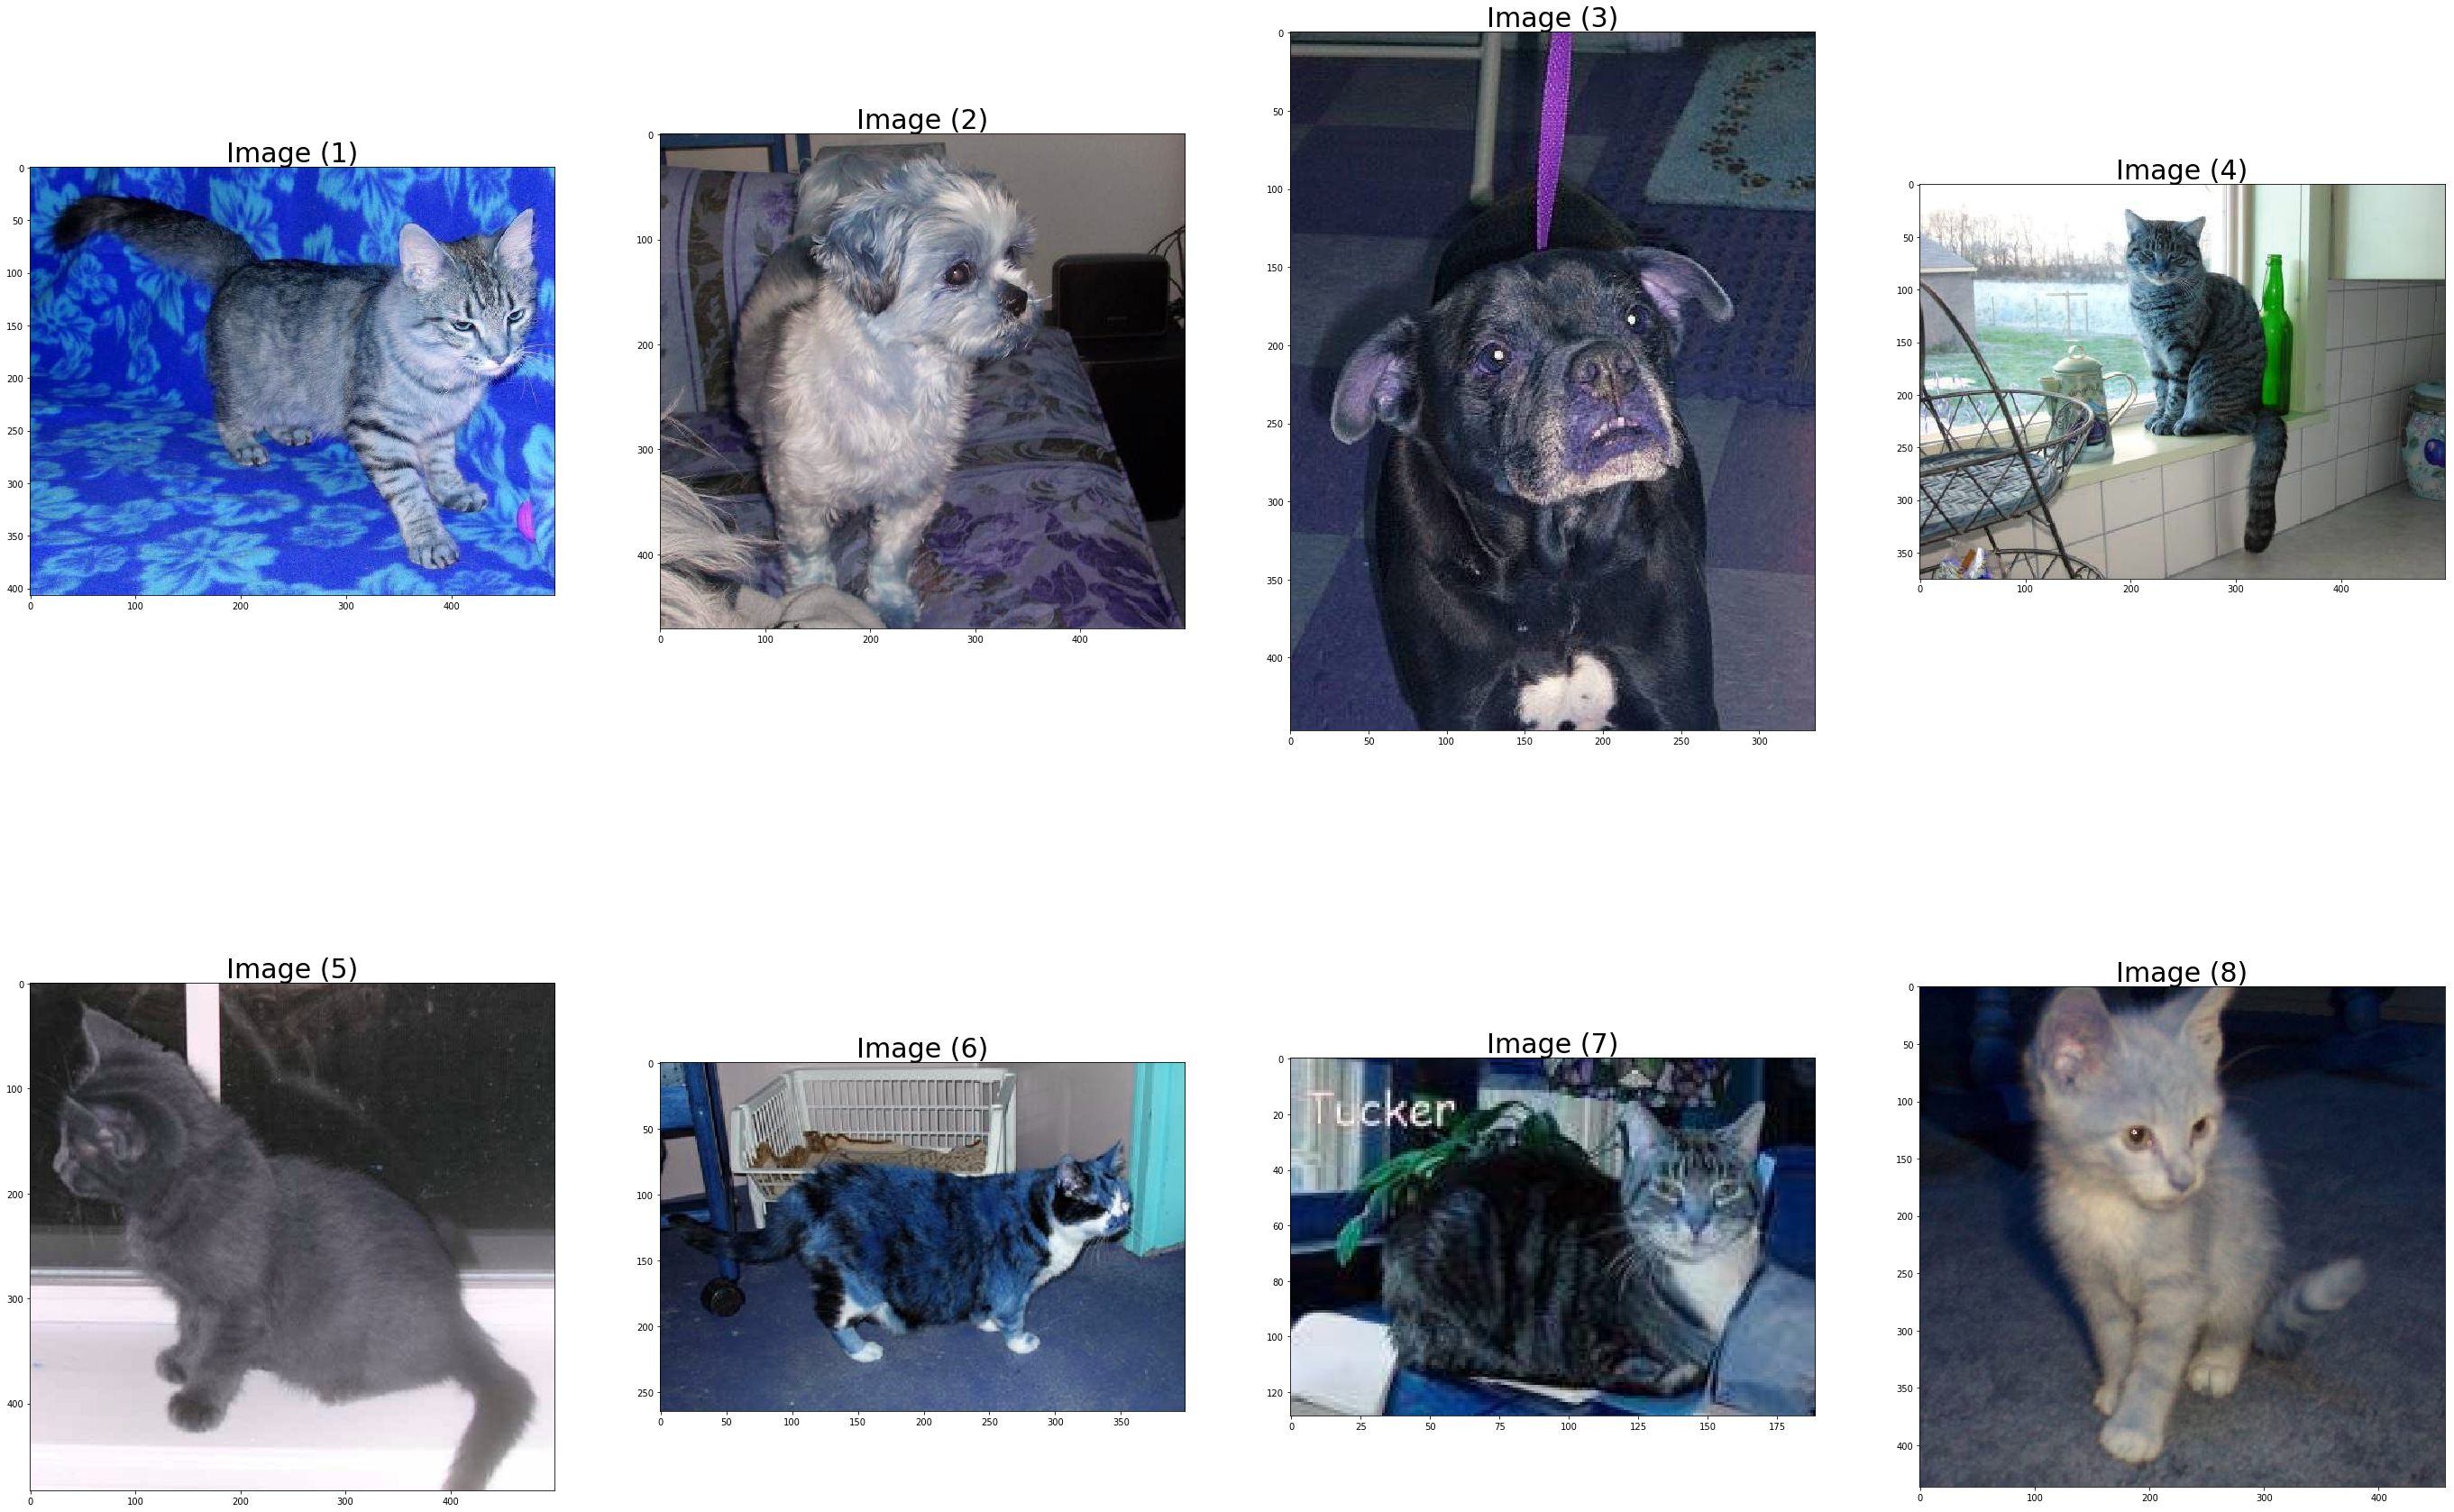

In [65]:
show_images(randomImages,2)

Looking at the random images taken from the training set, we can see that there is a variety of pictures. 
There are some close ups, some with multiple animals, some unclear and some with the owner included. However these things are all fine to feed as input to the ML-algorithm, it's the varying picture size that might be an "issue". 

## Step 4: Prepearing the data to better expose the underlying data patterns to ML-algorithms

#### Transforming the data set

Now that I have retrieved the data and looked at it, It's time to do the appropriate preperations. In order for me to feed this data into the ML-model, normalizing the data would be the best option. Meaning I will have to rezise all images into the same shape. 


Taking advantage of the naming convention we can easily extract the label from the path. Then convert it into a 
one-hot encoded value where [1,0] is a cat and [0,1] is a dog, as shown in the function below.

In [68]:
def extract_label(image):
    word_label = image.split('.')[-3] 
    final_label = word_label.split('/')[2] # Must be a better way to do this
    
    if final_label == 'cat' : return [1,0]
    
    elif final_label == 'dog' : return [0,1]

In [67]:
def one_hot_to_label(oneHot):
    if oneHot[0] == 1 : return 'cat'
    
    elif oneHot[0] == 0 : return 'dog'

The function below does several important proseccing steps to our data. 

Iterates through our training data and does the following: 
    1. extracts label. 
    2. reads the image from path into an array. 
    3. converts the image into grayscale, in order to reduce image size. 
    4. appends the image and it's label to the new training data list.
    
    Then 
     shuffles the data. 
     saves the data such that we can load it from file when tweaking the model. 

In [70]:
def create_training_data(train_data_set):
    training_data = [] 
    for img in tqdm(train_data_set): #tqdm for progress bar 
        label = extract_label(img) # extracts label from the path and returns it as one-hot array 
        img_array = cv2.imread(img, cv2.IMREAD_COLOR) # provides the img path and in which way to read the image 
        resized_img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) # Resizes the image to defined image size. 
        training_data.append([np.array(resized_img_array), np.array(label)]) #Appends the image and its label to the training data 
    shuffle(training_data) # After appending all images and labels I shuffle the data. 
    np.save('train_data.npy', training_data) # Saves the training data to disk for future use. 
    return training_data 
        

In [69]:
    def read_image(file_path):
        img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
        return cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)

In [73]:
train_data = create_training_data(train)
#train_data = np.load('train_data.npy') #USE THIS FOR LOADING THE DATA FROM FILE  

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:10<00:00, 286.27it/s]


In [72]:
def plot_image(image, onehot = None):
    if onehot.any: 
        print("This is a: " + one_hot_to_label(onehot))
    image_plot = plt.imshow(image)
    

In [71]:
def plot_image_by_index(data, index):
    instance = data[index]
    image = instance[0]
    onehot = instance[1]
    plot_image(image, onehot)

This is a: dog


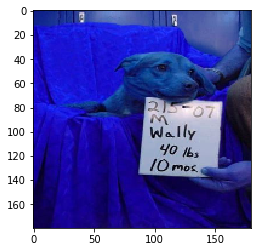

In [74]:
plot_image_by_index(train_data,2000)

#### Creating the test data 
I also need to create the test dataset which will be used to determine the models performance. 

In [75]:
def create_test_data(): 
    test_data = [] 
    for img in tqdm(test_images):
        img = cv2.imread(img, cv2.IMREAD_COLOR) 
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) #resize image such that all images are the same size. 
        test_data.append(np.array(img)) 
    
    shuffle(test_data)
    np.save('test_data.npy', test_data) #Save to disk for future use 
    return test_data
         

In [77]:
#test_data = create_test_data()
test_data = np.load('test_data.npy') #Use this for loading file from disk 

####  A peek at the transformed data 

All images are now of size 180x180

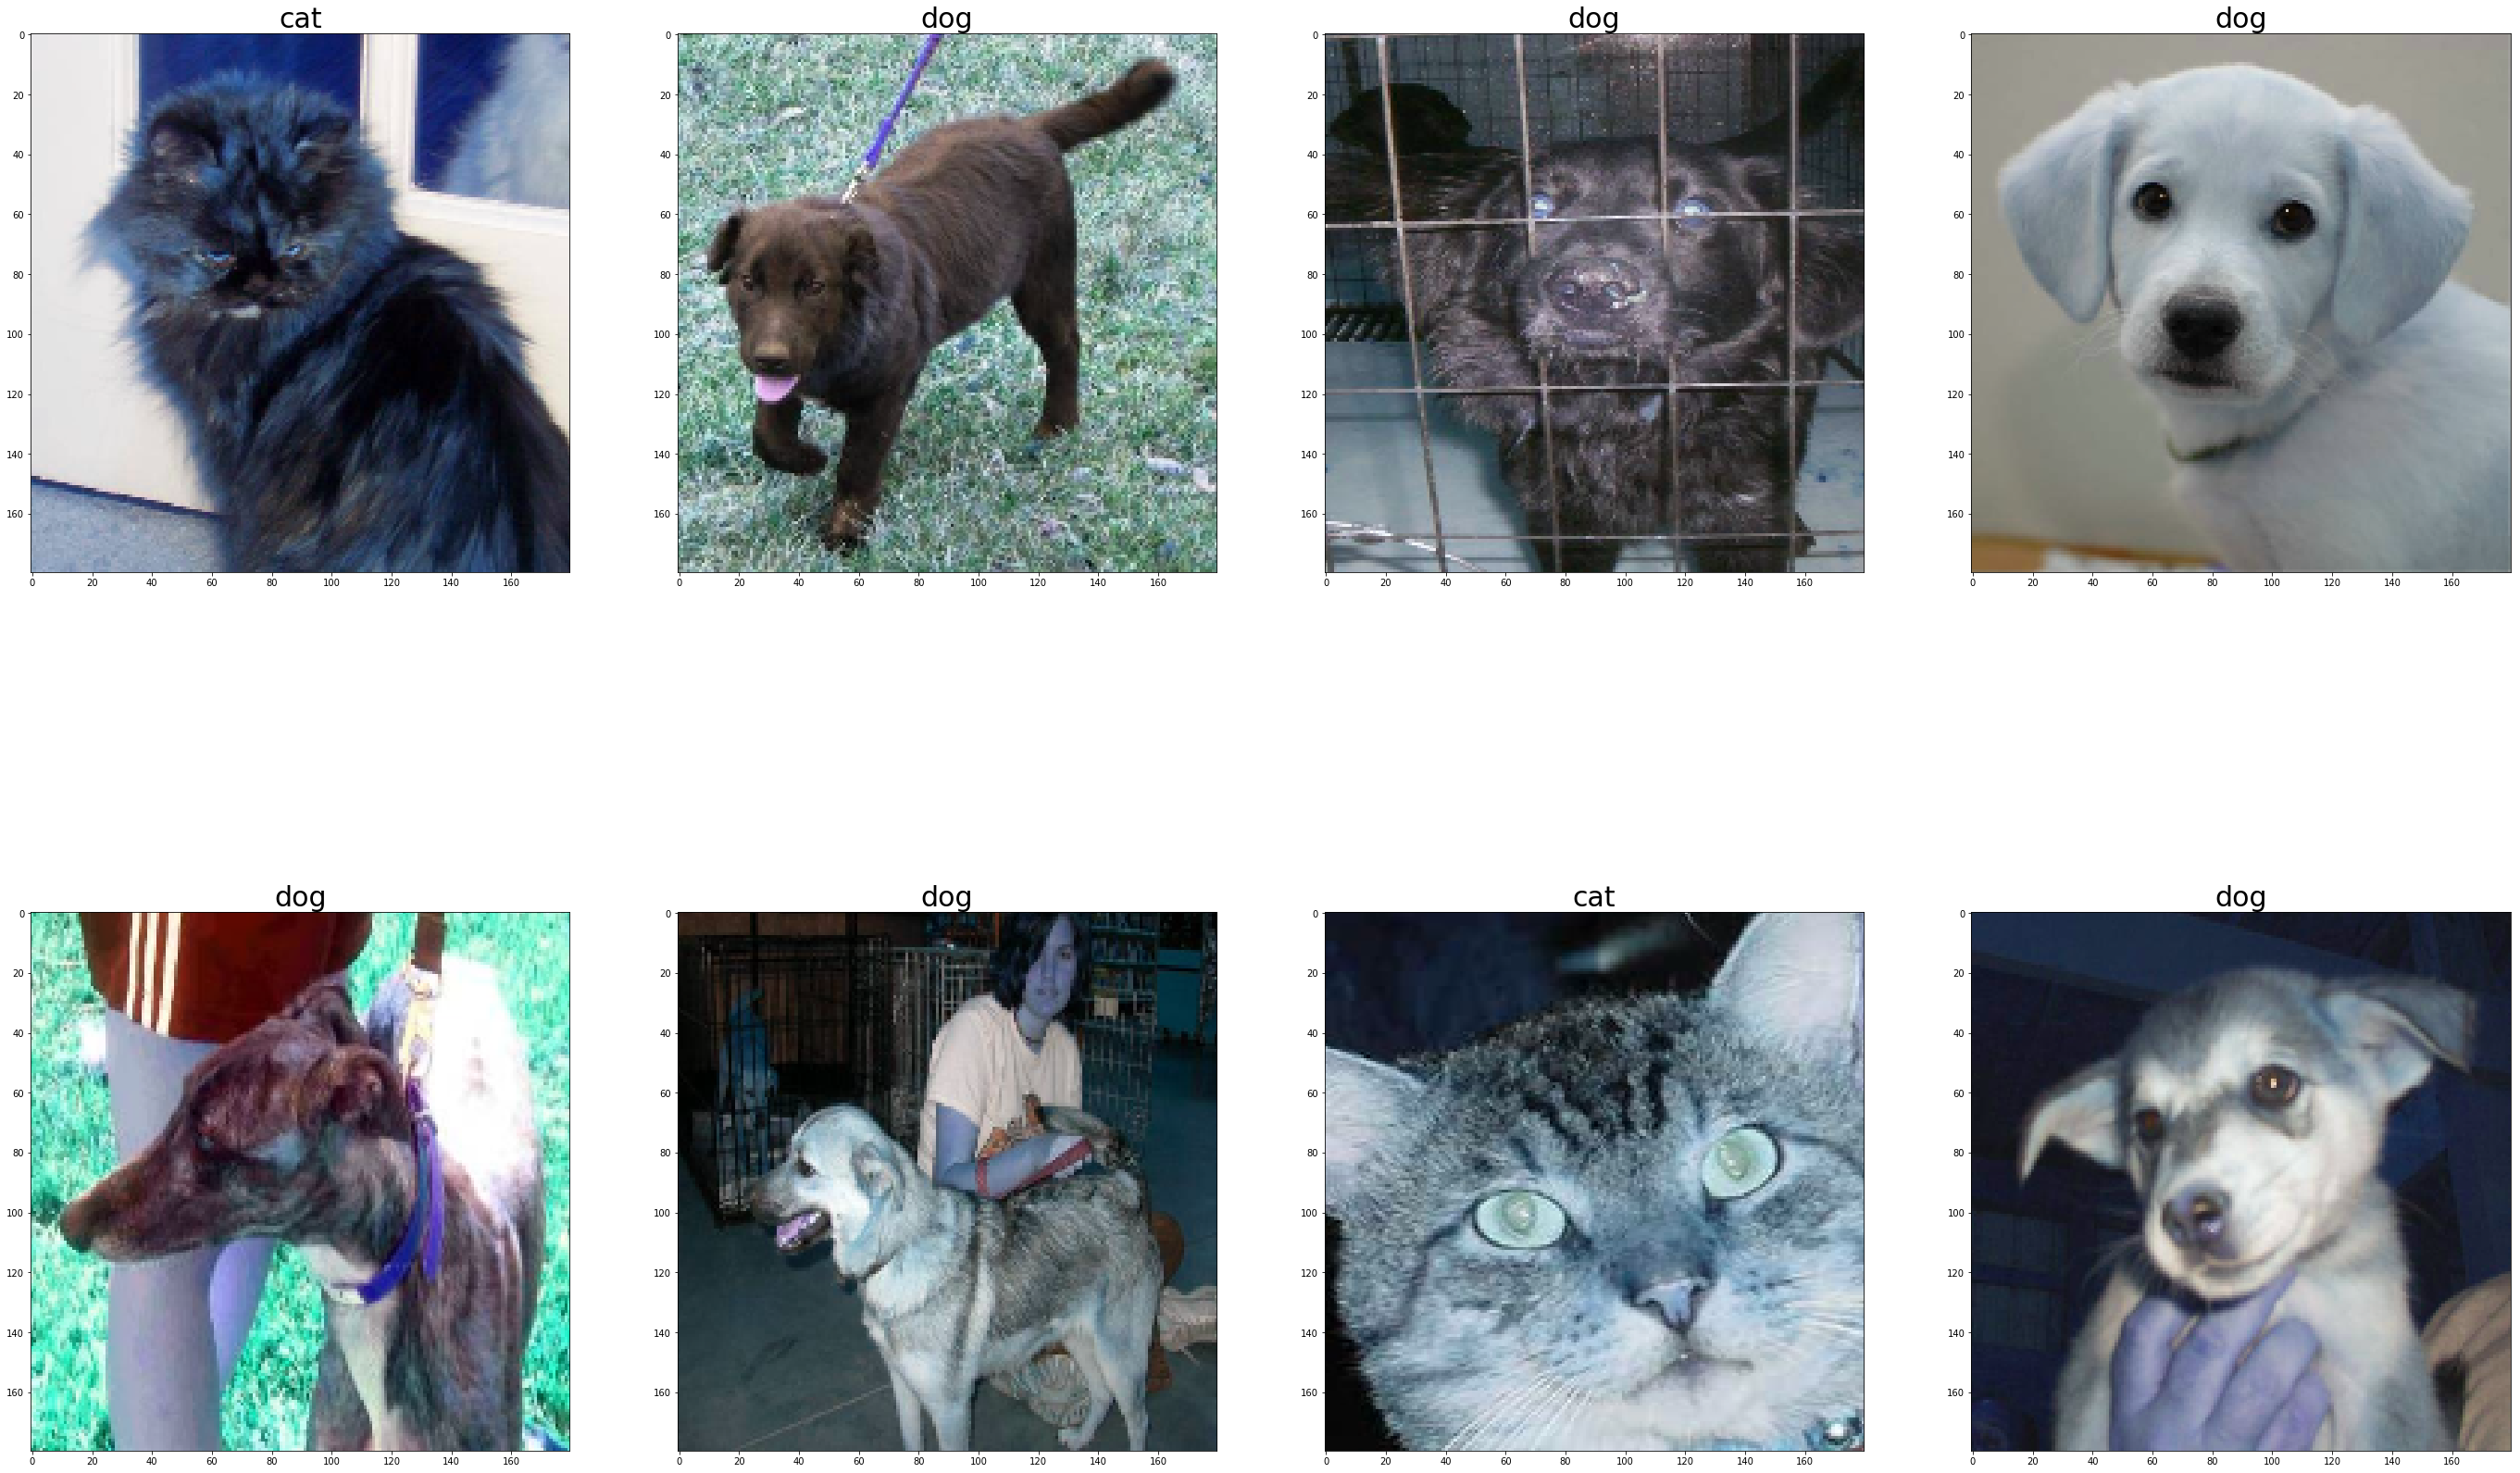

In [78]:
imagesToShow = []
titles = []
for i in range (8): 
    obj = train_data[i]
    titles.append(one_hot_to_label(obj[1]))
    img = obj[0]
    imagesToShow.append(img)
show_images(imagesToShow,2,titles)

#### seperating into features and labels 
When creating building my model I want to pass in my features as a NP-array and a label set (y). 
Therefore I need to split my current training dataset into two parts.

In [79]:
def seperate_features_and_labels(train_data):
    X = [] 
    y = []
    for features, label in train_data:
        X.append(features)
        y.append(label)

    X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3) #Keras expects a nparray of this shape.
    y = np.array(y)
    return X, y

In [80]:
X, y = seperate_features_and_labels(train_data)

#### Splitting into training and validation sets 

In [81]:
# Normalize data - max value for pixel = 255
X = X/255.0 
 

In [82]:
X_train, X_validation, y_train, y_validation = train_test_split(
   X, y, test_size=0.15, random_state=42)

#### Checking that the labels are correct

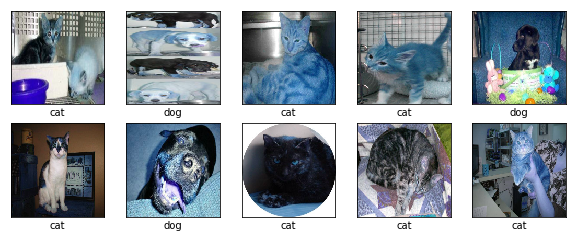

In [83]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(one_hot_to_label(y_train[i]))

## Step 5: Explore many different models and short-list the best ones. 

### The different types of models 
To solve this problem I have decided to use a Convolutional Neural Network in Keras, which is described earlier in the notebook. Keras provides two different types of models: Sequential and Functional. I will be using the Sequential model, which allows you to create models in a layered fashion. 




### Bulding the model 

#### Convolutional Neural Networks (CNN) explained briefly

##### From http://cs231n.github.io/convolutional-networks/: 

A ConvNet arranges its neurons in three dimensions (width, height, depth).
Every layer of a ConvNet transforms the 3D input volume to a 3D output volume of neuron activations.
We use three main types of layers to build ConvNet architectures: Convolutional Layer, Pooling Layer, and Fully-Connected Layer (exactly as seen in regular Neural Networks).


##### Architectures/models

There are tons of different well known architectures and pretrained models for CNN's which have been developed and optimized by data scientists. Some of these top performing models can have more than 150 layers and are very complicated. Due to lack of computing resources and the goal of learning how the model is built I've chosen to build "my own" model instead of using pretrained models. 


The Sequential model is single input and single output. 



In [84]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import RMSprop

In [85]:
def create_model(learning_rate):
    
    optimizer = RMSprop(lr=learning_rate) #
    objective = 'binary_crossentropy'
    
    model = Sequential()
    model.add(Conv2D(32, (3,3), input_shape = (IMG_SIZE, IMG_SIZE,3))) # the input layer
    model.add(Activation("relu"))   
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(32, (3,3))) 
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, (3,3))) 
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, (3,3))) 
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(64))

    model.add(Dense(2)) # Fully connected
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics = ['accuracy'])


    return model

## Step 6: Fine-tuneing the models and combining them into a great solution

#### For plotting results after training 

In [112]:
def plot_history(history_model):
    plt.plot(history_model.history['acc'])
    plt.plot(history_model.history['val_acc'])
    plt.title('Convolutional Neural Network model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()

    plt.plot(history_model.history['loss'])
    plt.plot(history_model.history['val_loss'])
    plt.title('Convolutional Neural Network model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

In [113]:
def print_results(history_model, scores):
    
    print("Results of model")
    print("--------------------------------------------------------------------------------------------------")
    print ("Number of images:" + str(NUMBER_OF_IMAGES) + " Image size:" + str(IMG_SIZE) + "x" + str(IMG_SIZE))
    print ("Batch size:" + str(BATCH_SIZE) + " Epochs:" + str(EPOCHS) + " Learning rate:" + str(LEARNING_RATE))
    print ("Training accuracy: " + str("%.2f" % (history_model.history['acc'][-1] * 100)))
    print ("Training loss: "+ str("%.2f" % (history_model.history['loss'][-1])))
    print ("Validation accuracy: " + str("%.2f" % (scores[1]*100)))
    print ("Validation loss: " + str(("%.2f" % (scores[0]))))


#### Data augmentation

When training a model over a number of epochs, one of the biggest concerns I have is overfitting. Overfitting basically means that our model doesn’t generalize well from our training data to unseen data.

One of the ways to reduce the chance of overfitting is data augmentation. Image augmentation artificially creates training images through different ways of processing or combination of multiple processing, such as random rotation, shifts, shear and flips, etc.  

Keras luckily has built-in tools for the job, as seen below.

In [114]:
from keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

### Experimental setup for fine-tuneing the model

The code underneath is setup in such a way that It's easy for me to test out different hyperparameters when tuneing the model.
The function do_cats_and_dogs runs all the nessecary steps:
1. Creating the data set 
2. Prepeares the data for input into the model.
4. Creates the model. 
5. Trains the model. 
6. Evaluates the performance of the model.  

The only think left for me to do is to draw a conclusion off of the results. 

#### Training parameters

In order for me to test out different parameters when training my model I've gathered some of the parameters in one place. 
This makes it easy to do some tweaking and rerun the training process. 

In [115]:
IMG_SIZE = 150
NUMBER_OF_IMAGES = 15000
BATCH_SIZE = 20
LEARNING_RATE = 0.001
EPOCHS = 15

In [118]:
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

def do_cats_and_dogs(loadTrain = False, loadTest = False):
    test_data = []
    train_data = []
    print("Creating data set with " + str(NUMBER_OF_IMAGES) + " images")
    train = create_data_set(NUMBER_OF_IMAGES)
    
    if loadTrain:
        print ("Loading training data")
        np.load('train_data.npy')
    else:
        print ("Creating training data")
        train_data = create_training_data(train)
        
    if loadTest:
        print ("Loading test data")
        test_data = np.load('test_data.npy')
        
    else:
        print ("Creating test data")
        test_data = create_test_data()
        
    print ("Seperating features and labels")
    X, y = seperate_features_and_labels(train_data)
    
    print ("Normalizing data")
    X = X/255.0 #normalizing data
    
    print ("Splitting into training and validation set")
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.20, random_state=1)
    
    print ("Creating and compiling model")
    model = create_model(learning_rate = LEARNING_RATE)
    
    print ("Image augmentation")
    # Image augmentation 
    train_gen = data_gen.flow(np.array(X_train), y_train, batch_size = BATCH_SIZE)
    valid_gen = data_gen.flow(np.array(X_validation), y_validation, batch_size = BATCH_SIZE)
    
    #Early stopping based on validation loss. Meaning that the training will stop if validation loss does not improve. 
    early_stopping = EarlyStopping(monitor='val_loss', min_delta = 0, patience=2, verbose=0, mode='auto') 
    
    print ("Training model")
    history_model = model.fit_generator( #Trains the model on data generated batch-by-batch
        train_gen,
        steps_per_epoch=(len(X_train)/BATCH_SIZE)*4,
        epochs = EPOCHS, 
        validation_data = valid_gen,
        validation_steps = (len(X_validation)/BATCH_SIZE)*4,
        callbacks = [early_stopping],
        verbose = 2
   )
    
    print ("Evaluating model on validation set")
    scores = model.evaluate(X_validation, y_validation)
    print_results(history_model,scores)
    return model, history_model, scores, train_data, test_data
    
    
    
    

In [117]:
model, history_model, scores, train_data, test_data = do_cats_and_dogs(loadTrain = False, loadTest = False)

Creating data set with 15000 images
Creating training data


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15000/15000 [00:51<00:00, 292.24it/s]


Creating test data


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12500/12500 [00:57<00:00, 215.71it/s]


Seperating features and labels
Normalizing data
Splitting into training and validation set
Creating and compiling model
Image augmentation
Training model
Epoch 1/15


 204/2400 [=>............................] - ETA: 6:19:48 - loss: 0.6889 - acc: 0.65 - ETA: 3:11:04 - loss: 0.7654 - acc: 0.67 - ETA: 2:08:15 - loss: 0.7374 - acc: 0.68 - ETA: 1:36:48 - loss: 0.7314 - acc: 0.65 - ETA: 1:17:55 - loss: 0.7213 - acc: 0.64 - ETA: 1:05:20 - loss: 0.7135 - acc: 0.64 - ETA: 56:20 - loss: 0.7061 - acc: 0.6429 - ETA: 49:37 - loss: 0.7144 - acc: 0.61 - ETA: 44:21 - loss: 0.7125 - acc: 0.60 - ETA: 40:10 - loss: 0.7106 - acc: 0.58 - ETA: 36:44 - loss: 0.7086 - acc: 0.58 - ETA: 33:53 - loss: 0.7078 - acc: 0.57 - ETA: 31:28 - loss: 0.7068 - acc: 0.55 - ETA: 29:24 - loss: 0.7055 - acc: 0.55 - ETA: 27:36 - loss: 0.7029 - acc: 0.56 - ETA: 26:01 - loss: 0.7242 - acc: 0.53 - ETA: 24:38 - loss: 0.7223 - acc: 0.54 - ETA: 23:24 - loss: 0.7208 - acc: 0.53 - ETA: 22:18 - loss: 0.7193 - acc: 0.53 - ETA: 21:18 - loss: 0.7180 - acc: 0.52 - ETA: 20:25 - loss: 0.7167 - acc: 0.52 - ETA: 19:44 - loss: 0.7150 - acc: 0.53 - ETA: 19:06 - loss: 0.7140 - acc: 0.53 - ETA: 18:30 - loss: 0.

 408/2400 [====>.........................] - ETA: 5:43 - loss: 0.6827 - acc: 0.573 - ETA: 5:43 - loss: 0.6823 - acc: 0.574 - ETA: 5:42 - loss: 0.6823 - acc: 0.574 - ETA: 5:41 - loss: 0.6818 - acc: 0.574 - ETA: 5:41 - loss: 0.6817 - acc: 0.575 - ETA: 5:40 - loss: 0.6814 - acc: 0.575 - ETA: 5:40 - loss: 0.6810 - acc: 0.575 - ETA: 5:39 - loss: 0.6808 - acc: 0.576 - ETA: 5:39 - loss: 0.6801 - acc: 0.576 - ETA: 5:38 - loss: 0.6804 - acc: 0.576 - ETA: 5:37 - loss: 0.6806 - acc: 0.577 - ETA: 5:37 - loss: 0.6806 - acc: 0.577 - ETA: 5:36 - loss: 0.6803 - acc: 0.577 - ETA: 5:36 - loss: 0.6804 - acc: 0.577 - ETA: 5:35 - loss: 0.6802 - acc: 0.578 - ETA: 5:35 - loss: 0.6800 - acc: 0.578 - ETA: 5:34 - loss: 0.6805 - acc: 0.577 - ETA: 5:34 - loss: 0.6799 - acc: 0.578 - ETA: 5:33 - loss: 0.6797 - acc: 0.578 - ETA: 5:32 - loss: 0.6802 - acc: 0.578 - ETA: 5:32 - loss: 0.6801 - acc: 0.578 - ETA: 5:31 - loss: 0.6795 - acc: 0.579 - ETA: 5:31 - loss: 0.6792 - acc: 0.579 - ETA: 5:30 - loss: 0.6795 - acc: 0.5

 612/2400 [======>.......................] - ETA: 4:44 - loss: 0.6622 - acc: 0.607 - ETA: 4:44 - loss: 0.6621 - acc: 0.607 - ETA: 4:44 - loss: 0.6617 - acc: 0.608 - ETA: 4:44 - loss: 0.6615 - acc: 0.608 - ETA: 4:44 - loss: 0.6615 - acc: 0.608 - ETA: 4:44 - loss: 0.6612 - acc: 0.609 - ETA: 4:44 - loss: 0.6610 - acc: 0.609 - ETA: 4:44 - loss: 0.6607 - acc: 0.609 - ETA: 4:44 - loss: 0.6614 - acc: 0.609 - ETA: 4:43 - loss: 0.6617 - acc: 0.608 - ETA: 4:43 - loss: 0.6615 - acc: 0.608 - ETA: 4:43 - loss: 0.6612 - acc: 0.609 - ETA: 4:43 - loss: 0.6606 - acc: 0.609 - ETA: 4:43 - loss: 0.6612 - acc: 0.609 - ETA: 4:42 - loss: 0.6610 - acc: 0.610 - ETA: 4:42 - loss: 0.6608 - acc: 0.610 - ETA: 4:42 - loss: 0.6609 - acc: 0.609 - ETA: 4:42 - loss: 0.6609 - acc: 0.609 - ETA: 4:42 - loss: 0.6606 - acc: 0.609 - ETA: 4:42 - loss: 0.6604 - acc: 0.609 - ETA: 4:41 - loss: 0.6603 - acc: 0.610 - ETA: 4:41 - loss: 0.6599 - acc: 0.610 - ETA: 4:41 - loss: 0.6596 - acc: 0.610 - ETA: 4:41 - loss: 0.6595 - acc: 0.6

 816/2400 [=========>....................] - ETA: 4:13 - loss: 0.6444 - acc: 0.633 - ETA: 4:13 - loss: 0.6442 - acc: 0.633 - ETA: 4:13 - loss: 0.6440 - acc: 0.633 - ETA: 4:13 - loss: 0.6438 - acc: 0.633 - ETA: 4:12 - loss: 0.6437 - acc: 0.633 - ETA: 4:12 - loss: 0.6435 - acc: 0.633 - ETA: 4:12 - loss: 0.6434 - acc: 0.634 - ETA: 4:12 - loss: 0.6434 - acc: 0.634 - ETA: 4:12 - loss: 0.6433 - acc: 0.634 - ETA: 4:12 - loss: 0.6433 - acc: 0.634 - ETA: 4:12 - loss: 0.6433 - acc: 0.634 - ETA: 4:12 - loss: 0.6431 - acc: 0.634 - ETA: 4:11 - loss: 0.6429 - acc: 0.634 - ETA: 4:11 - loss: 0.6431 - acc: 0.634 - ETA: 4:11 - loss: 0.6428 - acc: 0.634 - ETA: 4:11 - loss: 0.6426 - acc: 0.634 - ETA: 4:11 - loss: 0.6427 - acc: 0.634 - ETA: 4:11 - loss: 0.6425 - acc: 0.634 - ETA: 4:11 - loss: 0.6423 - acc: 0.634 - ETA: 4:10 - loss: 0.6424 - acc: 0.634 - ETA: 4:10 - loss: 0.6424 - acc: 0.634 - ETA: 4:10 - loss: 0.6425 - acc: 0.634 - ETA: 4:10 - loss: 0.6422 - acc: 0.635 - ETA: 4:10 - loss: 0.6422 - acc: 0.6

1020/2400 [===========>..................] - ETA: 3:47 - loss: 0.6293 - acc: 0.649 - ETA: 3:47 - loss: 0.6291 - acc: 0.649 - ETA: 3:47 - loss: 0.6290 - acc: 0.649 - ETA: 3:46 - loss: 0.6286 - acc: 0.649 - ETA: 3:46 - loss: 0.6284 - acc: 0.649 - ETA: 3:46 - loss: 0.6284 - acc: 0.649 - ETA: 3:46 - loss: 0.6287 - acc: 0.649 - ETA: 3:46 - loss: 0.6285 - acc: 0.649 - ETA: 3:46 - loss: 0.6286 - acc: 0.649 - ETA: 3:46 - loss: 0.6285 - acc: 0.649 - ETA: 3:45 - loss: 0.6284 - acc: 0.649 - ETA: 3:45 - loss: 0.6283 - acc: 0.649 - ETA: 3:45 - loss: 0.6284 - acc: 0.649 - ETA: 3:45 - loss: 0.6283 - acc: 0.650 - ETA: 3:45 - loss: 0.6281 - acc: 0.650 - ETA: 3:45 - loss: 0.6279 - acc: 0.650 - ETA: 3:45 - loss: 0.6278 - acc: 0.650 - ETA: 3:44 - loss: 0.6279 - acc: 0.650 - ETA: 3:44 - loss: 0.6278 - acc: 0.650 - ETA: 3:44 - loss: 0.6275 - acc: 0.650 - ETA: 3:44 - loss: 0.6274 - acc: 0.650 - ETA: 3:44 - loss: 0.6273 - acc: 0.650 - ETA: 3:44 - loss: 0.6274 - acc: 0.650 - ETA: 3:43 - loss: 0.6276 - acc: 0.6

1224/2400 [==============>...............] - ETA: 3:19 - loss: 0.6152 - acc: 0.661 - ETA: 3:19 - loss: 0.6151 - acc: 0.661 - ETA: 3:19 - loss: 0.6149 - acc: 0.661 - ETA: 3:19 - loss: 0.6146 - acc: 0.662 - ETA: 3:19 - loss: 0.6144 - acc: 0.662 - ETA: 3:18 - loss: 0.6144 - acc: 0.662 - ETA: 3:18 - loss: 0.6145 - acc: 0.662 - ETA: 3:18 - loss: 0.6143 - acc: 0.662 - ETA: 3:18 - loss: 0.6141 - acc: 0.662 - ETA: 3:18 - loss: 0.6139 - acc: 0.662 - ETA: 3:18 - loss: 0.6137 - acc: 0.662 - ETA: 3:17 - loss: 0.6137 - acc: 0.662 - ETA: 3:17 - loss: 0.6137 - acc: 0.662 - ETA: 3:17 - loss: 0.6136 - acc: 0.662 - ETA: 3:17 - loss: 0.6136 - acc: 0.662 - ETA: 3:17 - loss: 0.6134 - acc: 0.662 - ETA: 3:17 - loss: 0.6134 - acc: 0.662 - ETA: 3:17 - loss: 0.6134 - acc: 0.662 - ETA: 3:16 - loss: 0.6132 - acc: 0.663 - ETA: 3:16 - loss: 0.6132 - acc: 0.663 - ETA: 3:16 - loss: 0.6132 - acc: 0.662 - ETA: 3:16 - loss: 0.6130 - acc: 0.663 - ETA: 3:16 - loss: 0.6129 - acc: 0.663 - ETA: 3:16 - loss: 0.6128 - acc: 0.6

1428/2400 [================>.............] - ETA: 2:50 - loss: 0.5998 - acc: 0.674 - ETA: 2:49 - loss: 0.5998 - acc: 0.674 - ETA: 2:49 - loss: 0.5997 - acc: 0.674 - ETA: 2:49 - loss: 0.5998 - acc: 0.674 - ETA: 2:49 - loss: 0.5996 - acc: 0.674 - ETA: 2:49 - loss: 0.5995 - acc: 0.674 - ETA: 2:49 - loss: 0.5995 - acc: 0.674 - ETA: 2:49 - loss: 0.5993 - acc: 0.674 - ETA: 2:48 - loss: 0.5995 - acc: 0.674 - ETA: 2:48 - loss: 0.5993 - acc: 0.674 - ETA: 2:48 - loss: 0.5992 - acc: 0.674 - ETA: 2:48 - loss: 0.5991 - acc: 0.674 - ETA: 2:48 - loss: 0.5990 - acc: 0.674 - ETA: 2:48 - loss: 0.5988 - acc: 0.674 - ETA: 2:48 - loss: 0.5986 - acc: 0.675 - ETA: 2:47 - loss: 0.5984 - acc: 0.675 - ETA: 2:47 - loss: 0.5985 - acc: 0.675 - ETA: 2:47 - loss: 0.5988 - acc: 0.675 - ETA: 2:47 - loss: 0.5987 - acc: 0.675 - ETA: 2:47 - loss: 0.5985 - acc: 0.675 - ETA: 2:47 - loss: 0.5984 - acc: 0.675 - ETA: 2:46 - loss: 0.5982 - acc: 0.675 - ETA: 2:46 - loss: 0.5983 - acc: 0.675 - ETA: 2:46 - loss: 0.5982 - acc: 0.6

1632/2400 [===================>..........] - ETA: 2:20 - loss: 0.5878 - acc: 0.684 - ETA: 2:20 - loss: 0.5877 - acc: 0.684 - ETA: 2:20 - loss: 0.5877 - acc: 0.684 - ETA: 2:20 - loss: 0.5877 - acc: 0.684 - ETA: 2:19 - loss: 0.5876 - acc: 0.684 - ETA: 2:19 - loss: 0.5876 - acc: 0.684 - ETA: 2:19 - loss: 0.5874 - acc: 0.684 - ETA: 2:19 - loss: 0.5873 - acc: 0.684 - ETA: 2:19 - loss: 0.5870 - acc: 0.684 - ETA: 2:19 - loss: 0.5869 - acc: 0.684 - ETA: 2:19 - loss: 0.5871 - acc: 0.684 - ETA: 2:18 - loss: 0.5870 - acc: 0.684 - ETA: 2:18 - loss: 0.5869 - acc: 0.685 - ETA: 2:18 - loss: 0.5869 - acc: 0.685 - ETA: 2:18 - loss: 0.5868 - acc: 0.685 - ETA: 2:18 - loss: 0.5868 - acc: 0.685 - ETA: 2:18 - loss: 0.5867 - acc: 0.685 - ETA: 2:18 - loss: 0.5866 - acc: 0.685 - ETA: 2:17 - loss: 0.5864 - acc: 0.685 - ETA: 2:17 - loss: 0.5863 - acc: 0.685 - ETA: 2:17 - loss: 0.5862 - acc: 0.685 - ETA: 2:17 - loss: 0.5861 - acc: 0.685 - ETA: 2:17 - loss: 0.5860 - acc: 0.685 - ETA: 2:17 - loss: 0.5860 - acc: 0.6

1836/2400 [=====================>........] - ETA: 1:51 - loss: 0.5743 - acc: 0.695 - ETA: 1:50 - loss: 0.5743 - acc: 0.695 - ETA: 1:50 - loss: 0.5742 - acc: 0.695 - ETA: 1:50 - loss: 0.5742 - acc: 0.695 - ETA: 1:50 - loss: 0.5742 - acc: 0.695 - ETA: 1:50 - loss: 0.5741 - acc: 0.695 - ETA: 1:50 - loss: 0.5742 - acc: 0.695 - ETA: 1:50 - loss: 0.5741 - acc: 0.695 - ETA: 1:49 - loss: 0.5740 - acc: 0.695 - ETA: 1:49 - loss: 0.5740 - acc: 0.695 - ETA: 1:49 - loss: 0.5739 - acc: 0.695 - ETA: 1:49 - loss: 0.5739 - acc: 0.695 - ETA: 1:49 - loss: 0.5739 - acc: 0.696 - ETA: 1:49 - loss: 0.5739 - acc: 0.696 - ETA: 1:49 - loss: 0.5738 - acc: 0.696 - ETA: 1:48 - loss: 0.5737 - acc: 0.696 - ETA: 1:48 - loss: 0.5735 - acc: 0.696 - ETA: 1:48 - loss: 0.5735 - acc: 0.696 - ETA: 1:48 - loss: 0.5734 - acc: 0.696 - ETA: 1:48 - loss: 0.5734 - acc: 0.696 - ETA: 1:48 - loss: 0.5734 - acc: 0.696 - ETA: 1:48 - loss: 0.5732 - acc: 0.696 - ETA: 1:47 - loss: 0.5732 - acc: 0.696 - ETA: 1:47 - loss: 0.5732 - acc: 0.6

2043/2400 [========================>.....] - ETA: 1:21 - loss: 0.5625 - acc: 0.704 - ETA: 1:21 - loss: 0.5625 - acc: 0.704 - ETA: 1:21 - loss: 0.5628 - acc: 0.704 - ETA: 1:21 - loss: 0.5626 - acc: 0.705 - ETA: 1:21 - loss: 0.5627 - acc: 0.705 - ETA: 1:21 - loss: 0.5626 - acc: 0.705 - ETA: 1:20 - loss: 0.5626 - acc: 0.705 - ETA: 1:20 - loss: 0.5626 - acc: 0.705 - ETA: 1:20 - loss: 0.5625 - acc: 0.705 - ETA: 1:20 - loss: 0.5625 - acc: 0.705 - ETA: 1:20 - loss: 0.5624 - acc: 0.705 - ETA: 1:20 - loss: 0.5625 - acc: 0.705 - ETA: 1:20 - loss: 0.5624 - acc: 0.705 - ETA: 1:19 - loss: 0.5623 - acc: 0.705 - ETA: 1:19 - loss: 0.5623 - acc: 0.705 - ETA: 1:19 - loss: 0.5623 - acc: 0.705 - ETA: 1:19 - loss: 0.5622 - acc: 0.705 - ETA: 1:19 - loss: 0.5620 - acc: 0.705 - ETA: 1:19 - loss: 0.5620 - acc: 0.705 - ETA: 1:19 - loss: 0.5619 - acc: 0.705 - ETA: 1:19 - loss: 0.5618 - acc: 0.705 - ETA: 1:18 - loss: 0.5618 - acc: 0.705 - ETA: 1:18 - loss: 0.5616 - acc: 0.705 - ETA: 1:18 - loss: 0.5615 - acc: 0.7

2258/2400 [===========================>..] - ETA: 51s - loss: 0.5525 - acc: 0.71 - ETA: 51s - loss: 0.5524 - acc: 0.71 - ETA: 51s - loss: 0.5524 - acc: 0.71 - ETA: 51s - loss: 0.5524 - acc: 0.71 - ETA: 51s - loss: 0.5524 - acc: 0.71 - ETA: 51s - loss: 0.5524 - acc: 0.71 - ETA: 51s - loss: 0.5523 - acc: 0.71 - ETA: 50s - loss: 0.5523 - acc: 0.71 - ETA: 50s - loss: 0.5523 - acc: 0.71 - ETA: 50s - loss: 0.5522 - acc: 0.71 - ETA: 50s - loss: 0.5521 - acc: 0.71 - ETA: 50s - loss: 0.5520 - acc: 0.71 - ETA: 50s - loss: 0.5519 - acc: 0.71 - ETA: 50s - loss: 0.5519 - acc: 0.71 - ETA: 49s - loss: 0.5518 - acc: 0.71 - ETA: 49s - loss: 0.5519 - acc: 0.71 - ETA: 49s - loss: 0.5518 - acc: 0.71 - ETA: 49s - loss: 0.5518 - acc: 0.71 - ETA: 49s - loss: 0.5519 - acc: 0.71 - ETA: 49s - loss: 0.5518 - acc: 0.71 - ETA: 49s - loss: 0.5517 - acc: 0.71 - ETA: 48s - loss: 0.5516 - acc: 0.71 - ETA: 48s - loss: 0.5516 - acc: 0.71 - ETA: 48s - loss: 0.5516 - acc: 0.71 - ETA: 48s - loss: 0.5516 - acc: 0.71 - ETA: 

2400/2400 [==============================] - ETA: 20s - loss: 0.5433 - acc: 0.71 - ETA: 20s - loss: 0.5433 - acc: 0.71 - ETA: 20s - loss: 0.5433 - acc: 0.71 - ETA: 20s - loss: 0.5433 - acc: 0.71 - ETA: 20s - loss: 0.5432 - acc: 0.71 - ETA: 19s - loss: 0.5431 - acc: 0.71 - ETA: 19s - loss: 0.5430 - acc: 0.71 - ETA: 19s - loss: 0.5432 - acc: 0.71 - ETA: 19s - loss: 0.5431 - acc: 0.71 - ETA: 19s - loss: 0.5431 - acc: 0.71 - ETA: 19s - loss: 0.5430 - acc: 0.71 - ETA: 19s - loss: 0.5429 - acc: 0.71 - ETA: 18s - loss: 0.5429 - acc: 0.71 - ETA: 18s - loss: 0.5428 - acc: 0.71 - ETA: 18s - loss: 0.5428 - acc: 0.71 - ETA: 18s - loss: 0.5427 - acc: 0.71 - ETA: 18s - loss: 0.5426 - acc: 0.71 - ETA: 18s - loss: 0.5427 - acc: 0.71 - ETA: 18s - loss: 0.5426 - acc: 0.72 - ETA: 17s - loss: 0.5426 - acc: 0.72 - ETA: 17s - loss: 0.5425 - acc: 0.72 - ETA: 17s - loss: 0.5424 - acc: 0.72 - ETA: 17s - loss: 0.5424 - acc: 0.72 - ETA: 17s - loss: 0.5424 - acc: 0.72 - ETA: 17s - loss: 0.5424 - acc: 0.72 - ETA: 

 204/2400 [=>............................] - ETA: 2:33 - loss: 0.2639 - acc: 0.950 - ETA: 2:39 - loss: 0.3502 - acc: 0.875 - ETA: 2:41 - loss: 0.3915 - acc: 0.850 - ETA: 2:42 - loss: 0.3902 - acc: 0.837 - ETA: 2:45 - loss: 0.3716 - acc: 0.855 - ETA: 2:45 - loss: 0.3466 - acc: 0.866 - ETA: 2:45 - loss: 0.3496 - acc: 0.857 - ETA: 2:45 - loss: 0.3394 - acc: 0.865 - ETA: 3:12 - loss: 0.3621 - acc: 0.858 - ETA: 3:30 - loss: 0.3508 - acc: 0.865 - ETA: 3:34 - loss: 0.3414 - acc: 0.870 - ETA: 3:30 - loss: 0.3527 - acc: 0.862 - ETA: 3:28 - loss: 0.3499 - acc: 0.863 - ETA: 3:26 - loss: 0.3705 - acc: 0.851 - ETA: 3:25 - loss: 0.3852 - acc: 0.841 - ETA: 3:23 - loss: 0.3747 - acc: 0.845 - ETA: 3:22 - loss: 0.3779 - acc: 0.839 - ETA: 3:31 - loss: 0.3789 - acc: 0.837 - ETA: 3:45 - loss: 0.3760 - acc: 0.838 - ETA: 3:57 - loss: 0.3678 - acc: 0.841 - ETA: 4:08 - loss: 0.3700 - acc: 0.839 - ETA: 4:24 - loss: 0.3799 - acc: 0.834 - ETA: 4:34 - loss: 0.3858 - acc: 0.837 - ETA: 4:40 - loss: 0.3920 - acc: 0.8

 408/2400 [====>.........................] - ETA: 5:13 - loss: 0.4126 - acc: 0.813 - ETA: 5:13 - loss: 0.4135 - acc: 0.812 - ETA: 5:13 - loss: 0.4131 - acc: 0.812 - ETA: 5:13 - loss: 0.4140 - acc: 0.812 - ETA: 5:13 - loss: 0.4146 - acc: 0.811 - ETA: 5:12 - loss: 0.4142 - acc: 0.811 - ETA: 5:12 - loss: 0.4135 - acc: 0.811 - ETA: 5:12 - loss: 0.4135 - acc: 0.811 - ETA: 5:12 - loss: 0.4139 - acc: 0.811 - ETA: 5:12 - loss: 0.4143 - acc: 0.811 - ETA: 5:12 - loss: 0.4138 - acc: 0.811 - ETA: 5:12 - loss: 0.4135 - acc: 0.811 - ETA: 5:11 - loss: 0.4134 - acc: 0.811 - ETA: 5:11 - loss: 0.4123 - acc: 0.811 - ETA: 5:11 - loss: 0.4119 - acc: 0.812 - ETA: 5:11 - loss: 0.4122 - acc: 0.811 - ETA: 5:11 - loss: 0.4125 - acc: 0.811 - ETA: 5:11 - loss: 0.4116 - acc: 0.812 - ETA: 5:10 - loss: 0.4116 - acc: 0.811 - ETA: 5:10 - loss: 0.4112 - acc: 0.812 - ETA: 5:10 - loss: 0.4106 - acc: 0.812 - ETA: 5:11 - loss: 0.4098 - acc: 0.812 - ETA: 5:11 - loss: 0.4104 - acc: 0.812 - ETA: 5:12 - loss: 0.4124 - acc: 0.8

 612/2400 [======>.......................] - ETA: 4:54 - loss: 0.4071 - acc: 0.816 - ETA: 4:54 - loss: 0.4076 - acc: 0.816 - ETA: 4:54 - loss: 0.4082 - acc: 0.815 - ETA: 4:53 - loss: 0.4083 - acc: 0.816 - ETA: 4:53 - loss: 0.4085 - acc: 0.816 - ETA: 4:52 - loss: 0.4087 - acc: 0.815 - ETA: 4:52 - loss: 0.4086 - acc: 0.815 - ETA: 4:52 - loss: 0.4086 - acc: 0.816 - ETA: 4:52 - loss: 0.4087 - acc: 0.815 - ETA: 4:52 - loss: 0.4085 - acc: 0.816 - ETA: 4:52 - loss: 0.4082 - acc: 0.816 - ETA: 4:52 - loss: 0.4079 - acc: 0.816 - ETA: 4:52 - loss: 0.4076 - acc: 0.816 - ETA: 4:51 - loss: 0.4078 - acc: 0.816 - ETA: 4:51 - loss: 0.4078 - acc: 0.816 - ETA: 4:51 - loss: 0.4084 - acc: 0.816 - ETA: 4:51 - loss: 0.4082 - acc: 0.816 - ETA: 4:51 - loss: 0.4080 - acc: 0.816 - ETA: 4:51 - loss: 0.4078 - acc: 0.816 - ETA: 4:50 - loss: 0.4079 - acc: 0.816 - ETA: 4:50 - loss: 0.4077 - acc: 0.816 - ETA: 4:50 - loss: 0.4076 - acc: 0.816 - ETA: 4:50 - loss: 0.4077 - acc: 0.816 - ETA: 4:50 - loss: 0.4076 - acc: 0.8

 816/2400 [=========>....................] - ETA: 4:22 - loss: 0.4117 - acc: 0.814 - ETA: 4:22 - loss: 0.4115 - acc: 0.814 - ETA: 4:22 - loss: 0.4113 - acc: 0.814 - ETA: 4:22 - loss: 0.4115 - acc: 0.814 - ETA: 4:22 - loss: 0.4116 - acc: 0.814 - ETA: 4:22 - loss: 0.4112 - acc: 0.814 - ETA: 4:21 - loss: 0.4114 - acc: 0.814 - ETA: 4:21 - loss: 0.4113 - acc: 0.814 - ETA: 4:21 - loss: 0.4112 - acc: 0.814 - ETA: 4:21 - loss: 0.4115 - acc: 0.814 - ETA: 4:21 - loss: 0.4111 - acc: 0.814 - ETA: 4:21 - loss: 0.4109 - acc: 0.814 - ETA: 4:20 - loss: 0.4109 - acc: 0.814 - ETA: 4:20 - loss: 0.4109 - acc: 0.814 - ETA: 4:20 - loss: 0.4107 - acc: 0.814 - ETA: 4:20 - loss: 0.4104 - acc: 0.815 - ETA: 4:20 - loss: 0.4102 - acc: 0.815 - ETA: 4:20 - loss: 0.4102 - acc: 0.815 - ETA: 4:20 - loss: 0.4100 - acc: 0.815 - ETA: 4:19 - loss: 0.4100 - acc: 0.815 - ETA: 4:19 - loss: 0.4099 - acc: 0.815 - ETA: 4:19 - loss: 0.4100 - acc: 0.815 - ETA: 4:19 - loss: 0.4096 - acc: 0.815 - ETA: 4:19 - loss: 0.4093 - acc: 0.8

1020/2400 [===========>..................] - ETA: 3:53 - loss: 0.4066 - acc: 0.817 - ETA: 3:53 - loss: 0.4064 - acc: 0.818 - ETA: 3:53 - loss: 0.4066 - acc: 0.817 - ETA: 3:53 - loss: 0.4067 - acc: 0.817 - ETA: 3:52 - loss: 0.4065 - acc: 0.818 - ETA: 3:52 - loss: 0.4064 - acc: 0.818 - ETA: 3:52 - loss: 0.4069 - acc: 0.818 - ETA: 3:52 - loss: 0.4070 - acc: 0.818 - ETA: 3:52 - loss: 0.4068 - acc: 0.818 - ETA: 3:52 - loss: 0.4066 - acc: 0.818 - ETA: 3:52 - loss: 0.4066 - acc: 0.818 - ETA: 3:51 - loss: 0.4065 - acc: 0.818 - ETA: 3:51 - loss: 0.4063 - acc: 0.818 - ETA: 3:51 - loss: 0.4062 - acc: 0.818 - ETA: 3:51 - loss: 0.4059 - acc: 0.818 - ETA: 3:51 - loss: 0.4062 - acc: 0.818 - ETA: 3:51 - loss: 0.4060 - acc: 0.818 - ETA: 3:50 - loss: 0.4059 - acc: 0.818 - ETA: 3:50 - loss: 0.4059 - acc: 0.818 - ETA: 3:50 - loss: 0.4059 - acc: 0.818 - ETA: 3:50 - loss: 0.4056 - acc: 0.818 - ETA: 3:50 - loss: 0.4053 - acc: 0.818 - ETA: 3:50 - loss: 0.4053 - acc: 0.818 - ETA: 3:50 - loss: 0.4053 - acc: 0.8

1224/2400 [==============>...............] - ETA: 3:23 - loss: 0.4023 - acc: 0.819 - ETA: 3:23 - loss: 0.4025 - acc: 0.819 - ETA: 3:23 - loss: 0.4024 - acc: 0.819 - ETA: 3:23 - loss: 0.4024 - acc: 0.819 - ETA: 3:22 - loss: 0.4022 - acc: 0.819 - ETA: 3:22 - loss: 0.4022 - acc: 0.819 - ETA: 3:22 - loss: 0.4021 - acc: 0.819 - ETA: 3:22 - loss: 0.4020 - acc: 0.819 - ETA: 3:22 - loss: 0.4017 - acc: 0.819 - ETA: 3:22 - loss: 0.4017 - acc: 0.819 - ETA: 3:21 - loss: 0.4016 - acc: 0.819 - ETA: 3:21 - loss: 0.4016 - acc: 0.819 - ETA: 3:21 - loss: 0.4016 - acc: 0.819 - ETA: 3:21 - loss: 0.4020 - acc: 0.819 - ETA: 3:21 - loss: 0.4019 - acc: 0.819 - ETA: 3:21 - loss: 0.4019 - acc: 0.819 - ETA: 3:21 - loss: 0.4019 - acc: 0.819 - ETA: 3:20 - loss: 0.4017 - acc: 0.819 - ETA: 3:20 - loss: 0.4020 - acc: 0.819 - ETA: 3:20 - loss: 0.4019 - acc: 0.819 - ETA: 3:20 - loss: 0.4018 - acc: 0.819 - ETA: 3:20 - loss: 0.4016 - acc: 0.819 - ETA: 3:20 - loss: 0.4016 - acc: 0.819 - ETA: 3:19 - loss: 0.4017 - acc: 0.8

1428/2400 [================>.............] - ETA: 2:53 - loss: 0.3976 - acc: 0.821 - ETA: 2:53 - loss: 0.3975 - acc: 0.821 - ETA: 2:53 - loss: 0.3973 - acc: 0.821 - ETA: 2:53 - loss: 0.3974 - acc: 0.821 - ETA: 2:53 - loss: 0.3974 - acc: 0.821 - ETA: 2:52 - loss: 0.3973 - acc: 0.821 - ETA: 2:52 - loss: 0.3971 - acc: 0.821 - ETA: 2:52 - loss: 0.3972 - acc: 0.821 - ETA: 2:52 - loss: 0.3975 - acc: 0.821 - ETA: 2:52 - loss: 0.3974 - acc: 0.821 - ETA: 2:52 - loss: 0.3975 - acc: 0.821 - ETA: 2:52 - loss: 0.3976 - acc: 0.821 - ETA: 2:51 - loss: 0.3975 - acc: 0.821 - ETA: 2:51 - loss: 0.3973 - acc: 0.821 - ETA: 2:51 - loss: 0.3972 - acc: 0.822 - ETA: 2:51 - loss: 0.3971 - acc: 0.822 - ETA: 2:51 - loss: 0.3971 - acc: 0.822 - ETA: 2:51 - loss: 0.3971 - acc: 0.822 - ETA: 2:50 - loss: 0.3971 - acc: 0.822 - ETA: 2:50 - loss: 0.3970 - acc: 0.822 - ETA: 2:50 - loss: 0.3970 - acc: 0.822 - ETA: 2:50 - loss: 0.3970 - acc: 0.821 - ETA: 2:50 - loss: 0.3970 - acc: 0.821 - ETA: 2:50 - loss: 0.3971 - acc: 0.8

1632/2400 [===================>..........] - ETA: 2:23 - loss: 0.3902 - acc: 0.824 - ETA: 2:23 - loss: 0.3902 - acc: 0.824 - ETA: 2:22 - loss: 0.3902 - acc: 0.824 - ETA: 2:22 - loss: 0.3902 - acc: 0.824 - ETA: 2:22 - loss: 0.3901 - acc: 0.824 - ETA: 2:22 - loss: 0.3900 - acc: 0.824 - ETA: 2:22 - loss: 0.3899 - acc: 0.824 - ETA: 2:22 - loss: 0.3900 - acc: 0.824 - ETA: 2:22 - loss: 0.3899 - acc: 0.824 - ETA: 2:21 - loss: 0.3899 - acc: 0.824 - ETA: 2:21 - loss: 0.3899 - acc: 0.824 - ETA: 2:21 - loss: 0.3896 - acc: 0.824 - ETA: 2:21 - loss: 0.3898 - acc: 0.824 - ETA: 2:21 - loss: 0.3898 - acc: 0.824 - ETA: 2:21 - loss: 0.3898 - acc: 0.824 - ETA: 2:20 - loss: 0.3898 - acc: 0.824 - ETA: 2:20 - loss: 0.3898 - acc: 0.824 - ETA: 2:20 - loss: 0.3901 - acc: 0.824 - ETA: 2:20 - loss: 0.3902 - acc: 0.824 - ETA: 2:20 - loss: 0.3901 - acc: 0.824 - ETA: 2:20 - loss: 0.3900 - acc: 0.824 - ETA: 2:20 - loss: 0.3900 - acc: 0.824 - ETA: 2:19 - loss: 0.3899 - acc: 0.824 - ETA: 2:19 - loss: 0.3899 - acc: 0.8

1836/2400 [=====================>........] - ETA: 1:56 - loss: 0.3889 - acc: 0.825 - ETA: 1:56 - loss: 0.3888 - acc: 0.825 - ETA: 1:55 - loss: 0.3888 - acc: 0.825 - ETA: 1:55 - loss: 0.3887 - acc: 0.825 - ETA: 1:55 - loss: 0.3886 - acc: 0.825 - ETA: 1:55 - loss: 0.3885 - acc: 0.825 - ETA: 1:55 - loss: 0.3885 - acc: 0.825 - ETA: 1:55 - loss: 0.3885 - acc: 0.825 - ETA: 1:54 - loss: 0.3885 - acc: 0.825 - ETA: 1:54 - loss: 0.3884 - acc: 0.825 - ETA: 1:54 - loss: 0.3885 - acc: 0.825 - ETA: 1:54 - loss: 0.3884 - acc: 0.825 - ETA: 1:54 - loss: 0.3884 - acc: 0.825 - ETA: 1:54 - loss: 0.3884 - acc: 0.825 - ETA: 1:54 - loss: 0.3884 - acc: 0.825 - ETA: 1:53 - loss: 0.3883 - acc: 0.825 - ETA: 1:53 - loss: 0.3882 - acc: 0.825 - ETA: 1:53 - loss: 0.3882 - acc: 0.825 - ETA: 1:53 - loss: 0.3884 - acc: 0.825 - ETA: 1:53 - loss: 0.3884 - acc: 0.825 - ETA: 1:53 - loss: 0.3882 - acc: 0.825 - ETA: 1:52 - loss: 0.3883 - acc: 0.825 - ETA: 1:52 - loss: 0.3882 - acc: 0.825 - ETA: 1:52 - loss: 0.3882 - acc: 0.8

2042/2400 [========================>.....] - ETA: 1:25 - loss: 0.3819 - acc: 0.828 - ETA: 1:25 - loss: 0.3818 - acc: 0.828 - ETA: 1:25 - loss: 0.3817 - acc: 0.829 - ETA: 1:25 - loss: 0.3816 - acc: 0.829 - ETA: 1:25 - loss: 0.3816 - acc: 0.829 - ETA: 1:25 - loss: 0.3815 - acc: 0.829 - ETA: 1:24 - loss: 0.3815 - acc: 0.829 - ETA: 1:24 - loss: 0.3816 - acc: 0.829 - ETA: 1:24 - loss: 0.3818 - acc: 0.829 - ETA: 1:24 - loss: 0.3817 - acc: 0.829 - ETA: 1:24 - loss: 0.3817 - acc: 0.829 - ETA: 1:24 - loss: 0.3817 - acc: 0.829 - ETA: 1:23 - loss: 0.3816 - acc: 0.829 - ETA: 1:23 - loss: 0.3817 - acc: 0.829 - ETA: 1:23 - loss: 0.3815 - acc: 0.829 - ETA: 1:23 - loss: 0.3815 - acc: 0.829 - ETA: 1:23 - loss: 0.3815 - acc: 0.829 - ETA: 1:23 - loss: 0.3814 - acc: 0.829 - ETA: 1:22 - loss: 0.3814 - acc: 0.829 - ETA: 1:22 - loss: 0.3813 - acc: 0.829 - ETA: 1:22 - loss: 0.3813 - acc: 0.829 - ETA: 1:22 - loss: 0.3812 - acc: 0.829 - ETA: 1:22 - loss: 0.3812 - acc: 0.829 - ETA: 1:22 - loss: 0.3812 - acc: 0.8

2257/2400 [===========================>..] - ETA: 54s - loss: 0.3772 - acc: 0.83 - ETA: 54s - loss: 0.3771 - acc: 0.83 - ETA: 53s - loss: 0.3770 - acc: 0.83 - ETA: 53s - loss: 0.3770 - acc: 0.83 - ETA: 53s - loss: 0.3770 - acc: 0.83 - ETA: 53s - loss: 0.3769 - acc: 0.83 - ETA: 53s - loss: 0.3769 - acc: 0.83 - ETA: 53s - loss: 0.3770 - acc: 0.83 - ETA: 53s - loss: 0.3770 - acc: 0.83 - ETA: 52s - loss: 0.3769 - acc: 0.83 - ETA: 52s - loss: 0.3770 - acc: 0.83 - ETA: 52s - loss: 0.3770 - acc: 0.83 - ETA: 52s - loss: 0.3771 - acc: 0.83 - ETA: 52s - loss: 0.3771 - acc: 0.83 - ETA: 52s - loss: 0.3770 - acc: 0.83 - ETA: 51s - loss: 0.3769 - acc: 0.83 - ETA: 51s - loss: 0.3768 - acc: 0.83 - ETA: 51s - loss: 0.3767 - acc: 0.83 - ETA: 51s - loss: 0.3766 - acc: 0.83 - ETA: 51s - loss: 0.3769 - acc: 0.83 - ETA: 51s - loss: 0.3770 - acc: 0.83 - ETA: 51s - loss: 0.3769 - acc: 0.83 - ETA: 50s - loss: 0.3769 - acc: 0.83 - ETA: 50s - loss: 0.3769 - acc: 0.83 - ETA: 50s - loss: 0.3768 - acc: 0.83 - ETA: 

2400/2400 [==============================] - ETA: 21s - loss: 0.3734 - acc: 0.83 - ETA: 21s - loss: 0.3734 - acc: 0.83 - ETA: 21s - loss: 0.3734 - acc: 0.83 - ETA: 21s - loss: 0.3735 - acc: 0.83 - ETA: 20s - loss: 0.3734 - acc: 0.83 - ETA: 20s - loss: 0.3733 - acc: 0.83 - ETA: 20s - loss: 0.3732 - acc: 0.83 - ETA: 20s - loss: 0.3732 - acc: 0.83 - ETA: 20s - loss: 0.3731 - acc: 0.83 - ETA: 20s - loss: 0.3731 - acc: 0.83 - ETA: 19s - loss: 0.3732 - acc: 0.83 - ETA: 19s - loss: 0.3732 - acc: 0.83 - ETA: 19s - loss: 0.3732 - acc: 0.83 - ETA: 19s - loss: 0.3733 - acc: 0.83 - ETA: 19s - loss: 0.3732 - acc: 0.83 - ETA: 19s - loss: 0.3732 - acc: 0.83 - ETA: 19s - loss: 0.3731 - acc: 0.83 - ETA: 18s - loss: 0.3731 - acc: 0.83 - ETA: 18s - loss: 0.3732 - acc: 0.83 - ETA: 18s - loss: 0.3732 - acc: 0.83 - ETA: 18s - loss: 0.3732 - acc: 0.83 - ETA: 18s - loss: 0.3732 - acc: 0.83 - ETA: 18s - loss: 0.3733 - acc: 0.83 - ETA: 18s - loss: 0.3734 - acc: 0.83 - ETA: 17s - loss: 0.3735 - acc: 0.83 - ETA: 

 204/2400 [=>............................] - ETA: 2:37 - loss: 0.4259 - acc: 0.800 - ETA: 2:39 - loss: 0.4395 - acc: 0.775 - ETA: 2:40 - loss: 0.4072 - acc: 0.808 - ETA: 2:41 - loss: 0.4105 - acc: 0.818 - ETA: 2:42 - loss: 0.3560 - acc: 0.845 - ETA: 2:47 - loss: 0.3313 - acc: 0.854 - ETA: 4:02 - loss: 0.3174 - acc: 0.860 - ETA: 4:07 - loss: 0.3103 - acc: 0.868 - ETA: 4:00 - loss: 0.2981 - acc: 0.875 - ETA: 3:55 - loss: 0.2865 - acc: 0.882 - ETA: 3:49 - loss: 0.2879 - acc: 0.879 - ETA: 3:46 - loss: 0.2792 - acc: 0.881 - ETA: 3:43 - loss: 0.2738 - acc: 0.882 - ETA: 3:41 - loss: 0.2985 - acc: 0.862 - ETA: 3:42 - loss: 0.3058 - acc: 0.858 - ETA: 3:39 - loss: 0.3066 - acc: 0.854 - ETA: 3:37 - loss: 0.3063 - acc: 0.857 - ETA: 3:40 - loss: 0.3020 - acc: 0.859 - ETA: 3:55 - loss: 0.3074 - acc: 0.861 - ETA: 4:06 - loss: 0.3061 - acc: 0.860 - ETA: 4:16 - loss: 0.3088 - acc: 0.858 - ETA: 4:27 - loss: 0.3142 - acc: 0.856 - ETA: 4:33 - loss: 0.3163 - acc: 0.852 - ETA: 4:38 - loss: 0.3116 - acc: 0.8

 408/2400 [====>.........................] - ETA: 5:19 - loss: 0.3195 - acc: 0.857 - ETA: 5:19 - loss: 0.3187 - acc: 0.857 - ETA: 5:19 - loss: 0.3181 - acc: 0.858 - ETA: 5:19 - loss: 0.3172 - acc: 0.858 - ETA: 5:19 - loss: 0.3177 - acc: 0.858 - ETA: 5:19 - loss: 0.3184 - acc: 0.858 - ETA: 5:19 - loss: 0.3175 - acc: 0.858 - ETA: 5:19 - loss: 0.3186 - acc: 0.858 - ETA: 5:18 - loss: 0.3186 - acc: 0.858 - ETA: 5:18 - loss: 0.3188 - acc: 0.858 - ETA: 5:18 - loss: 0.3186 - acc: 0.858 - ETA: 5:18 - loss: 0.3195 - acc: 0.857 - ETA: 5:18 - loss: 0.3195 - acc: 0.857 - ETA: 5:18 - loss: 0.3196 - acc: 0.858 - ETA: 5:17 - loss: 0.3223 - acc: 0.858 - ETA: 5:17 - loss: 0.3236 - acc: 0.857 - ETA: 5:17 - loss: 0.3234 - acc: 0.857 - ETA: 5:17 - loss: 0.3231 - acc: 0.858 - ETA: 5:19 - loss: 0.3226 - acc: 0.858 - ETA: 5:18 - loss: 0.3221 - acc: 0.858 - ETA: 5:18 - loss: 0.3240 - acc: 0.858 - ETA: 5:17 - loss: 0.3239 - acc: 0.858 - ETA: 5:16 - loss: 0.3242 - acc: 0.858 - ETA: 5:16 - loss: 0.3236 - acc: 0.8

 612/2400 [======>.......................] - ETA: 4:56 - loss: 0.3224 - acc: 0.859 - ETA: 4:56 - loss: 0.3224 - acc: 0.859 - ETA: 4:56 - loss: 0.3227 - acc: 0.859 - ETA: 4:56 - loss: 0.3226 - acc: 0.859 - ETA: 4:56 - loss: 0.3226 - acc: 0.859 - ETA: 4:55 - loss: 0.3233 - acc: 0.859 - ETA: 4:55 - loss: 0.3231 - acc: 0.859 - ETA: 4:55 - loss: 0.3228 - acc: 0.859 - ETA: 4:55 - loss: 0.3225 - acc: 0.859 - ETA: 4:55 - loss: 0.3228 - acc: 0.859 - ETA: 4:55 - loss: 0.3229 - acc: 0.859 - ETA: 4:54 - loss: 0.3226 - acc: 0.859 - ETA: 4:54 - loss: 0.3227 - acc: 0.859 - ETA: 4:54 - loss: 0.3225 - acc: 0.860 - ETA: 4:54 - loss: 0.3219 - acc: 0.860 - ETA: 4:54 - loss: 0.3221 - acc: 0.860 - ETA: 4:53 - loss: 0.3219 - acc: 0.860 - ETA: 4:53 - loss: 0.3219 - acc: 0.860 - ETA: 4:53 - loss: 0.3223 - acc: 0.860 - ETA: 4:53 - loss: 0.3225 - acc: 0.859 - ETA: 4:53 - loss: 0.3225 - acc: 0.859 - ETA: 4:53 - loss: 0.3222 - acc: 0.860 - ETA: 4:53 - loss: 0.3218 - acc: 0.860 - ETA: 4:52 - loss: 0.3215 - acc: 0.8

 816/2400 [=========>....................] - ETA: 4:26 - loss: 0.3201 - acc: 0.861 - ETA: 4:26 - loss: 0.3199 - acc: 0.861 - ETA: 4:26 - loss: 0.3199 - acc: 0.861 - ETA: 4:26 - loss: 0.3199 - acc: 0.861 - ETA: 4:26 - loss: 0.3205 - acc: 0.861 - ETA: 4:25 - loss: 0.3206 - acc: 0.861 - ETA: 4:25 - loss: 0.3205 - acc: 0.861 - ETA: 4:25 - loss: 0.3204 - acc: 0.861 - ETA: 4:25 - loss: 0.3204 - acc: 0.861 - ETA: 4:25 - loss: 0.3205 - acc: 0.861 - ETA: 4:25 - loss: 0.3209 - acc: 0.861 - ETA: 4:25 - loss: 0.3209 - acc: 0.861 - ETA: 4:25 - loss: 0.3212 - acc: 0.861 - ETA: 4:25 - loss: 0.3209 - acc: 0.861 - ETA: 4:24 - loss: 0.3209 - acc: 0.861 - ETA: 4:24 - loss: 0.3210 - acc: 0.861 - ETA: 4:24 - loss: 0.3209 - acc: 0.861 - ETA: 4:24 - loss: 0.3206 - acc: 0.861 - ETA: 4:23 - loss: 0.3203 - acc: 0.861 - ETA: 4:23 - loss: 0.3201 - acc: 0.862 - ETA: 4:23 - loss: 0.3200 - acc: 0.862 - ETA: 4:23 - loss: 0.3200 - acc: 0.862 - ETA: 4:23 - loss: 0.3199 - acc: 0.862 - ETA: 4:23 - loss: 0.3199 - acc: 0.8

1020/2400 [===========>..................] - ETA: 3:57 - loss: 0.3138 - acc: 0.864 - ETA: 3:57 - loss: 0.3137 - acc: 0.864 - ETA: 3:57 - loss: 0.3135 - acc: 0.864 - ETA: 3:56 - loss: 0.3137 - acc: 0.864 - ETA: 3:56 - loss: 0.3137 - acc: 0.864 - ETA: 3:56 - loss: 0.3136 - acc: 0.864 - ETA: 3:56 - loss: 0.3134 - acc: 0.864 - ETA: 3:56 - loss: 0.3132 - acc: 0.864 - ETA: 3:56 - loss: 0.3132 - acc: 0.864 - ETA: 3:56 - loss: 0.3130 - acc: 0.864 - ETA: 3:55 - loss: 0.3134 - acc: 0.864 - ETA: 3:55 - loss: 0.3135 - acc: 0.864 - ETA: 3:55 - loss: 0.3135 - acc: 0.864 - ETA: 3:55 - loss: 0.3137 - acc: 0.864 - ETA: 3:55 - loss: 0.3135 - acc: 0.864 - ETA: 3:55 - loss: 0.3138 - acc: 0.864 - ETA: 3:54 - loss: 0.3139 - acc: 0.864 - ETA: 3:54 - loss: 0.3139 - acc: 0.864 - ETA: 3:54 - loss: 0.3137 - acc: 0.864 - ETA: 3:54 - loss: 0.3137 - acc: 0.864 - ETA: 3:54 - loss: 0.3139 - acc: 0.864 - ETA: 3:54 - loss: 0.3138 - acc: 0.864 - ETA: 3:53 - loss: 0.3138 - acc: 0.864 - ETA: 3:53 - loss: 0.3138 - acc: 0.8

1224/2400 [==============>...............] - ETA: 3:28 - loss: 0.3114 - acc: 0.866 - ETA: 3:28 - loss: 0.3113 - acc: 0.866 - ETA: 3:28 - loss: 0.3113 - acc: 0.866 - ETA: 3:28 - loss: 0.3112 - acc: 0.866 - ETA: 3:27 - loss: 0.3111 - acc: 0.866 - ETA: 3:27 - loss: 0.3114 - acc: 0.866 - ETA: 3:27 - loss: 0.3114 - acc: 0.866 - ETA: 3:27 - loss: 0.3113 - acc: 0.866 - ETA: 3:27 - loss: 0.3112 - acc: 0.866 - ETA: 3:27 - loss: 0.3111 - acc: 0.866 - ETA: 3:26 - loss: 0.3109 - acc: 0.866 - ETA: 3:26 - loss: 0.3111 - acc: 0.866 - ETA: 3:26 - loss: 0.3111 - acc: 0.866 - ETA: 3:26 - loss: 0.3110 - acc: 0.866 - ETA: 3:26 - loss: 0.3110 - acc: 0.866 - ETA: 3:26 - loss: 0.3110 - acc: 0.866 - ETA: 3:26 - loss: 0.3110 - acc: 0.866 - ETA: 3:26 - loss: 0.3111 - acc: 0.866 - ETA: 3:25 - loss: 0.3111 - acc: 0.866 - ETA: 3:25 - loss: 0.3110 - acc: 0.866 - ETA: 3:25 - loss: 0.3109 - acc: 0.866 - ETA: 3:25 - loss: 0.3109 - acc: 0.866 - ETA: 3:25 - loss: 0.3110 - acc: 0.866 - ETA: 3:25 - loss: 0.3108 - acc: 0.8

1428/2400 [================>.............] - ETA: 2:59 - loss: 0.3115 - acc: 0.865 - ETA: 2:59 - loss: 0.3117 - acc: 0.865 - ETA: 2:59 - loss: 0.3116 - acc: 0.865 - ETA: 2:59 - loss: 0.3115 - acc: 0.865 - ETA: 2:59 - loss: 0.3115 - acc: 0.865 - ETA: 2:59 - loss: 0.3114 - acc: 0.866 - ETA: 2:59 - loss: 0.3113 - acc: 0.866 - ETA: 2:59 - loss: 0.3112 - acc: 0.866 - ETA: 2:59 - loss: 0.3111 - acc: 0.866 - ETA: 2:58 - loss: 0.3111 - acc: 0.866 - ETA: 2:58 - loss: 0.3111 - acc: 0.866 - ETA: 2:58 - loss: 0.3110 - acc: 0.866 - ETA: 2:58 - loss: 0.3110 - acc: 0.866 - ETA: 2:58 - loss: 0.3109 - acc: 0.866 - ETA: 2:58 - loss: 0.3109 - acc: 0.866 - ETA: 2:58 - loss: 0.3109 - acc: 0.866 - ETA: 2:57 - loss: 0.3110 - acc: 0.866 - ETA: 2:57 - loss: 0.3109 - acc: 0.866 - ETA: 2:57 - loss: 0.3110 - acc: 0.866 - ETA: 2:57 - loss: 0.3109 - acc: 0.866 - ETA: 2:57 - loss: 0.3108 - acc: 0.866 - ETA: 2:57 - loss: 0.3107 - acc: 0.866 - ETA: 2:56 - loss: 0.3105 - acc: 0.866 - ETA: 2:56 - loss: 0.3104 - acc: 0.8

1632/2400 [===================>..........] - ETA: 2:30 - loss: 0.3077 - acc: 0.867 - ETA: 2:30 - loss: 0.3077 - acc: 0.867 - ETA: 2:29 - loss: 0.3077 - acc: 0.867 - ETA: 2:29 - loss: 0.3077 - acc: 0.867 - ETA: 2:29 - loss: 0.3075 - acc: 0.867 - ETA: 2:29 - loss: 0.3075 - acc: 0.867 - ETA: 2:29 - loss: 0.3074 - acc: 0.867 - ETA: 2:29 - loss: 0.3073 - acc: 0.867 - ETA: 2:28 - loss: 0.3072 - acc: 0.867 - ETA: 2:28 - loss: 0.3073 - acc: 0.867 - ETA: 2:28 - loss: 0.3073 - acc: 0.867 - ETA: 2:28 - loss: 0.3073 - acc: 0.867 - ETA: 2:28 - loss: 0.3072 - acc: 0.867 - ETA: 2:28 - loss: 0.3072 - acc: 0.867 - ETA: 2:28 - loss: 0.3071 - acc: 0.867 - ETA: 2:27 - loss: 0.3071 - acc: 0.867 - ETA: 2:27 - loss: 0.3070 - acc: 0.867 - ETA: 2:27 - loss: 0.3071 - acc: 0.867 - ETA: 2:27 - loss: 0.3071 - acc: 0.867 - ETA: 2:27 - loss: 0.3071 - acc: 0.867 - ETA: 2:27 - loss: 0.3071 - acc: 0.867 - ETA: 2:26 - loss: 0.3071 - acc: 0.867 - ETA: 2:26 - loss: 0.3072 - acc: 0.867 - ETA: 2:26 - loss: 0.3073 - acc: 0.8

1836/2400 [=====================>........] - ETA: 1:58 - loss: 0.3045 - acc: 0.869 - ETA: 1:57 - loss: 0.3044 - acc: 0.869 - ETA: 1:57 - loss: 0.3044 - acc: 0.869 - ETA: 1:57 - loss: 0.3044 - acc: 0.869 - ETA: 1:57 - loss: 0.3043 - acc: 0.869 - ETA: 1:57 - loss: 0.3043 - acc: 0.869 - ETA: 1:57 - loss: 0.3042 - acc: 0.869 - ETA: 1:57 - loss: 0.3042 - acc: 0.869 - ETA: 1:56 - loss: 0.3043 - acc: 0.869 - ETA: 1:56 - loss: 0.3045 - acc: 0.869 - ETA: 1:56 - loss: 0.3045 - acc: 0.869 - ETA: 1:56 - loss: 0.3044 - acc: 0.869 - ETA: 1:56 - loss: 0.3044 - acc: 0.869 - ETA: 1:56 - loss: 0.3043 - acc: 0.869 - ETA: 1:55 - loss: 0.3045 - acc: 0.869 - ETA: 1:55 - loss: 0.3045 - acc: 0.869 - ETA: 1:55 - loss: 0.3044 - acc: 0.869 - ETA: 1:55 - loss: 0.3045 - acc: 0.869 - ETA: 1:55 - loss: 0.3045 - acc: 0.869 - ETA: 1:55 - loss: 0.3045 - acc: 0.869 - ETA: 1:55 - loss: 0.3045 - acc: 0.869 - ETA: 1:54 - loss: 0.3045 - acc: 0.869 - ETA: 1:54 - loss: 0.3045 - acc: 0.869 - ETA: 1:54 - loss: 0.3045 - acc: 0.8

2042/2400 [========================>.....] - ETA: 1:26 - loss: 0.3026 - acc: 0.870 - ETA: 1:26 - loss: 0.3025 - acc: 0.870 - ETA: 1:26 - loss: 0.3025 - acc: 0.870 - ETA: 1:26 - loss: 0.3024 - acc: 0.870 - ETA: 1:26 - loss: 0.3023 - acc: 0.870 - ETA: 1:26 - loss: 0.3023 - acc: 0.870 - ETA: 1:26 - loss: 0.3022 - acc: 0.870 - ETA: 1:25 - loss: 0.3020 - acc: 0.870 - ETA: 1:25 - loss: 0.3020 - acc: 0.870 - ETA: 1:25 - loss: 0.3019 - acc: 0.870 - ETA: 1:25 - loss: 0.3018 - acc: 0.870 - ETA: 1:25 - loss: 0.3018 - acc: 0.870 - ETA: 1:25 - loss: 0.3018 - acc: 0.870 - ETA: 1:24 - loss: 0.3019 - acc: 0.870 - ETA: 1:24 - loss: 0.3020 - acc: 0.870 - ETA: 1:24 - loss: 0.3019 - acc: 0.870 - ETA: 1:24 - loss: 0.3018 - acc: 0.870 - ETA: 1:24 - loss: 0.3018 - acc: 0.870 - ETA: 1:24 - loss: 0.3017 - acc: 0.870 - ETA: 1:23 - loss: 0.3017 - acc: 0.870 - ETA: 1:23 - loss: 0.3016 - acc: 0.870 - ETA: 1:23 - loss: 0.3017 - acc: 0.870 - ETA: 1:23 - loss: 0.3017 - acc: 0.870 - ETA: 1:23 - loss: 0.3015 - acc: 0.8

2257/2400 [===========================>..] - ETA: 54s - loss: 0.2999 - acc: 0.87 - ETA: 54s - loss: 0.2998 - acc: 0.87 - ETA: 54s - loss: 0.2998 - acc: 0.87 - ETA: 54s - loss: 0.2998 - acc: 0.87 - ETA: 54s - loss: 0.2999 - acc: 0.87 - ETA: 54s - loss: 0.2999 - acc: 0.87 - ETA: 53s - loss: 0.2998 - acc: 0.87 - ETA: 53s - loss: 0.2998 - acc: 0.87 - ETA: 53s - loss: 0.2998 - acc: 0.87 - ETA: 53s - loss: 0.2997 - acc: 0.87 - ETA: 53s - loss: 0.2997 - acc: 0.87 - ETA: 53s - loss: 0.2997 - acc: 0.87 - ETA: 53s - loss: 0.2996 - acc: 0.87 - ETA: 52s - loss: 0.2995 - acc: 0.87 - ETA: 52s - loss: 0.2994 - acc: 0.87 - ETA: 52s - loss: 0.2996 - acc: 0.87 - ETA: 52s - loss: 0.2995 - acc: 0.87 - ETA: 52s - loss: 0.2997 - acc: 0.87 - ETA: 52s - loss: 0.2997 - acc: 0.87 - ETA: 52s - loss: 0.2996 - acc: 0.87 - ETA: 51s - loss: 0.2996 - acc: 0.87 - ETA: 51s - loss: 0.2996 - acc: 0.87 - ETA: 51s - loss: 0.2995 - acc: 0.87 - ETA: 51s - loss: 0.2995 - acc: 0.87 - ETA: 51s - loss: 0.2995 - acc: 0.87 - ETA: 

2400/2400 [==============================] - ETA: 21s - loss: 0.2976 - acc: 0.87 - ETA: 21s - loss: 0.2977 - acc: 0.87 - ETA: 21s - loss: 0.2977 - acc: 0.87 - ETA: 21s - loss: 0.2977 - acc: 0.87 - ETA: 21s - loss: 0.2977 - acc: 0.87 - ETA: 21s - loss: 0.2976 - acc: 0.87 - ETA: 20s - loss: 0.2976 - acc: 0.87 - ETA: 20s - loss: 0.2976 - acc: 0.87 - ETA: 20s - loss: 0.2975 - acc: 0.87 - ETA: 20s - loss: 0.2976 - acc: 0.87 - ETA: 20s - loss: 0.2975 - acc: 0.87 - ETA: 20s - loss: 0.2976 - acc: 0.87 - ETA: 20s - loss: 0.2976 - acc: 0.87 - ETA: 19s - loss: 0.2975 - acc: 0.87 - ETA: 19s - loss: 0.2975 - acc: 0.87 - ETA: 19s - loss: 0.2975 - acc: 0.87 - ETA: 19s - loss: 0.2974 - acc: 0.87 - ETA: 19s - loss: 0.2974 - acc: 0.87 - ETA: 19s - loss: 0.2974 - acc: 0.87 - ETA: 18s - loss: 0.2973 - acc: 0.87 - ETA: 18s - loss: 0.2972 - acc: 0.87 - ETA: 18s - loss: 0.2972 - acc: 0.87 - ETA: 18s - loss: 0.2972 - acc: 0.87 - ETA: 18s - loss: 0.2971 - acc: 0.87 - ETA: 18s - loss: 0.2971 - acc: 0.87 - ETA: 

 204/2400 [=>............................] - ETA: 2:35 - loss: 0.3989 - acc: 0.850 - ETA: 2:40 - loss: 0.4435 - acc: 0.825 - ETA: 2:41 - loss: 0.3480 - acc: 0.866 - ETA: 2:43 - loss: 0.3171 - acc: 0.868 - ETA: 2:43 - loss: 0.2933 - acc: 0.875 - ETA: 2:46 - loss: 0.2998 - acc: 0.858 - ETA: 2:47 - loss: 0.3396 - acc: 0.850 - ETA: 2:53 - loss: 0.3399 - acc: 0.853 - ETA: 3:15 - loss: 0.3340 - acc: 0.847 - ETA: 3:33 - loss: 0.3169 - acc: 0.852 - ETA: 3:49 - loss: 0.3084 - acc: 0.856 - ETA: 4:03 - loss: 0.2937 - acc: 0.868 - ETA: 4:10 - loss: 0.2889 - acc: 0.871 - ETA: 4:05 - loss: 0.2935 - acc: 0.871 - ETA: 4:01 - loss: 0.2875 - acc: 0.870 - ETA: 3:57 - loss: 0.2910 - acc: 0.865 - ETA: 3:55 - loss: 0.2918 - acc: 0.864 - ETA: 3:52 - loss: 0.2864 - acc: 0.863 - ETA: 3:58 - loss: 0.2835 - acc: 0.863 - ETA: 4:02 - loss: 0.2808 - acc: 0.865 - ETA: 4:11 - loss: 0.2792 - acc: 0.863 - ETA: 4:19 - loss: 0.2704 - acc: 0.869 - ETA: 4:27 - loss: 0.2700 - acc: 0.868 - ETA: 4:32 - loss: 0.2695 - acc: 0.8

 408/2400 [====>.........................] - ETA: 5:21 - loss: 0.2730 - acc: 0.880 - ETA: 5:21 - loss: 0.2724 - acc: 0.881 - ETA: 5:21 - loss: 0.2723 - acc: 0.881 - ETA: 5:21 - loss: 0.2726 - acc: 0.880 - ETA: 5:21 - loss: 0.2721 - acc: 0.881 - ETA: 5:21 - loss: 0.2727 - acc: 0.880 - ETA: 5:21 - loss: 0.2719 - acc: 0.881 - ETA: 5:21 - loss: 0.2712 - acc: 0.881 - ETA: 5:21 - loss: 0.2717 - acc: 0.881 - ETA: 5:20 - loss: 0.2711 - acc: 0.881 - ETA: 5:20 - loss: 0.2709 - acc: 0.882 - ETA: 5:20 - loss: 0.2703 - acc: 0.882 - ETA: 5:20 - loss: 0.2700 - acc: 0.882 - ETA: 5:19 - loss: 0.2697 - acc: 0.882 - ETA: 5:19 - loss: 0.2694 - acc: 0.882 - ETA: 5:19 - loss: 0.2692 - acc: 0.882 - ETA: 5:19 - loss: 0.2684 - acc: 0.882 - ETA: 5:19 - loss: 0.2682 - acc: 0.882 - ETA: 5:18 - loss: 0.2672 - acc: 0.883 - ETA: 5:18 - loss: 0.2672 - acc: 0.883 - ETA: 5:18 - loss: 0.2669 - acc: 0.883 - ETA: 5:18 - loss: 0.2666 - acc: 0.883 - ETA: 5:18 - loss: 0.2675 - acc: 0.882 - ETA: 5:18 - loss: 0.2675 - acc: 0.8

 612/2400 [======>.......................] - ETA: 4:51 - loss: 0.2690 - acc: 0.884 - ETA: 4:52 - loss: 0.2691 - acc: 0.884 - ETA: 4:52 - loss: 0.2689 - acc: 0.884 - ETA: 4:51 - loss: 0.2686 - acc: 0.884 - ETA: 4:51 - loss: 0.2686 - acc: 0.884 - ETA: 4:50 - loss: 0.2683 - acc: 0.884 - ETA: 4:50 - loss: 0.2683 - acc: 0.884 - ETA: 4:50 - loss: 0.2681 - acc: 0.885 - ETA: 4:49 - loss: 0.2682 - acc: 0.885 - ETA: 4:49 - loss: 0.2688 - acc: 0.884 - ETA: 4:49 - loss: 0.2688 - acc: 0.884 - ETA: 4:49 - loss: 0.2689 - acc: 0.884 - ETA: 4:49 - loss: 0.2686 - acc: 0.884 - ETA: 4:49 - loss: 0.2690 - acc: 0.884 - ETA: 4:49 - loss: 0.2693 - acc: 0.884 - ETA: 4:49 - loss: 0.2695 - acc: 0.884 - ETA: 4:49 - loss: 0.2693 - acc: 0.884 - ETA: 4:48 - loss: 0.2691 - acc: 0.884 - ETA: 4:48 - loss: 0.2687 - acc: 0.884 - ETA: 4:48 - loss: 0.2685 - acc: 0.884 - ETA: 4:48 - loss: 0.2686 - acc: 0.884 - ETA: 4:48 - loss: 0.2690 - acc: 0.884 - ETA: 4:48 - loss: 0.2689 - acc: 0.884 - ETA: 4:47 - loss: 0.2693 - acc: 0.8

 816/2400 [=========>....................] - ETA: 4:25 - loss: 0.2641 - acc: 0.887 - ETA: 4:25 - loss: 0.2642 - acc: 0.887 - ETA: 4:25 - loss: 0.2644 - acc: 0.887 - ETA: 4:25 - loss: 0.2644 - acc: 0.887 - ETA: 4:25 - loss: 0.2643 - acc: 0.887 - ETA: 4:24 - loss: 0.2640 - acc: 0.887 - ETA: 4:24 - loss: 0.2639 - acc: 0.887 - ETA: 4:24 - loss: 0.2637 - acc: 0.887 - ETA: 4:24 - loss: 0.2637 - acc: 0.887 - ETA: 4:24 - loss: 0.2634 - acc: 0.888 - ETA: 4:24 - loss: 0.2639 - acc: 0.887 - ETA: 4:23 - loss: 0.2639 - acc: 0.887 - ETA: 4:23 - loss: 0.2636 - acc: 0.888 - ETA: 4:23 - loss: 0.2635 - acc: 0.888 - ETA: 4:23 - loss: 0.2635 - acc: 0.888 - ETA: 4:23 - loss: 0.2633 - acc: 0.888 - ETA: 4:23 - loss: 0.2633 - acc: 0.888 - ETA: 4:22 - loss: 0.2631 - acc: 0.888 - ETA: 4:22 - loss: 0.2634 - acc: 0.888 - ETA: 4:22 - loss: 0.2636 - acc: 0.888 - ETA: 4:22 - loss: 0.2635 - acc: 0.888 - ETA: 4:22 - loss: 0.2634 - acc: 0.888 - ETA: 4:22 - loss: 0.2635 - acc: 0.888 - ETA: 4:21 - loss: 0.2635 - acc: 0.8

1020/2400 [===========>..................] - ETA: 3:55 - loss: 0.2627 - acc: 0.888 - ETA: 3:55 - loss: 0.2625 - acc: 0.888 - ETA: 3:55 - loss: 0.2625 - acc: 0.888 - ETA: 3:55 - loss: 0.2629 - acc: 0.888 - ETA: 3:55 - loss: 0.2629 - acc: 0.888 - ETA: 3:55 - loss: 0.2628 - acc: 0.888 - ETA: 3:54 - loss: 0.2629 - acc: 0.888 - ETA: 3:54 - loss: 0.2629 - acc: 0.888 - ETA: 3:54 - loss: 0.2628 - acc: 0.888 - ETA: 3:54 - loss: 0.2626 - acc: 0.888 - ETA: 3:54 - loss: 0.2625 - acc: 0.888 - ETA: 3:53 - loss: 0.2625 - acc: 0.888 - ETA: 3:53 - loss: 0.2626 - acc: 0.888 - ETA: 3:53 - loss: 0.2627 - acc: 0.888 - ETA: 3:53 - loss: 0.2626 - acc: 0.888 - ETA: 3:53 - loss: 0.2624 - acc: 0.888 - ETA: 3:53 - loss: 0.2622 - acc: 0.888 - ETA: 3:53 - loss: 0.2620 - acc: 0.888 - ETA: 3:53 - loss: 0.2621 - acc: 0.888 - ETA: 3:53 - loss: 0.2624 - acc: 0.888 - ETA: 3:52 - loss: 0.2625 - acc: 0.888 - ETA: 3:52 - loss: 0.2624 - acc: 0.888 - ETA: 3:52 - loss: 0.2624 - acc: 0.888 - ETA: 3:52 - loss: 0.2624 - acc: 0.8

1224/2400 [==============>...............] - ETA: 3:25 - loss: 0.2592 - acc: 0.890 - ETA: 3:25 - loss: 0.2592 - acc: 0.890 - ETA: 3:25 - loss: 0.2591 - acc: 0.890 - ETA: 3:25 - loss: 0.2591 - acc: 0.890 - ETA: 3:25 - loss: 0.2590 - acc: 0.890 - ETA: 3:25 - loss: 0.2591 - acc: 0.890 - ETA: 3:24 - loss: 0.2590 - acc: 0.890 - ETA: 3:24 - loss: 0.2590 - acc: 0.890 - ETA: 3:24 - loss: 0.2589 - acc: 0.890 - ETA: 3:24 - loss: 0.2593 - acc: 0.890 - ETA: 3:24 - loss: 0.2593 - acc: 0.890 - ETA: 3:24 - loss: 0.2593 - acc: 0.890 - ETA: 3:23 - loss: 0.2593 - acc: 0.890 - ETA: 3:23 - loss: 0.2591 - acc: 0.890 - ETA: 3:23 - loss: 0.2589 - acc: 0.890 - ETA: 3:23 - loss: 0.2589 - acc: 0.890 - ETA: 3:23 - loss: 0.2588 - acc: 0.890 - ETA: 3:23 - loss: 0.2588 - acc: 0.890 - ETA: 3:23 - loss: 0.2587 - acc: 0.890 - ETA: 3:22 - loss: 0.2587 - acc: 0.890 - ETA: 3:22 - loss: 0.2586 - acc: 0.890 - ETA: 3:22 - loss: 0.2587 - acc: 0.890 - ETA: 3:22 - loss: 0.2586 - acc: 0.890 - ETA: 3:22 - loss: 0.2586 - acc: 0.8

1428/2400 [================>.............] - ETA: 2:58 - loss: 0.2557 - acc: 0.891 - ETA: 2:58 - loss: 0.2557 - acc: 0.891 - ETA: 2:57 - loss: 0.2557 - acc: 0.891 - ETA: 2:57 - loss: 0.2556 - acc: 0.891 - ETA: 2:57 - loss: 0.2555 - acc: 0.891 - ETA: 2:57 - loss: 0.2555 - acc: 0.891 - ETA: 2:57 - loss: 0.2555 - acc: 0.891 - ETA: 2:57 - loss: 0.2555 - acc: 0.891 - ETA: 2:57 - loss: 0.2553 - acc: 0.891 - ETA: 2:56 - loss: 0.2554 - acc: 0.891 - ETA: 2:56 - loss: 0.2556 - acc: 0.891 - ETA: 2:56 - loss: 0.2555 - acc: 0.891 - ETA: 2:56 - loss: 0.2555 - acc: 0.891 - ETA: 2:56 - loss: 0.2553 - acc: 0.891 - ETA: 2:56 - loss: 0.2553 - acc: 0.891 - ETA: 2:55 - loss: 0.2553 - acc: 0.892 - ETA: 2:55 - loss: 0.2552 - acc: 0.892 - ETA: 2:55 - loss: 0.2551 - acc: 0.892 - ETA: 2:55 - loss: 0.2550 - acc: 0.892 - ETA: 2:55 - loss: 0.2550 - acc: 0.892 - ETA: 2:55 - loss: 0.2550 - acc: 0.892 - ETA: 2:54 - loss: 0.2549 - acc: 0.892 - ETA: 2:54 - loss: 0.2548 - acc: 0.892 - ETA: 2:54 - loss: 0.2549 - acc: 0.8

1632/2400 [===================>..........] - ETA: 2:27 - loss: 0.2521 - acc: 0.893 - ETA: 2:26 - loss: 0.2522 - acc: 0.893 - ETA: 2:26 - loss: 0.2523 - acc: 0.893 - ETA: 2:26 - loss: 0.2522 - acc: 0.893 - ETA: 2:26 - loss: 0.2521 - acc: 0.893 - ETA: 2:26 - loss: 0.2522 - acc: 0.893 - ETA: 2:26 - loss: 0.2523 - acc: 0.893 - ETA: 2:25 - loss: 0.2523 - acc: 0.893 - ETA: 2:25 - loss: 0.2524 - acc: 0.893 - ETA: 2:25 - loss: 0.2524 - acc: 0.893 - ETA: 2:25 - loss: 0.2524 - acc: 0.893 - ETA: 2:25 - loss: 0.2526 - acc: 0.893 - ETA: 2:25 - loss: 0.2526 - acc: 0.893 - ETA: 2:25 - loss: 0.2528 - acc: 0.893 - ETA: 2:24 - loss: 0.2528 - acc: 0.893 - ETA: 2:24 - loss: 0.2529 - acc: 0.893 - ETA: 2:24 - loss: 0.2528 - acc: 0.893 - ETA: 2:24 - loss: 0.2527 - acc: 0.893 - ETA: 2:24 - loss: 0.2529 - acc: 0.893 - ETA: 2:24 - loss: 0.2529 - acc: 0.893 - ETA: 2:23 - loss: 0.2529 - acc: 0.893 - ETA: 2:23 - loss: 0.2528 - acc: 0.893 - ETA: 2:23 - loss: 0.2528 - acc: 0.893 - ETA: 2:23 - loss: 0.2528 - acc: 0.8

1836/2400 [=====================>........] - ETA: 1:56 - loss: 0.2521 - acc: 0.893 - ETA: 1:55 - loss: 0.2521 - acc: 0.893 - ETA: 1:55 - loss: 0.2521 - acc: 0.893 - ETA: 1:55 - loss: 0.2521 - acc: 0.893 - ETA: 1:55 - loss: 0.2520 - acc: 0.893 - ETA: 1:55 - loss: 0.2519 - acc: 0.893 - ETA: 1:55 - loss: 0.2518 - acc: 0.893 - ETA: 1:54 - loss: 0.2517 - acc: 0.893 - ETA: 1:54 - loss: 0.2516 - acc: 0.894 - ETA: 1:54 - loss: 0.2516 - acc: 0.894 - ETA: 1:54 - loss: 0.2515 - acc: 0.894 - ETA: 1:54 - loss: 0.2514 - acc: 0.894 - ETA: 1:54 - loss: 0.2513 - acc: 0.894 - ETA: 1:54 - loss: 0.2513 - acc: 0.894 - ETA: 1:53 - loss: 0.2513 - acc: 0.894 - ETA: 1:53 - loss: 0.2513 - acc: 0.894 - ETA: 1:53 - loss: 0.2512 - acc: 0.894 - ETA: 1:53 - loss: 0.2512 - acc: 0.894 - ETA: 1:53 - loss: 0.2512 - acc: 0.894 - ETA: 1:53 - loss: 0.2512 - acc: 0.894 - ETA: 1:52 - loss: 0.2514 - acc: 0.894 - ETA: 1:52 - loss: 0.2514 - acc: 0.894 - ETA: 1:52 - loss: 0.2514 - acc: 0.894 - ETA: 1:52 - loss: 0.2514 - acc: 0.8

2042/2400 [========================>.....] - ETA: 1:25 - loss: 0.2507 - acc: 0.894 - ETA: 1:25 - loss: 0.2507 - acc: 0.894 - ETA: 1:25 - loss: 0.2506 - acc: 0.894 - ETA: 1:24 - loss: 0.2506 - acc: 0.894 - ETA: 1:24 - loss: 0.2506 - acc: 0.894 - ETA: 1:24 - loss: 0.2505 - acc: 0.894 - ETA: 1:24 - loss: 0.2505 - acc: 0.894 - ETA: 1:24 - loss: 0.2504 - acc: 0.894 - ETA: 1:24 - loss: 0.2504 - acc: 0.894 - ETA: 1:24 - loss: 0.2503 - acc: 0.894 - ETA: 1:23 - loss: 0.2504 - acc: 0.894 - ETA: 1:23 - loss: 0.2504 - acc: 0.894 - ETA: 1:23 - loss: 0.2503 - acc: 0.894 - ETA: 1:23 - loss: 0.2502 - acc: 0.894 - ETA: 1:23 - loss: 0.2502 - acc: 0.894 - ETA: 1:23 - loss: 0.2502 - acc: 0.894 - ETA: 1:22 - loss: 0.2503 - acc: 0.894 - ETA: 1:22 - loss: 0.2504 - acc: 0.894 - ETA: 1:22 - loss: 0.2504 - acc: 0.894 - ETA: 1:22 - loss: 0.2503 - acc: 0.894 - ETA: 1:22 - loss: 0.2503 - acc: 0.894 - ETA: 1:22 - loss: 0.2503 - acc: 0.894 - ETA: 1:22 - loss: 0.2503 - acc: 0.894 - ETA: 1:21 - loss: 0.2504 - acc: 0.8

2257/2400 [===========================>..] - ETA: 53s - loss: 0.2493 - acc: 0.89 - ETA: 53s - loss: 0.2492 - acc: 0.89 - ETA: 53s - loss: 0.2492 - acc: 0.89 - ETA: 53s - loss: 0.2492 - acc: 0.89 - ETA: 53s - loss: 0.2492 - acc: 0.89 - ETA: 53s - loss: 0.2492 - acc: 0.89 - ETA: 53s - loss: 0.2492 - acc: 0.89 - ETA: 52s - loss: 0.2491 - acc: 0.89 - ETA: 52s - loss: 0.2491 - acc: 0.89 - ETA: 52s - loss: 0.2490 - acc: 0.89 - ETA: 52s - loss: 0.2491 - acc: 0.89 - ETA: 52s - loss: 0.2494 - acc: 0.89 - ETA: 52s - loss: 0.2493 - acc: 0.89 - ETA: 51s - loss: 0.2494 - acc: 0.89 - ETA: 51s - loss: 0.2494 - acc: 0.89 - ETA: 51s - loss: 0.2493 - acc: 0.89 - ETA: 51s - loss: 0.2494 - acc: 0.89 - ETA: 51s - loss: 0.2494 - acc: 0.89 - ETA: 51s - loss: 0.2494 - acc: 0.89 - ETA: 51s - loss: 0.2493 - acc: 0.89 - ETA: 50s - loss: 0.2493 - acc: 0.89 - ETA: 50s - loss: 0.2492 - acc: 0.89 - ETA: 50s - loss: 0.2492 - acc: 0.89 - ETA: 50s - loss: 0.2492 - acc: 0.89 - ETA: 50s - loss: 0.2491 - acc: 0.89 - ETA: 

2400/2400 [==============================] - ETA: 21s - loss: 0.2472 - acc: 0.89 - ETA: 21s - loss: 0.2472 - acc: 0.89 - ETA: 21s - loss: 0.2473 - acc: 0.89 - ETA: 20s - loss: 0.2473 - acc: 0.89 - ETA: 20s - loss: 0.2473 - acc: 0.89 - ETA: 20s - loss: 0.2473 - acc: 0.89 - ETA: 20s - loss: 0.2473 - acc: 0.89 - ETA: 20s - loss: 0.2473 - acc: 0.89 - ETA: 20s - loss: 0.2472 - acc: 0.89 - ETA: 20s - loss: 0.2472 - acc: 0.89 - ETA: 19s - loss: 0.2472 - acc: 0.89 - ETA: 19s - loss: 0.2471 - acc: 0.89 - ETA: 19s - loss: 0.2472 - acc: 0.89 - ETA: 19s - loss: 0.2472 - acc: 0.89 - ETA: 19s - loss: 0.2472 - acc: 0.89 - ETA: 19s - loss: 0.2472 - acc: 0.89 - ETA: 19s - loss: 0.2473 - acc: 0.89 - ETA: 18s - loss: 0.2474 - acc: 0.89 - ETA: 18s - loss: 0.2473 - acc: 0.89 - ETA: 18s - loss: 0.2473 - acc: 0.89 - ETA: 18s - loss: 0.2473 - acc: 0.89 - ETA: 18s - loss: 0.2472 - acc: 0.89 - ETA: 18s - loss: 0.2472 - acc: 0.89 - ETA: 17s - loss: 0.2473 - acc: 0.89 - ETA: 17s - loss: 0.2473 - acc: 0.89 - ETA: 

 204/2400 [=>............................] - ETA: 2:33 - loss: 0.4336 - acc: 0.750 - ETA: 2:39 - loss: 0.2541 - acc: 0.875 - ETA: 2:42 - loss: 0.2164 - acc: 0.916 - ETA: 2:42 - loss: 0.2345 - acc: 0.893 - ETA: 2:42 - loss: 0.2722 - acc: 0.880 - ETA: 2:42 - loss: 0.2504 - acc: 0.891 - ETA: 2:43 - loss: 0.2420 - acc: 0.892 - ETA: 2:47 - loss: 0.2231 - acc: 0.900 - ETA: 2:52 - loss: 0.2108 - acc: 0.905 - ETA: 3:12 - loss: 0.2119 - acc: 0.905 - ETA: 3:57 - loss: 0.2096 - acc: 0.902 - ETA: 4:29 - loss: 0.1945 - acc: 0.910 - ETA: 4:25 - loss: 0.2030 - acc: 0.909 - ETA: 4:21 - loss: 0.2016 - acc: 0.910 - ETA: 4:16 - loss: 0.2262 - acc: 0.906 - ETA: 4:12 - loss: 0.2206 - acc: 0.909 - ETA: 4:09 - loss: 0.2208 - acc: 0.908 - ETA: 4:06 - loss: 0.2221 - acc: 0.908 - ETA: 4:04 - loss: 0.2279 - acc: 0.907 - ETA: 4:22 - loss: 0.2248 - acc: 0.910 - ETA: 4:34 - loss: 0.2413 - acc: 0.906 - ETA: 4:44 - loss: 0.2378 - acc: 0.908 - ETA: 4:52 - loss: 0.2386 - acc: 0.909 - ETA: 4:58 - loss: 0.2393 - acc: 0.9

 408/2400 [====>.........................] - ETA: 5:32 - loss: 0.2321 - acc: 0.906 - ETA: 5:32 - loss: 0.2324 - acc: 0.906 - ETA: 5:32 - loss: 0.2322 - acc: 0.906 - ETA: 5:31 - loss: 0.2324 - acc: 0.906 - ETA: 5:31 - loss: 0.2323 - acc: 0.906 - ETA: 5:31 - loss: 0.2333 - acc: 0.905 - ETA: 5:31 - loss: 0.2332 - acc: 0.905 - ETA: 5:31 - loss: 0.2335 - acc: 0.905 - ETA: 5:30 - loss: 0.2338 - acc: 0.905 - ETA: 5:30 - loss: 0.2339 - acc: 0.905 - ETA: 5:30 - loss: 0.2333 - acc: 0.905 - ETA: 5:30 - loss: 0.2331 - acc: 0.905 - ETA: 5:30 - loss: 0.2327 - acc: 0.905 - ETA: 5:29 - loss: 0.2325 - acc: 0.906 - ETA: 5:29 - loss: 0.2332 - acc: 0.905 - ETA: 5:29 - loss: 0.2333 - acc: 0.905 - ETA: 5:29 - loss: 0.2336 - acc: 0.905 - ETA: 5:28 - loss: 0.2334 - acc: 0.905 - ETA: 5:28 - loss: 0.2340 - acc: 0.905 - ETA: 5:28 - loss: 0.2332 - acc: 0.905 - ETA: 5:28 - loss: 0.2333 - acc: 0.905 - ETA: 5:28 - loss: 0.2329 - acc: 0.905 - ETA: 5:27 - loss: 0.2328 - acc: 0.905 - ETA: 5:27 - loss: 0.2323 - acc: 0.9

 612/2400 [======>.......................] - ETA: 5:12 - loss: 0.2339 - acc: 0.903 - ETA: 5:12 - loss: 0.2335 - acc: 0.903 - ETA: 5:12 - loss: 0.2332 - acc: 0.903 - ETA: 5:12 - loss: 0.2329 - acc: 0.903 - ETA: 5:11 - loss: 0.2325 - acc: 0.903 - ETA: 5:11 - loss: 0.2321 - acc: 0.903 - ETA: 5:10 - loss: 0.2320 - acc: 0.904 - ETA: 5:10 - loss: 0.2316 - acc: 0.904 - ETA: 5:10 - loss: 0.2316 - acc: 0.904 - ETA: 5:09 - loss: 0.2321 - acc: 0.903 - ETA: 5:09 - loss: 0.2316 - acc: 0.904 - ETA: 5:09 - loss: 0.2315 - acc: 0.904 - ETA: 5:09 - loss: 0.2314 - acc: 0.904 - ETA: 5:08 - loss: 0.2313 - acc: 0.904 - ETA: 5:08 - loss: 0.2311 - acc: 0.904 - ETA: 5:08 - loss: 0.2315 - acc: 0.904 - ETA: 5:08 - loss: 0.2313 - acc: 0.904 - ETA: 5:08 - loss: 0.2309 - acc: 0.904 - ETA: 5:07 - loss: 0.2309 - acc: 0.904 - ETA: 5:07 - loss: 0.2306 - acc: 0.904 - ETA: 5:07 - loss: 0.2303 - acc: 0.904 - ETA: 5:07 - loss: 0.2299 - acc: 0.905 - ETA: 5:07 - loss: 0.2301 - acc: 0.905 - ETA: 5:07 - loss: 0.2298 - acc: 0.9

 816/2400 [=========>....................] - ETA: 4:41 - loss: 0.2276 - acc: 0.905 - ETA: 4:41 - loss: 0.2282 - acc: 0.905 - ETA: 4:41 - loss: 0.2283 - acc: 0.905 - ETA: 4:41 - loss: 0.2281 - acc: 0.905 - ETA: 4:40 - loss: 0.2280 - acc: 0.905 - ETA: 4:40 - loss: 0.2280 - acc: 0.905 - ETA: 4:40 - loss: 0.2281 - acc: 0.905 - ETA: 4:39 - loss: 0.2282 - acc: 0.905 - ETA: 4:39 - loss: 0.2286 - acc: 0.904 - ETA: 4:39 - loss: 0.2286 - acc: 0.904 - ETA: 4:39 - loss: 0.2283 - acc: 0.904 - ETA: 4:38 - loss: 0.2281 - acc: 0.904 - ETA: 4:39 - loss: 0.2281 - acc: 0.905 - ETA: 4:39 - loss: 0.2279 - acc: 0.905 - ETA: 4:39 - loss: 0.2279 - acc: 0.905 - ETA: 4:38 - loss: 0.2276 - acc: 0.905 - ETA: 4:38 - loss: 0.2274 - acc: 0.905 - ETA: 4:38 - loss: 0.2274 - acc: 0.905 - ETA: 4:37 - loss: 0.2274 - acc: 0.905 - ETA: 4:37 - loss: 0.2273 - acc: 0.905 - ETA: 4:37 - loss: 0.2278 - acc: 0.905 - ETA: 4:36 - loss: 0.2280 - acc: 0.904 - ETA: 4:36 - loss: 0.2281 - acc: 0.904 - ETA: 4:36 - loss: 0.2281 - acc: 0.9

1020/2400 [===========>..................] - ETA: 4:06 - loss: 0.2246 - acc: 0.907 - ETA: 4:06 - loss: 0.2244 - acc: 0.907 - ETA: 4:06 - loss: 0.2246 - acc: 0.907 - ETA: 4:06 - loss: 0.2245 - acc: 0.907 - ETA: 4:06 - loss: 0.2245 - acc: 0.907 - ETA: 4:05 - loss: 0.2244 - acc: 0.907 - ETA: 4:05 - loss: 0.2244 - acc: 0.907 - ETA: 4:05 - loss: 0.2243 - acc: 0.907 - ETA: 4:05 - loss: 0.2240 - acc: 0.907 - ETA: 4:05 - loss: 0.2240 - acc: 0.907 - ETA: 4:05 - loss: 0.2244 - acc: 0.907 - ETA: 4:05 - loss: 0.2244 - acc: 0.907 - ETA: 4:04 - loss: 0.2244 - acc: 0.907 - ETA: 4:04 - loss: 0.2245 - acc: 0.907 - ETA: 4:04 - loss: 0.2247 - acc: 0.907 - ETA: 4:04 - loss: 0.2249 - acc: 0.907 - ETA: 4:04 - loss: 0.2248 - acc: 0.907 - ETA: 4:04 - loss: 0.2248 - acc: 0.907 - ETA: 4:03 - loss: 0.2246 - acc: 0.907 - ETA: 4:03 - loss: 0.2245 - acc: 0.907 - ETA: 4:03 - loss: 0.2245 - acc: 0.907 - ETA: 4:03 - loss: 0.2244 - acc: 0.907 - ETA: 4:03 - loss: 0.2242 - acc: 0.907 - ETA: 4:03 - loss: 0.2241 - acc: 0.9

1224/2400 [==============>...............] - ETA: 3:36 - loss: 0.2246 - acc: 0.907 - ETA: 3:35 - loss: 0.2245 - acc: 0.907 - ETA: 3:35 - loss: 0.2248 - acc: 0.907 - ETA: 3:35 - loss: 0.2247 - acc: 0.907 - ETA: 3:35 - loss: 0.2248 - acc: 0.907 - ETA: 3:35 - loss: 0.2248 - acc: 0.907 - ETA: 3:35 - loss: 0.2248 - acc: 0.907 - ETA: 3:34 - loss: 0.2248 - acc: 0.907 - ETA: 3:34 - loss: 0.2249 - acc: 0.907 - ETA: 3:34 - loss: 0.2248 - acc: 0.907 - ETA: 3:34 - loss: 0.2255 - acc: 0.907 - ETA: 3:34 - loss: 0.2255 - acc: 0.907 - ETA: 3:34 - loss: 0.2255 - acc: 0.907 - ETA: 3:33 - loss: 0.2255 - acc: 0.907 - ETA: 3:33 - loss: 0.2256 - acc: 0.907 - ETA: 3:33 - loss: 0.2255 - acc: 0.907 - ETA: 3:33 - loss: 0.2256 - acc: 0.907 - ETA: 3:33 - loss: 0.2258 - acc: 0.907 - ETA: 3:32 - loss: 0.2258 - acc: 0.907 - ETA: 3:32 - loss: 0.2258 - acc: 0.907 - ETA: 3:32 - loss: 0.2259 - acc: 0.906 - ETA: 3:32 - loss: 0.2258 - acc: 0.906 - ETA: 3:32 - loss: 0.2257 - acc: 0.907 - ETA: 3:32 - loss: 0.2256 - acc: 0.9

1428/2400 [================>.............] - ETA: 3:04 - loss: 0.2248 - acc: 0.907 - ETA: 3:03 - loss: 0.2250 - acc: 0.907 - ETA: 3:03 - loss: 0.2251 - acc: 0.906 - ETA: 3:03 - loss: 0.2252 - acc: 0.906 - ETA: 3:03 - loss: 0.2251 - acc: 0.906 - ETA: 3:03 - loss: 0.2250 - acc: 0.907 - ETA: 3:02 - loss: 0.2250 - acc: 0.907 - ETA: 3:02 - loss: 0.2252 - acc: 0.906 - ETA: 3:02 - loss: 0.2253 - acc: 0.906 - ETA: 3:02 - loss: 0.2255 - acc: 0.906 - ETA: 3:02 - loss: 0.2255 - acc: 0.906 - ETA: 3:02 - loss: 0.2256 - acc: 0.906 - ETA: 3:01 - loss: 0.2256 - acc: 0.906 - ETA: 3:01 - loss: 0.2256 - acc: 0.906 - ETA: 3:01 - loss: 0.2256 - acc: 0.906 - ETA: 3:01 - loss: 0.2256 - acc: 0.906 - ETA: 3:01 - loss: 0.2257 - acc: 0.906 - ETA: 3:01 - loss: 0.2256 - acc: 0.906 - ETA: 3:00 - loss: 0.2256 - acc: 0.906 - ETA: 3:00 - loss: 0.2258 - acc: 0.906 - ETA: 3:00 - loss: 0.2258 - acc: 0.906 - ETA: 3:00 - loss: 0.2258 - acc: 0.906 - ETA: 3:00 - loss: 0.2258 - acc: 0.906 - ETA: 3:00 - loss: 0.2258 - acc: 0.9

1632/2400 [===================>..........] - ETA: 2:32 - loss: 0.2255 - acc: 0.906 - ETA: 2:32 - loss: 0.2254 - acc: 0.906 - ETA: 2:32 - loss: 0.2254 - acc: 0.906 - ETA: 2:31 - loss: 0.2253 - acc: 0.906 - ETA: 2:31 - loss: 0.2252 - acc: 0.906 - ETA: 2:31 - loss: 0.2252 - acc: 0.906 - ETA: 2:31 - loss: 0.2251 - acc: 0.906 - ETA: 2:31 - loss: 0.2250 - acc: 0.906 - ETA: 2:31 - loss: 0.2250 - acc: 0.906 - ETA: 2:30 - loss: 0.2249 - acc: 0.906 - ETA: 2:30 - loss: 0.2250 - acc: 0.906 - ETA: 2:30 - loss: 0.2249 - acc: 0.906 - ETA: 2:30 - loss: 0.2249 - acc: 0.906 - ETA: 2:30 - loss: 0.2253 - acc: 0.906 - ETA: 2:30 - loss: 0.2255 - acc: 0.906 - ETA: 2:30 - loss: 0.2254 - acc: 0.906 - ETA: 2:29 - loss: 0.2254 - acc: 0.906 - ETA: 2:29 - loss: 0.2253 - acc: 0.906 - ETA: 2:29 - loss: 0.2254 - acc: 0.906 - ETA: 2:29 - loss: 0.2254 - acc: 0.906 - ETA: 2:29 - loss: 0.2254 - acc: 0.906 - ETA: 2:29 - loss: 0.2254 - acc: 0.906 - ETA: 2:28 - loss: 0.2253 - acc: 0.906 - ETA: 2:28 - loss: 0.2253 - acc: 0.9

1836/2400 [=====================>........] - ETA: 2:00 - loss: 0.2224 - acc: 0.907 - ETA: 2:00 - loss: 0.2224 - acc: 0.907 - ETA: 2:00 - loss: 0.2225 - acc: 0.907 - ETA: 2:00 - loss: 0.2224 - acc: 0.907 - ETA: 1:59 - loss: 0.2224 - acc: 0.907 - ETA: 1:59 - loss: 0.2224 - acc: 0.907 - ETA: 1:59 - loss: 0.2223 - acc: 0.907 - ETA: 1:59 - loss: 0.2223 - acc: 0.907 - ETA: 1:59 - loss: 0.2222 - acc: 0.907 - ETA: 1:59 - loss: 0.2221 - acc: 0.907 - ETA: 1:58 - loss: 0.2220 - acc: 0.908 - ETA: 1:58 - loss: 0.2220 - acc: 0.908 - ETA: 1:58 - loss: 0.2220 - acc: 0.908 - ETA: 1:58 - loss: 0.2220 - acc: 0.908 - ETA: 1:58 - loss: 0.2222 - acc: 0.907 - ETA: 1:58 - loss: 0.2223 - acc: 0.907 - ETA: 1:58 - loss: 0.2222 - acc: 0.907 - ETA: 1:57 - loss: 0.2222 - acc: 0.907 - ETA: 1:57 - loss: 0.2222 - acc: 0.907 - ETA: 1:57 - loss: 0.2222 - acc: 0.907 - ETA: 1:57 - loss: 0.2223 - acc: 0.907 - ETA: 1:57 - loss: 0.2223 - acc: 0.907 - ETA: 1:57 - loss: 0.2223 - acc: 0.907 - ETA: 1:56 - loss: 0.2223 - acc: 0.9

2041/2400 [========================>.....] - ETA: 1:28 - loss: 0.2210 - acc: 0.908 - ETA: 1:28 - loss: 0.2211 - acc: 0.908 - ETA: 1:28 - loss: 0.2210 - acc: 0.908 - ETA: 1:27 - loss: 0.2210 - acc: 0.908 - ETA: 1:27 - loss: 0.2211 - acc: 0.908 - ETA: 1:27 - loss: 0.2210 - acc: 0.908 - ETA: 1:27 - loss: 0.2210 - acc: 0.908 - ETA: 1:27 - loss: 0.2210 - acc: 0.908 - ETA: 1:26 - loss: 0.2211 - acc: 0.908 - ETA: 1:26 - loss: 0.2211 - acc: 0.908 - ETA: 1:26 - loss: 0.2210 - acc: 0.908 - ETA: 1:26 - loss: 0.2209 - acc: 0.909 - ETA: 1:26 - loss: 0.2209 - acc: 0.909 - ETA: 1:26 - loss: 0.2208 - acc: 0.909 - ETA: 1:26 - loss: 0.2207 - acc: 0.909 - ETA: 1:25 - loss: 0.2207 - acc: 0.909 - ETA: 1:25 - loss: 0.2208 - acc: 0.909 - ETA: 1:25 - loss: 0.2208 - acc: 0.909 - ETA: 1:25 - loss: 0.2207 - acc: 0.909 - ETA: 1:25 - loss: 0.2207 - acc: 0.909 - ETA: 1:25 - loss: 0.2207 - acc: 0.909 - ETA: 1:24 - loss: 0.2206 - acc: 0.909 - ETA: 1:24 - loss: 0.2206 - acc: 0.909 - ETA: 1:24 - loss: 0.2205 - acc: 0.9

2256/2400 [===========================>..] - ETA: 56s - loss: 0.2194 - acc: 0.90 - ETA: 55s - loss: 0.2194 - acc: 0.90 - ETA: 55s - loss: 0.2195 - acc: 0.90 - ETA: 55s - loss: 0.2195 - acc: 0.90 - ETA: 55s - loss: 0.2195 - acc: 0.90 - ETA: 55s - loss: 0.2195 - acc: 0.90 - ETA: 55s - loss: 0.2195 - acc: 0.90 - ETA: 54s - loss: 0.2195 - acc: 0.90 - ETA: 54s - loss: 0.2195 - acc: 0.90 - ETA: 54s - loss: 0.2195 - acc: 0.90 - ETA: 54s - loss: 0.2195 - acc: 0.90 - ETA: 54s - loss: 0.2194 - acc: 0.90 - ETA: 54s - loss: 0.2194 - acc: 0.90 - ETA: 54s - loss: 0.2193 - acc: 0.90 - ETA: 53s - loss: 0.2193 - acc: 0.90 - ETA: 53s - loss: 0.2192 - acc: 0.90 - ETA: 53s - loss: 0.2193 - acc: 0.90 - ETA: 53s - loss: 0.2193 - acc: 0.90 - ETA: 53s - loss: 0.2193 - acc: 0.90 - ETA: 53s - loss: 0.2193 - acc: 0.90 - ETA: 52s - loss: 0.2192 - acc: 0.90 - ETA: 52s - loss: 0.2191 - acc: 0.90 - ETA: 52s - loss: 0.2191 - acc: 0.90 - ETA: 52s - loss: 0.2190 - acc: 0.90 - ETA: 52s - loss: 0.2190 - acc: 0.90 - ETA: 

2400/2400 [==============================] - ETA: 22s - loss: 0.2179 - acc: 0.91 - ETA: 21s - loss: 0.2179 - acc: 0.91 - ETA: 21s - loss: 0.2179 - acc: 0.91 - ETA: 21s - loss: 0.2179 - acc: 0.91 - ETA: 21s - loss: 0.2180 - acc: 0.91 - ETA: 21s - loss: 0.2181 - acc: 0.91 - ETA: 21s - loss: 0.2182 - acc: 0.91 - ETA: 21s - loss: 0.2182 - acc: 0.91 - ETA: 20s - loss: 0.2182 - acc: 0.91 - ETA: 20s - loss: 0.2181 - acc: 0.91 - ETA: 20s - loss: 0.2182 - acc: 0.91 - ETA: 20s - loss: 0.2181 - acc: 0.91 - ETA: 20s - loss: 0.2181 - acc: 0.91 - ETA: 20s - loss: 0.2180 - acc: 0.91 - ETA: 19s - loss: 0.2181 - acc: 0.91 - ETA: 19s - loss: 0.2183 - acc: 0.90 - ETA: 19s - loss: 0.2182 - acc: 0.90 - ETA: 19s - loss: 0.2182 - acc: 0.91 - ETA: 19s - loss: 0.2183 - acc: 0.90 - ETA: 19s - loss: 0.2183 - acc: 0.91 - ETA: 18s - loss: 0.2183 - acc: 0.90 - ETA: 18s - loss: 0.2183 - acc: 0.90 - ETA: 18s - loss: 0.2183 - acc: 0.90 - ETA: 18s - loss: 0.2183 - acc: 0.90 - ETA: 18s - loss: 0.2183 - acc: 0.91 - ETA: 

 204/2400 [=>............................] - ETA: 2:40 - loss: 0.1642 - acc: 0.925 - ETA: 2:43 - loss: 0.1599 - acc: 0.937 - ETA: 2:47 - loss: 0.2165 - acc: 0.908 - ETA: 2:48 - loss: 0.2337 - acc: 0.918 - ETA: 2:49 - loss: 0.2104 - acc: 0.925 - ETA: 2:50 - loss: 0.1863 - acc: 0.937 - ETA: 2:51 - loss: 0.1678 - acc: 0.946 - ETA: 3:22 - loss: 0.1763 - acc: 0.940 - ETA: 4:17 - loss: 0.2005 - acc: 0.930 - ETA: 4:59 - loss: 0.1932 - acc: 0.932 - ETA: 5:07 - loss: 0.1805 - acc: 0.936 - ETA: 4:57 - loss: 0.1683 - acc: 0.941 - ETA: 4:48 - loss: 0.1724 - acc: 0.938 - ETA: 4:40 - loss: 0.2131 - acc: 0.923 - ETA: 4:33 - loss: 0.2174 - acc: 0.921 - ETA: 4:26 - loss: 0.2107 - acc: 0.925 - ETA: 4:21 - loss: 0.2180 - acc: 0.919 - ETA: 4:16 - loss: 0.2260 - acc: 0.912 - ETA: 4:11 - loss: 0.2246 - acc: 0.911 - ETA: 4:08 - loss: 0.2203 - acc: 0.913 - ETA: 4:06 - loss: 0.2192 - acc: 0.911 - ETA: 4:13 - loss: 0.2143 - acc: 0.914 - ETA: 4:22 - loss: 0.2168 - acc: 0.912 - ETA: 4:26 - loss: 0.2156 - acc: 0.9

 408/2400 [====>.........................] - ETA: 7:24 - loss: 0.1966 - acc: 0.922 - ETA: 7:23 - loss: 0.1963 - acc: 0.922 - ETA: 7:23 - loss: 0.1961 - acc: 0.922 - ETA: 7:22 - loss: 0.1968 - acc: 0.922 - ETA: 7:21 - loss: 0.1963 - acc: 0.922 - ETA: 7:21 - loss: 0.1960 - acc: 0.922 - ETA: 7:21 - loss: 0.1966 - acc: 0.922 - ETA: 7:21 - loss: 0.1962 - acc: 0.922 - ETA: 7:20 - loss: 0.1968 - acc: 0.922 - ETA: 7:20 - loss: 0.1967 - acc: 0.922 - ETA: 7:19 - loss: 0.1977 - acc: 0.921 - ETA: 7:19 - loss: 0.1974 - acc: 0.922 - ETA: 7:18 - loss: 0.1973 - acc: 0.922 - ETA: 7:17 - loss: 0.1984 - acc: 0.921 - ETA: 7:17 - loss: 0.1978 - acc: 0.922 - ETA: 7:16 - loss: 0.1978 - acc: 0.922 - ETA: 7:15 - loss: 0.1988 - acc: 0.921 - ETA: 7:15 - loss: 0.1995 - acc: 0.921 - ETA: 7:14 - loss: 0.1993 - acc: 0.921 - ETA: 7:13 - loss: 0.1990 - acc: 0.921 - ETA: 7:13 - loss: 0.1998 - acc: 0.921 - ETA: 7:12 - loss: 0.2000 - acc: 0.921 - ETA: 7:11 - loss: 0.2009 - acc: 0.921 - ETA: 7:11 - loss: 0.2011 - acc: 0.9

 612/2400 [======>.......................] - ETA: 5:50 - loss: 0.2024 - acc: 0.918 - ETA: 5:50 - loss: 0.2026 - acc: 0.918 - ETA: 5:49 - loss: 0.2025 - acc: 0.918 - ETA: 5:49 - loss: 0.2024 - acc: 0.918 - ETA: 5:49 - loss: 0.2023 - acc: 0.918 - ETA: 5:48 - loss: 0.2020 - acc: 0.918 - ETA: 5:48 - loss: 0.2024 - acc: 0.918 - ETA: 5:48 - loss: 0.2025 - acc: 0.918 - ETA: 5:47 - loss: 0.2023 - acc: 0.918 - ETA: 5:47 - loss: 0.2021 - acc: 0.918 - ETA: 5:47 - loss: 0.2017 - acc: 0.918 - ETA: 5:46 - loss: 0.2020 - acc: 0.918 - ETA: 5:46 - loss: 0.2021 - acc: 0.918 - ETA: 5:46 - loss: 0.2023 - acc: 0.918 - ETA: 5:46 - loss: 0.2027 - acc: 0.918 - ETA: 5:45 - loss: 0.2023 - acc: 0.918 - ETA: 5:45 - loss: 0.2019 - acc: 0.918 - ETA: 5:45 - loss: 0.2017 - acc: 0.918 - ETA: 5:45 - loss: 0.2018 - acc: 0.918 - ETA: 5:44 - loss: 0.2017 - acc: 0.918 - ETA: 5:44 - loss: 0.2019 - acc: 0.918 - ETA: 5:44 - loss: 0.2018 - acc: 0.918 - ETA: 5:43 - loss: 0.2020 - acc: 0.918 - ETA: 5:43 - loss: 0.2021 - acc: 0.9

 816/2400 [=========>....................] - ETA: 4:51 - loss: 0.2064 - acc: 0.917 - ETA: 4:51 - loss: 0.2063 - acc: 0.917 - ETA: 4:51 - loss: 0.2061 - acc: 0.917 - ETA: 4:51 - loss: 0.2059 - acc: 0.917 - ETA: 4:51 - loss: 0.2058 - acc: 0.917 - ETA: 4:51 - loss: 0.2056 - acc: 0.917 - ETA: 4:51 - loss: 0.2057 - acc: 0.917 - ETA: 4:50 - loss: 0.2055 - acc: 0.917 - ETA: 4:50 - loss: 0.2052 - acc: 0.917 - ETA: 4:50 - loss: 0.2051 - acc: 0.917 - ETA: 4:50 - loss: 0.2049 - acc: 0.917 - ETA: 4:50 - loss: 0.2048 - acc: 0.917 - ETA: 4:50 - loss: 0.2050 - acc: 0.917 - ETA: 4:50 - loss: 0.2048 - acc: 0.917 - ETA: 4:50 - loss: 0.2050 - acc: 0.917 - ETA: 4:50 - loss: 0.2049 - acc: 0.917 - ETA: 4:50 - loss: 0.2049 - acc: 0.917 - ETA: 4:50 - loss: 0.2049 - acc: 0.917 - ETA: 4:50 - loss: 0.2047 - acc: 0.917 - ETA: 4:50 - loss: 0.2050 - acc: 0.917 - ETA: 4:50 - loss: 0.2049 - acc: 0.917 - ETA: 4:50 - loss: 0.2052 - acc: 0.917 - ETA: 4:49 - loss: 0.2050 - acc: 0.917 - ETA: 4:49 - loss: 0.2051 - acc: 0.9

1020/2400 [===========>..................] - ETA: 4:20 - loss: 0.2002 - acc: 0.919 - ETA: 4:19 - loss: 0.2001 - acc: 0.919 - ETA: 4:19 - loss: 0.1999 - acc: 0.919 - ETA: 4:19 - loss: 0.1998 - acc: 0.919 - ETA: 4:19 - loss: 0.1999 - acc: 0.919 - ETA: 4:19 - loss: 0.2004 - acc: 0.919 - ETA: 4:19 - loss: 0.2004 - acc: 0.919 - ETA: 4:19 - loss: 0.2005 - acc: 0.919 - ETA: 4:19 - loss: 0.2005 - acc: 0.919 - ETA: 4:18 - loss: 0.2005 - acc: 0.919 - ETA: 4:18 - loss: 0.2003 - acc: 0.919 - ETA: 4:18 - loss: 0.2002 - acc: 0.919 - ETA: 4:18 - loss: 0.2003 - acc: 0.919 - ETA: 4:18 - loss: 0.2000 - acc: 0.919 - ETA: 4:17 - loss: 0.2001 - acc: 0.919 - ETA: 4:17 - loss: 0.2005 - acc: 0.919 - ETA: 4:17 - loss: 0.2005 - acc: 0.919 - ETA: 4:17 - loss: 0.2007 - acc: 0.919 - ETA: 4:17 - loss: 0.2007 - acc: 0.919 - ETA: 4:16 - loss: 0.2009 - acc: 0.919 - ETA: 4:16 - loss: 0.2010 - acc: 0.919 - ETA: 4:16 - loss: 0.2011 - acc: 0.919 - ETA: 4:16 - loss: 0.2010 - acc: 0.919 - ETA: 4:16 - loss: 0.2010 - acc: 0.9

1224/2400 [==============>...............] - ETA: 3:43 - loss: 0.2027 - acc: 0.918 - ETA: 3:43 - loss: 0.2027 - acc: 0.918 - ETA: 3:43 - loss: 0.2028 - acc: 0.918 - ETA: 3:43 - loss: 0.2027 - acc: 0.918 - ETA: 3:43 - loss: 0.2030 - acc: 0.918 - ETA: 3:42 - loss: 0.2031 - acc: 0.918 - ETA: 3:42 - loss: 0.2030 - acc: 0.918 - ETA: 3:42 - loss: 0.2030 - acc: 0.918 - ETA: 3:42 - loss: 0.2031 - acc: 0.918 - ETA: 3:42 - loss: 0.2032 - acc: 0.918 - ETA: 3:41 - loss: 0.2031 - acc: 0.918 - ETA: 3:41 - loss: 0.2032 - acc: 0.918 - ETA: 3:41 - loss: 0.2032 - acc: 0.918 - ETA: 3:41 - loss: 0.2033 - acc: 0.918 - ETA: 3:41 - loss: 0.2033 - acc: 0.918 - ETA: 3:41 - loss: 0.2033 - acc: 0.918 - ETA: 3:40 - loss: 0.2034 - acc: 0.918 - ETA: 3:40 - loss: 0.2034 - acc: 0.918 - ETA: 3:40 - loss: 0.2033 - acc: 0.918 - ETA: 3:40 - loss: 0.2032 - acc: 0.918 - ETA: 3:40 - loss: 0.2030 - acc: 0.918 - ETA: 3:39 - loss: 0.2029 - acc: 0.918 - ETA: 3:39 - loss: 0.2028 - acc: 0.918 - ETA: 3:39 - loss: 0.2026 - acc: 0.9

1428/2400 [================>.............] - ETA: 3:07 - loss: 0.2023 - acc: 0.918 - ETA: 3:07 - loss: 0.2025 - acc: 0.918 - ETA: 3:07 - loss: 0.2025 - acc: 0.918 - ETA: 3:07 - loss: 0.2023 - acc: 0.918 - ETA: 3:06 - loss: 0.2024 - acc: 0.918 - ETA: 3:06 - loss: 0.2023 - acc: 0.918 - ETA: 3:06 - loss: 0.2023 - acc: 0.918 - ETA: 3:06 - loss: 0.2022 - acc: 0.918 - ETA: 3:06 - loss: 0.2024 - acc: 0.918 - ETA: 3:06 - loss: 0.2023 - acc: 0.918 - ETA: 3:05 - loss: 0.2023 - acc: 0.918 - ETA: 3:05 - loss: 0.2024 - acc: 0.918 - ETA: 3:05 - loss: 0.2024 - acc: 0.918 - ETA: 3:05 - loss: 0.2025 - acc: 0.918 - ETA: 3:05 - loss: 0.2025 - acc: 0.918 - ETA: 3:04 - loss: 0.2024 - acc: 0.918 - ETA: 3:04 - loss: 0.2025 - acc: 0.918 - ETA: 3:04 - loss: 0.2023 - acc: 0.918 - ETA: 3:04 - loss: 0.2023 - acc: 0.918 - ETA: 3:04 - loss: 0.2024 - acc: 0.918 - ETA: 3:04 - loss: 0.2025 - acc: 0.918 - ETA: 3:03 - loss: 0.2024 - acc: 0.918 - ETA: 3:03 - loss: 0.2023 - acc: 0.918 - ETA: 3:03 - loss: 0.2022 - acc: 0.9

1632/2400 [===================>..........] - ETA: 2:35 - loss: 0.2015 - acc: 0.918 - ETA: 2:34 - loss: 0.2016 - acc: 0.918 - ETA: 2:34 - loss: 0.2015 - acc: 0.918 - ETA: 2:34 - loss: 0.2016 - acc: 0.918 - ETA: 2:34 - loss: 0.2016 - acc: 0.918 - ETA: 2:34 - loss: 0.2017 - acc: 0.918 - ETA: 2:34 - loss: 0.2016 - acc: 0.918 - ETA: 2:33 - loss: 0.2016 - acc: 0.918 - ETA: 2:33 - loss: 0.2015 - acc: 0.918 - ETA: 2:33 - loss: 0.2017 - acc: 0.918 - ETA: 2:33 - loss: 0.2017 - acc: 0.918 - ETA: 2:33 - loss: 0.2016 - acc: 0.918 - ETA: 2:33 - loss: 0.2016 - acc: 0.918 - ETA: 2:33 - loss: 0.2016 - acc: 0.918 - ETA: 2:32 - loss: 0.2017 - acc: 0.918 - ETA: 2:32 - loss: 0.2016 - acc: 0.918 - ETA: 2:32 - loss: 0.2016 - acc: 0.918 - ETA: 2:32 - loss: 0.2017 - acc: 0.918 - ETA: 2:32 - loss: 0.2016 - acc: 0.918 - ETA: 2:32 - loss: 0.2015 - acc: 0.918 - ETA: 2:32 - loss: 0.2015 - acc: 0.918 - ETA: 2:31 - loss: 0.2014 - acc: 0.918 - ETA: 2:31 - loss: 0.2014 - acc: 0.918 - ETA: 2:31 - loss: 0.2013 - acc: 0.9

1836/2400 [=====================>........] - ETA: 2:02 - loss: 0.2024 - acc: 0.917 - ETA: 2:02 - loss: 0.2025 - acc: 0.917 - ETA: 2:01 - loss: 0.2024 - acc: 0.917 - ETA: 2:01 - loss: 0.2024 - acc: 0.917 - ETA: 2:01 - loss: 0.2025 - acc: 0.917 - ETA: 2:01 - loss: 0.2025 - acc: 0.917 - ETA: 2:01 - loss: 0.2025 - acc: 0.917 - ETA: 2:01 - loss: 0.2024 - acc: 0.917 - ETA: 2:00 - loss: 0.2024 - acc: 0.917 - ETA: 2:00 - loss: 0.2023 - acc: 0.917 - ETA: 2:00 - loss: 0.2024 - acc: 0.917 - ETA: 2:00 - loss: 0.2024 - acc: 0.917 - ETA: 2:00 - loss: 0.2024 - acc: 0.917 - ETA: 2:00 - loss: 0.2024 - acc: 0.917 - ETA: 1:59 - loss: 0.2023 - acc: 0.917 - ETA: 1:59 - loss: 0.2023 - acc: 0.917 - ETA: 1:59 - loss: 0.2023 - acc: 0.917 - ETA: 1:59 - loss: 0.2025 - acc: 0.917 - ETA: 1:59 - loss: 0.2025 - acc: 0.917 - ETA: 1:59 - loss: 0.2025 - acc: 0.917 - ETA: 1:58 - loss: 0.2024 - acc: 0.917 - ETA: 1:58 - loss: 0.2023 - acc: 0.917 - ETA: 1:58 - loss: 0.2024 - acc: 0.917 - ETA: 1:58 - loss: 0.2024 - acc: 0.9

2042/2400 [========================>.....] - ETA: 1:28 - loss: 0.2017 - acc: 0.918 - ETA: 1:28 - loss: 0.2016 - acc: 0.918 - ETA: 1:28 - loss: 0.2017 - acc: 0.918 - ETA: 1:27 - loss: 0.2018 - acc: 0.918 - ETA: 1:27 - loss: 0.2018 - acc: 0.918 - ETA: 1:27 - loss: 0.2018 - acc: 0.918 - ETA: 1:27 - loss: 0.2017 - acc: 0.918 - ETA: 1:27 - loss: 0.2017 - acc: 0.918 - ETA: 1:27 - loss: 0.2017 - acc: 0.918 - ETA: 1:27 - loss: 0.2018 - acc: 0.917 - ETA: 1:26 - loss: 0.2019 - acc: 0.917 - ETA: 1:26 - loss: 0.2020 - acc: 0.917 - ETA: 1:26 - loss: 0.2020 - acc: 0.917 - ETA: 1:26 - loss: 0.2019 - acc: 0.917 - ETA: 1:26 - loss: 0.2019 - acc: 0.917 - ETA: 1:26 - loss: 0.2018 - acc: 0.917 - ETA: 1:25 - loss: 0.2020 - acc: 0.917 - ETA: 1:25 - loss: 0.2019 - acc: 0.917 - ETA: 1:25 - loss: 0.2020 - acc: 0.917 - ETA: 1:25 - loss: 0.2020 - acc: 0.917 - ETA: 1:25 - loss: 0.2020 - acc: 0.917 - ETA: 1:25 - loss: 0.2020 - acc: 0.917 - ETA: 1:24 - loss: 0.2021 - acc: 0.917 - ETA: 1:24 - loss: 0.2021 - acc: 0.9

2257/2400 [===========================>..] - ETA: 55s - loss: 0.2002 - acc: 0.91 - ETA: 55s - loss: 0.2002 - acc: 0.91 - ETA: 54s - loss: 0.2002 - acc: 0.91 - ETA: 54s - loss: 0.2001 - acc: 0.91 - ETA: 54s - loss: 0.2001 - acc: 0.91 - ETA: 54s - loss: 0.2000 - acc: 0.91 - ETA: 54s - loss: 0.2000 - acc: 0.91 - ETA: 54s - loss: 0.2000 - acc: 0.91 - ETA: 54s - loss: 0.1999 - acc: 0.91 - ETA: 53s - loss: 0.2000 - acc: 0.91 - ETA: 53s - loss: 0.2000 - acc: 0.91 - ETA: 53s - loss: 0.2000 - acc: 0.91 - ETA: 53s - loss: 0.1999 - acc: 0.91 - ETA: 53s - loss: 0.2001 - acc: 0.91 - ETA: 53s - loss: 0.2001 - acc: 0.91 - ETA: 52s - loss: 0.2002 - acc: 0.91 - ETA: 52s - loss: 0.2002 - acc: 0.91 - ETA: 52s - loss: 0.2002 - acc: 0.91 - ETA: 52s - loss: 0.2002 - acc: 0.91 - ETA: 52s - loss: 0.2002 - acc: 0.91 - ETA: 52s - loss: 0.2002 - acc: 0.91 - ETA: 51s - loss: 0.2002 - acc: 0.91 - ETA: 51s - loss: 0.2002 - acc: 0.91 - ETA: 51s - loss: 0.2002 - acc: 0.91 - ETA: 51s - loss: 0.2002 - acc: 0.91 - ETA: 

2400/2400 [==============================] - ETA: 21s - loss: 0.1997 - acc: 0.91 - ETA: 21s - loss: 0.1998 - acc: 0.91 - ETA: 21s - loss: 0.1998 - acc: 0.91 - ETA: 21s - loss: 0.1998 - acc: 0.91 - ETA: 21s - loss: 0.1998 - acc: 0.91 - ETA: 20s - loss: 0.1998 - acc: 0.91 - ETA: 20s - loss: 0.1997 - acc: 0.91 - ETA: 20s - loss: 0.1998 - acc: 0.91 - ETA: 20s - loss: 0.1997 - acc: 0.91 - ETA: 20s - loss: 0.1996 - acc: 0.91 - ETA: 20s - loss: 0.1996 - acc: 0.91 - ETA: 19s - loss: 0.1996 - acc: 0.91 - ETA: 19s - loss: 0.1995 - acc: 0.91 - ETA: 19s - loss: 0.1994 - acc: 0.91 - ETA: 19s - loss: 0.1995 - acc: 0.91 - ETA: 19s - loss: 0.1995 - acc: 0.91 - ETA: 19s - loss: 0.1994 - acc: 0.91 - ETA: 19s - loss: 0.1994 - acc: 0.91 - ETA: 18s - loss: 0.1994 - acc: 0.91 - ETA: 18s - loss: 0.1994 - acc: 0.91 - ETA: 18s - loss: 0.1998 - acc: 0.91 - ETA: 18s - loss: 0.1999 - acc: 0.91 - ETA: 18s - loss: 0.1998 - acc: 0.91 - ETA: 18s - loss: 0.1997 - acc: 0.91 - ETA: 18s - loss: 0.1997 - acc: 0.91 - ETA: 

 204/2400 [=>............................] - ETA: 2:47 - loss: 0.1629 - acc: 0.900 - ETA: 2:47 - loss: 0.1236 - acc: 0.925 - ETA: 2:49 - loss: 0.1016 - acc: 0.950 - ETA: 2:50 - loss: 0.1113 - acc: 0.950 - ETA: 2:52 - loss: 0.1013 - acc: 0.960 - ETA: 2:54 - loss: 0.1374 - acc: 0.950 - ETA: 2:57 - loss: 0.1458 - acc: 0.942 - ETA: 3:19 - loss: 0.1369 - acc: 0.946 - ETA: 3:40 - loss: 0.1530 - acc: 0.941 - ETA: 3:56 - loss: 0.1711 - acc: 0.922 - ETA: 4:00 - loss: 0.1779 - acc: 0.920 - ETA: 3:59 - loss: 0.1782 - acc: 0.925 - ETA: 3:56 - loss: 0.1822 - acc: 0.919 - ETA: 3:53 - loss: 0.1815 - acc: 0.921 - ETA: 3:52 - loss: 0.1785 - acc: 0.925 - ETA: 3:51 - loss: 0.1684 - acc: 0.929 - ETA: 4:11 - loss: 0.1745 - acc: 0.927 - ETA: 4:50 - loss: 0.1903 - acc: 0.922 - ETA: 5:08 - loss: 0.2001 - acc: 0.915 - ETA: 5:32 - loss: 0.1946 - acc: 0.918 - ETA: 5:51 - loss: 0.1974 - acc: 0.917 - ETA: 6:05 - loss: 0.1940 - acc: 0.919 - ETA: 6:18 - loss: 0.1903 - acc: 0.918 - ETA: 6:25 - loss: 0.1866 - acc: 0.9

 408/2400 [====>.........................] - ETA: 5:46 - loss: 0.1874 - acc: 0.931 - ETA: 5:46 - loss: 0.1868 - acc: 0.932 - ETA: 5:45 - loss: 0.1866 - acc: 0.932 - ETA: 5:45 - loss: 0.1862 - acc: 0.932 - ETA: 5:45 - loss: 0.1890 - acc: 0.931 - ETA: 5:45 - loss: 0.1896 - acc: 0.931 - ETA: 5:44 - loss: 0.1892 - acc: 0.931 - ETA: 5:44 - loss: 0.1893 - acc: 0.931 - ETA: 5:44 - loss: 0.1896 - acc: 0.931 - ETA: 5:44 - loss: 0.1892 - acc: 0.931 - ETA: 5:44 - loss: 0.1892 - acc: 0.931 - ETA: 5:44 - loss: 0.1886 - acc: 0.931 - ETA: 5:44 - loss: 0.1893 - acc: 0.931 - ETA: 5:44 - loss: 0.1897 - acc: 0.931 - ETA: 5:44 - loss: 0.1899 - acc: 0.931 - ETA: 5:44 - loss: 0.1897 - acc: 0.931 - ETA: 5:44 - loss: 0.1893 - acc: 0.931 - ETA: 5:44 - loss: 0.1895 - acc: 0.931 - ETA: 5:43 - loss: 0.1898 - acc: 0.931 - ETA: 5:43 - loss: 0.1894 - acc: 0.931 - ETA: 5:43 - loss: 0.1889 - acc: 0.931 - ETA: 5:43 - loss: 0.1884 - acc: 0.931 - ETA: 5:43 - loss: 0.1879 - acc: 0.931 - ETA: 5:43 - loss: 0.1871 - acc: 0.9

 612/2400 [======>.......................] - ETA: 5:08 - loss: 0.1867 - acc: 0.927 - ETA: 5:08 - loss: 0.1869 - acc: 0.927 - ETA: 5:08 - loss: 0.1873 - acc: 0.926 - ETA: 5:07 - loss: 0.1872 - acc: 0.926 - ETA: 5:07 - loss: 0.1870 - acc: 0.927 - ETA: 5:07 - loss: 0.1872 - acc: 0.926 - ETA: 5:07 - loss: 0.1873 - acc: 0.926 - ETA: 5:08 - loss: 0.1875 - acc: 0.926 - ETA: 5:08 - loss: 0.1875 - acc: 0.926 - ETA: 5:07 - loss: 0.1877 - acc: 0.926 - ETA: 5:07 - loss: 0.1876 - acc: 0.926 - ETA: 5:06 - loss: 0.1873 - acc: 0.926 - ETA: 5:06 - loss: 0.1874 - acc: 0.926 - ETA: 5:06 - loss: 0.1876 - acc: 0.926 - ETA: 5:06 - loss: 0.1873 - acc: 0.926 - ETA: 5:05 - loss: 0.1879 - acc: 0.926 - ETA: 5:06 - loss: 0.1878 - acc: 0.926 - ETA: 5:05 - loss: 0.1875 - acc: 0.926 - ETA: 5:05 - loss: 0.1874 - acc: 0.926 - ETA: 5:05 - loss: 0.1880 - acc: 0.926 - ETA: 5:05 - loss: 0.1878 - acc: 0.926 - ETA: 5:04 - loss: 0.1877 - acc: 0.926 - ETA: 5:04 - loss: 0.1879 - acc: 0.926 - ETA: 5:04 - loss: 0.1880 - acc: 0.9

 816/2400 [=========>....................] - ETA: 4:35 - loss: 0.1927 - acc: 0.923 - ETA: 4:35 - loss: 0.1926 - acc: 0.923 - ETA: 4:35 - loss: 0.1925 - acc: 0.923 - ETA: 4:34 - loss: 0.1925 - acc: 0.923 - ETA: 4:34 - loss: 0.1925 - acc: 0.923 - ETA: 4:34 - loss: 0.1923 - acc: 0.923 - ETA: 4:34 - loss: 0.1922 - acc: 0.923 - ETA: 4:33 - loss: 0.1920 - acc: 0.924 - ETA: 4:33 - loss: 0.1920 - acc: 0.924 - ETA: 4:33 - loss: 0.1918 - acc: 0.924 - ETA: 4:33 - loss: 0.1917 - acc: 0.924 - ETA: 4:33 - loss: 0.1917 - acc: 0.924 - ETA: 4:33 - loss: 0.1919 - acc: 0.924 - ETA: 4:32 - loss: 0.1918 - acc: 0.924 - ETA: 4:32 - loss: 0.1918 - acc: 0.924 - ETA: 4:32 - loss: 0.1917 - acc: 0.924 - ETA: 4:32 - loss: 0.1917 - acc: 0.924 - ETA: 4:32 - loss: 0.1916 - acc: 0.924 - ETA: 4:32 - loss: 0.1916 - acc: 0.924 - ETA: 4:32 - loss: 0.1915 - acc: 0.924 - ETA: 4:32 - loss: 0.1913 - acc: 0.924 - ETA: 4:32 - loss: 0.1913 - acc: 0.924 - ETA: 4:31 - loss: 0.1911 - acc: 0.924 - ETA: 4:31 - loss: 0.1918 - acc: 0.9

1020/2400 [===========>..................] - ETA: 4:02 - loss: 0.1880 - acc: 0.925 - ETA: 4:02 - loss: 0.1878 - acc: 0.925 - ETA: 4:02 - loss: 0.1876 - acc: 0.925 - ETA: 4:02 - loss: 0.1876 - acc: 0.925 - ETA: 4:02 - loss: 0.1875 - acc: 0.925 - ETA: 4:02 - loss: 0.1874 - acc: 0.925 - ETA: 4:01 - loss: 0.1872 - acc: 0.925 - ETA: 4:01 - loss: 0.1872 - acc: 0.925 - ETA: 4:01 - loss: 0.1870 - acc: 0.925 - ETA: 4:01 - loss: 0.1872 - acc: 0.925 - ETA: 4:00 - loss: 0.1871 - acc: 0.925 - ETA: 4:00 - loss: 0.1871 - acc: 0.925 - ETA: 4:00 - loss: 0.1869 - acc: 0.925 - ETA: 4:00 - loss: 0.1868 - acc: 0.925 - ETA: 4:00 - loss: 0.1867 - acc: 0.925 - ETA: 3:59 - loss: 0.1866 - acc: 0.925 - ETA: 3:59 - loss: 0.1870 - acc: 0.925 - ETA: 3:59 - loss: 0.1871 - acc: 0.925 - ETA: 3:59 - loss: 0.1870 - acc: 0.925 - ETA: 3:59 - loss: 0.1869 - acc: 0.925 - ETA: 3:58 - loss: 0.1872 - acc: 0.925 - ETA: 3:58 - loss: 0.1871 - acc: 0.925 - ETA: 3:58 - loss: 0.1871 - acc: 0.925 - ETA: 3:58 - loss: 0.1872 - acc: 0.9

1224/2400 [==============>...............] - ETA: 3:33 - loss: 0.1857 - acc: 0.926 - ETA: 3:32 - loss: 0.1856 - acc: 0.926 - ETA: 3:32 - loss: 0.1857 - acc: 0.926 - ETA: 3:32 - loss: 0.1857 - acc: 0.926 - ETA: 3:32 - loss: 0.1858 - acc: 0.926 - ETA: 3:32 - loss: 0.1857 - acc: 0.926 - ETA: 3:32 - loss: 0.1858 - acc: 0.926 - ETA: 3:31 - loss: 0.1858 - acc: 0.926 - ETA: 3:31 - loss: 0.1858 - acc: 0.926 - ETA: 3:31 - loss: 0.1861 - acc: 0.925 - ETA: 3:31 - loss: 0.1860 - acc: 0.926 - ETA: 3:31 - loss: 0.1860 - acc: 0.926 - ETA: 3:31 - loss: 0.1859 - acc: 0.926 - ETA: 3:30 - loss: 0.1860 - acc: 0.925 - ETA: 3:30 - loss: 0.1860 - acc: 0.926 - ETA: 3:30 - loss: 0.1861 - acc: 0.925 - ETA: 3:30 - loss: 0.1861 - acc: 0.925 - ETA: 3:30 - loss: 0.1861 - acc: 0.925 - ETA: 3:30 - loss: 0.1860 - acc: 0.925 - ETA: 3:29 - loss: 0.1861 - acc: 0.925 - ETA: 3:29 - loss: 0.1861 - acc: 0.925 - ETA: 3:29 - loss: 0.1864 - acc: 0.925 - ETA: 3:29 - loss: 0.1865 - acc: 0.925 - ETA: 3:29 - loss: 0.1866 - acc: 0.9

1428/2400 [================>.............] - ETA: 3:01 - loss: 0.1875 - acc: 0.924 - ETA: 3:01 - loss: 0.1875 - acc: 0.924 - ETA: 3:01 - loss: 0.1877 - acc: 0.924 - ETA: 3:00 - loss: 0.1875 - acc: 0.924 - ETA: 3:00 - loss: 0.1875 - acc: 0.924 - ETA: 3:00 - loss: 0.1876 - acc: 0.924 - ETA: 3:00 - loss: 0.1877 - acc: 0.924 - ETA: 3:00 - loss: 0.1877 - acc: 0.924 - ETA: 3:00 - loss: 0.1877 - acc: 0.924 - ETA: 2:59 - loss: 0.1877 - acc: 0.924 - ETA: 2:59 - loss: 0.1877 - acc: 0.924 - ETA: 2:59 - loss: 0.1876 - acc: 0.924 - ETA: 2:59 - loss: 0.1879 - acc: 0.924 - ETA: 2:59 - loss: 0.1879 - acc: 0.924 - ETA: 2:59 - loss: 0.1878 - acc: 0.924 - ETA: 2:59 - loss: 0.1878 - acc: 0.924 - ETA: 2:58 - loss: 0.1877 - acc: 0.924 - ETA: 2:58 - loss: 0.1877 - acc: 0.924 - ETA: 2:58 - loss: 0.1877 - acc: 0.924 - ETA: 2:58 - loss: 0.1877 - acc: 0.924 - ETA: 2:58 - loss: 0.1877 - acc: 0.924 - ETA: 2:58 - loss: 0.1875 - acc: 0.924 - ETA: 2:57 - loss: 0.1876 - acc: 0.924 - ETA: 2:57 - loss: 0.1879 - acc: 0.9

1632/2400 [===================>..........] - ETA: 2:28 - loss: 0.1871 - acc: 0.925 - ETA: 2:28 - loss: 0.1871 - acc: 0.925 - ETA: 2:28 - loss: 0.1872 - acc: 0.925 - ETA: 2:28 - loss: 0.1871 - acc: 0.925 - ETA: 2:28 - loss: 0.1871 - acc: 0.925 - ETA: 2:28 - loss: 0.1872 - acc: 0.925 - ETA: 2:27 - loss: 0.1873 - acc: 0.925 - ETA: 2:27 - loss: 0.1873 - acc: 0.925 - ETA: 2:27 - loss: 0.1872 - acc: 0.925 - ETA: 2:27 - loss: 0.1872 - acc: 0.925 - ETA: 2:27 - loss: 0.1874 - acc: 0.925 - ETA: 2:27 - loss: 0.1874 - acc: 0.925 - ETA: 2:27 - loss: 0.1873 - acc: 0.925 - ETA: 2:26 - loss: 0.1872 - acc: 0.925 - ETA: 2:26 - loss: 0.1871 - acc: 0.925 - ETA: 2:26 - loss: 0.1871 - acc: 0.925 - ETA: 2:26 - loss: 0.1871 - acc: 0.925 - ETA: 2:26 - loss: 0.1871 - acc: 0.925 - ETA: 2:26 - loss: 0.1870 - acc: 0.925 - ETA: 2:25 - loss: 0.1869 - acc: 0.925 - ETA: 2:25 - loss: 0.1869 - acc: 0.925 - ETA: 2:25 - loss: 0.1869 - acc: 0.925 - ETA: 2:25 - loss: 0.1870 - acc: 0.925 - ETA: 2:25 - loss: 0.1869 - acc: 0.9

1836/2400 [=====================>........] - ETA: 1:57 - loss: 0.1866 - acc: 0.925 - ETA: 1:57 - loss: 0.1865 - acc: 0.925 - ETA: 1:57 - loss: 0.1864 - acc: 0.925 - ETA: 1:57 - loss: 0.1865 - acc: 0.925 - ETA: 1:56 - loss: 0.1868 - acc: 0.925 - ETA: 1:56 - loss: 0.1868 - acc: 0.925 - ETA: 1:56 - loss: 0.1868 - acc: 0.925 - ETA: 1:56 - loss: 0.1868 - acc: 0.925 - ETA: 1:56 - loss: 0.1868 - acc: 0.925 - ETA: 1:56 - loss: 0.1868 - acc: 0.925 - ETA: 1:55 - loss: 0.1869 - acc: 0.925 - ETA: 1:55 - loss: 0.1869 - acc: 0.925 - ETA: 1:55 - loss: 0.1869 - acc: 0.925 - ETA: 1:55 - loss: 0.1869 - acc: 0.925 - ETA: 1:55 - loss: 0.1868 - acc: 0.925 - ETA: 1:55 - loss: 0.1867 - acc: 0.925 - ETA: 1:55 - loss: 0.1868 - acc: 0.925 - ETA: 1:54 - loss: 0.1867 - acc: 0.925 - ETA: 1:54 - loss: 0.1867 - acc: 0.925 - ETA: 1:54 - loss: 0.1867 - acc: 0.925 - ETA: 1:54 - loss: 0.1867 - acc: 0.925 - ETA: 1:54 - loss: 0.1868 - acc: 0.925 - ETA: 1:54 - loss: 0.1867 - acc: 0.925 - ETA: 1:54 - loss: 0.1867 - acc: 0.9

2042/2400 [========================>.....] - ETA: 1:27 - loss: 0.1862 - acc: 0.925 - ETA: 1:27 - loss: 0.1862 - acc: 0.925 - ETA: 1:26 - loss: 0.1862 - acc: 0.925 - ETA: 1:26 - loss: 0.1861 - acc: 0.925 - ETA: 1:26 - loss: 0.1861 - acc: 0.925 - ETA: 1:26 - loss: 0.1864 - acc: 0.925 - ETA: 1:26 - loss: 0.1864 - acc: 0.925 - ETA: 1:26 - loss: 0.1864 - acc: 0.925 - ETA: 1:26 - loss: 0.1863 - acc: 0.925 - ETA: 1:25 - loss: 0.1863 - acc: 0.925 - ETA: 1:25 - loss: 0.1863 - acc: 0.925 - ETA: 1:25 - loss: 0.1863 - acc: 0.925 - ETA: 1:25 - loss: 0.1862 - acc: 0.925 - ETA: 1:25 - loss: 0.1862 - acc: 0.925 - ETA: 1:25 - loss: 0.1862 - acc: 0.925 - ETA: 1:24 - loss: 0.1861 - acc: 0.925 - ETA: 1:24 - loss: 0.1862 - acc: 0.925 - ETA: 1:24 - loss: 0.1864 - acc: 0.925 - ETA: 1:24 - loss: 0.1865 - acc: 0.925 - ETA: 1:24 - loss: 0.1865 - acc: 0.925 - ETA: 1:24 - loss: 0.1865 - acc: 0.925 - ETA: 1:23 - loss: 0.1865 - acc: 0.925 - ETA: 1:23 - loss: 0.1865 - acc: 0.925 - ETA: 1:23 - loss: 0.1865 - acc: 0.9

2257/2400 [===========================>..] - ETA: 55s - loss: 0.1857 - acc: 0.92 - ETA: 55s - loss: 0.1856 - acc: 0.92 - ETA: 55s - loss: 0.1858 - acc: 0.92 - ETA: 54s - loss: 0.1859 - acc: 0.92 - ETA: 54s - loss: 0.1860 - acc: 0.92 - ETA: 54s - loss: 0.1860 - acc: 0.92 - ETA: 54s - loss: 0.1860 - acc: 0.92 - ETA: 54s - loss: 0.1859 - acc: 0.92 - ETA: 54s - loss: 0.1859 - acc: 0.92 - ETA: 54s - loss: 0.1858 - acc: 0.92 - ETA: 53s - loss: 0.1860 - acc: 0.92 - ETA: 53s - loss: 0.1859 - acc: 0.92 - ETA: 53s - loss: 0.1859 - acc: 0.92 - ETA: 53s - loss: 0.1859 - acc: 0.92 - ETA: 53s - loss: 0.1859 - acc: 0.92 - ETA: 53s - loss: 0.1859 - acc: 0.92 - ETA: 52s - loss: 0.1859 - acc: 0.92 - ETA: 52s - loss: 0.1858 - acc: 0.92 - ETA: 52s - loss: 0.1858 - acc: 0.92 - ETA: 52s - loss: 0.1858 - acc: 0.92 - ETA: 52s - loss: 0.1859 - acc: 0.92 - ETA: 52s - loss: 0.1859 - acc: 0.92 - ETA: 51s - loss: 0.1858 - acc: 0.92 - ETA: 51s - loss: 0.1857 - acc: 0.92 - ETA: 51s - loss: 0.1857 - acc: 0.92 - ETA: 

2400/2400 [==============================] - ETA: 21s - loss: 0.1846 - acc: 0.92 - ETA: 21s - loss: 0.1846 - acc: 0.92 - ETA: 21s - loss: 0.1846 - acc: 0.92 - ETA: 21s - loss: 0.1846 - acc: 0.92 - ETA: 21s - loss: 0.1846 - acc: 0.92 - ETA: 21s - loss: 0.1845 - acc: 0.92 - ETA: 20s - loss: 0.1845 - acc: 0.92 - ETA: 20s - loss: 0.1845 - acc: 0.92 - ETA: 20s - loss: 0.1844 - acc: 0.92 - ETA: 20s - loss: 0.1845 - acc: 0.92 - ETA: 20s - loss: 0.1844 - acc: 0.92 - ETA: 20s - loss: 0.1846 - acc: 0.92 - ETA: 19s - loss: 0.1846 - acc: 0.92 - ETA: 19s - loss: 0.1845 - acc: 0.92 - ETA: 19s - loss: 0.1845 - acc: 0.92 - ETA: 19s - loss: 0.1845 - acc: 0.92 - ETA: 19s - loss: 0.1844 - acc: 0.92 - ETA: 19s - loss: 0.1844 - acc: 0.92 - ETA: 19s - loss: 0.1844 - acc: 0.92 - ETA: 18s - loss: 0.1844 - acc: 0.92 - ETA: 18s - loss: 0.1844 - acc: 0.92 - ETA: 18s - loss: 0.1844 - acc: 0.92 - ETA: 18s - loss: 0.1844 - acc: 0.92 - ETA: 18s - loss: 0.1845 - acc: 0.92 - ETA: 18s - loss: 0.1845 - acc: 0.92 - ETA: 

 204/2400 [=>............................] - ETA: 2:37 - loss: 0.1703 - acc: 0.950 - ETA: 2:40 - loss: 0.1980 - acc: 0.925 - ETA: 2:41 - loss: 0.1630 - acc: 0.925 - ETA: 2:43 - loss: 0.1748 - acc: 0.931 - ETA: 2:46 - loss: 0.1627 - acc: 0.945 - ETA: 2:48 - loss: 0.1492 - acc: 0.945 - ETA: 2:51 - loss: 0.1400 - acc: 0.953 - ETA: 3:30 - loss: 0.1515 - acc: 0.943 - ETA: 3:49 - loss: 0.1501 - acc: 0.944 - ETA: 3:47 - loss: 0.1396 - acc: 0.950 - ETA: 3:43 - loss: 0.1349 - acc: 0.950 - ETA: 3:40 - loss: 0.1353 - acc: 0.950 - ETA: 3:37 - loss: 0.1414 - acc: 0.950 - ETA: 3:35 - loss: 0.1645 - acc: 0.942 - ETA: 3:32 - loss: 0.1611 - acc: 0.943 - ETA: 3:30 - loss: 0.1747 - acc: 0.940 - ETA: 3:28 - loss: 0.1691 - acc: 0.944 - ETA: 3:35 - loss: 0.1804 - acc: 0.938 - ETA: 3:42 - loss: 0.1775 - acc: 0.939 - ETA: 3:55 - loss: 0.1766 - acc: 0.938 - ETA: 4:06 - loss: 0.1785 - acc: 0.934 - ETA: 4:15 - loss: 0.1717 - acc: 0.937 - ETA: 4:22 - loss: 0.1696 - acc: 0.935 - ETA: 4:27 - loss: 0.1716 - acc: 0.9

 408/2400 [====>.........................] - ETA: 5:41 - loss: 0.1753 - acc: 0.931 - ETA: 5:41 - loss: 0.1747 - acc: 0.932 - ETA: 5:40 - loss: 0.1739 - acc: 0.932 - ETA: 5:40 - loss: 0.1733 - acc: 0.932 - ETA: 5:40 - loss: 0.1727 - acc: 0.933 - ETA: 5:40 - loss: 0.1725 - acc: 0.933 - ETA: 5:41 - loss: 0.1727 - acc: 0.932 - ETA: 5:42 - loss: 0.1719 - acc: 0.932 - ETA: 5:41 - loss: 0.1712 - acc: 0.933 - ETA: 5:40 - loss: 0.1711 - acc: 0.933 - ETA: 5:39 - loss: 0.1713 - acc: 0.933 - ETA: 5:38 - loss: 0.1716 - acc: 0.933 - ETA: 5:38 - loss: 0.1708 - acc: 0.933 - ETA: 5:37 - loss: 0.1710 - acc: 0.933 - ETA: 5:37 - loss: 0.1712 - acc: 0.933 - ETA: 5:37 - loss: 0.1711 - acc: 0.933 - ETA: 5:37 - loss: 0.1711 - acc: 0.933 - ETA: 5:36 - loss: 0.1713 - acc: 0.933 - ETA: 5:36 - loss: 0.1717 - acc: 0.932 - ETA: 5:36 - loss: 0.1717 - acc: 0.932 - ETA: 5:35 - loss: 0.1715 - acc: 0.932 - ETA: 5:36 - loss: 0.1710 - acc: 0.933 - ETA: 5:37 - loss: 0.1706 - acc: 0.933 - ETA: 5:36 - loss: 0.1707 - acc: 0.9

 612/2400 [======>.......................] - ETA: 5:09 - loss: 0.1745 - acc: 0.932 - ETA: 5:09 - loss: 0.1744 - acc: 0.932 - ETA: 5:09 - loss: 0.1743 - acc: 0.932 - ETA: 5:08 - loss: 0.1742 - acc: 0.932 - ETA: 5:08 - loss: 0.1739 - acc: 0.932 - ETA: 5:08 - loss: 0.1741 - acc: 0.932 - ETA: 5:08 - loss: 0.1741 - acc: 0.932 - ETA: 5:08 - loss: 0.1744 - acc: 0.932 - ETA: 5:08 - loss: 0.1742 - acc: 0.932 - ETA: 5:08 - loss: 0.1740 - acc: 0.932 - ETA: 5:07 - loss: 0.1739 - acc: 0.932 - ETA: 5:07 - loss: 0.1735 - acc: 0.933 - ETA: 5:07 - loss: 0.1735 - acc: 0.932 - ETA: 5:07 - loss: 0.1737 - acc: 0.932 - ETA: 5:07 - loss: 0.1743 - acc: 0.932 - ETA: 5:07 - loss: 0.1745 - acc: 0.932 - ETA: 5:06 - loss: 0.1745 - acc: 0.932 - ETA: 5:06 - loss: 0.1745 - acc: 0.932 - ETA: 5:06 - loss: 0.1742 - acc: 0.932 - ETA: 5:06 - loss: 0.1741 - acc: 0.932 - ETA: 5:06 - loss: 0.1739 - acc: 0.932 - ETA: 5:06 - loss: 0.1741 - acc: 0.932 - ETA: 5:05 - loss: 0.1739 - acc: 0.932 - ETA: 5:05 - loss: 0.1737 - acc: 0.9

 816/2400 [=========>....................] - ETA: 4:53 - loss: 0.1768 - acc: 0.932 - ETA: 4:54 - loss: 0.1767 - acc: 0.932 - ETA: 4:54 - loss: 0.1766 - acc: 0.932 - ETA: 4:54 - loss: 0.1768 - acc: 0.932 - ETA: 4:54 - loss: 0.1769 - acc: 0.932 - ETA: 4:54 - loss: 0.1768 - acc: 0.932 - ETA: 4:53 - loss: 0.1766 - acc: 0.932 - ETA: 4:53 - loss: 0.1767 - acc: 0.932 - ETA: 4:53 - loss: 0.1768 - acc: 0.932 - ETA: 4:53 - loss: 0.1768 - acc: 0.932 - ETA: 4:53 - loss: 0.1769 - acc: 0.932 - ETA: 4:53 - loss: 0.1768 - acc: 0.932 - ETA: 4:53 - loss: 0.1769 - acc: 0.932 - ETA: 4:54 - loss: 0.1767 - acc: 0.932 - ETA: 4:54 - loss: 0.1768 - acc: 0.932 - ETA: 4:54 - loss: 0.1766 - acc: 0.932 - ETA: 4:55 - loss: 0.1765 - acc: 0.932 - ETA: 4:55 - loss: 0.1764 - acc: 0.932 - ETA: 4:54 - loss: 0.1765 - acc: 0.932 - ETA: 4:54 - loss: 0.1769 - acc: 0.932 - ETA: 4:54 - loss: 0.1767 - acc: 0.932 - ETA: 4:54 - loss: 0.1766 - acc: 0.932 - ETA: 4:54 - loss: 0.1764 - acc: 0.932 - ETA: 4:54 - loss: 0.1764 - acc: 0.9

1020/2400 [===========>..................] - ETA: 4:17 - loss: 0.1760 - acc: 0.932 - ETA: 4:17 - loss: 0.1759 - acc: 0.932 - ETA: 4:17 - loss: 0.1757 - acc: 0.932 - ETA: 4:17 - loss: 0.1756 - acc: 0.932 - ETA: 4:16 - loss: 0.1757 - acc: 0.932 - ETA: 4:16 - loss: 0.1755 - acc: 0.932 - ETA: 4:16 - loss: 0.1754 - acc: 0.932 - ETA: 4:16 - loss: 0.1755 - acc: 0.932 - ETA: 4:16 - loss: 0.1757 - acc: 0.932 - ETA: 4:15 - loss: 0.1757 - acc: 0.932 - ETA: 4:15 - loss: 0.1756 - acc: 0.932 - ETA: 4:15 - loss: 0.1754 - acc: 0.932 - ETA: 4:15 - loss: 0.1754 - acc: 0.932 - ETA: 4:14 - loss: 0.1753 - acc: 0.932 - ETA: 4:14 - loss: 0.1752 - acc: 0.932 - ETA: 4:14 - loss: 0.1753 - acc: 0.932 - ETA: 4:14 - loss: 0.1752 - acc: 0.932 - ETA: 4:14 - loss: 0.1752 - acc: 0.932 - ETA: 4:13 - loss: 0.1752 - acc: 0.932 - ETA: 4:13 - loss: 0.1752 - acc: 0.932 - ETA: 4:13 - loss: 0.1751 - acc: 0.932 - ETA: 4:13 - loss: 0.1749 - acc: 0.932 - ETA: 4:12 - loss: 0.1748 - acc: 0.932 - ETA: 4:12 - loss: 0.1748 - acc: 0.9

1224/2400 [==============>...............] - ETA: 3:39 - loss: 0.1757 - acc: 0.933 - ETA: 3:39 - loss: 0.1757 - acc: 0.933 - ETA: 3:39 - loss: 0.1756 - acc: 0.933 - ETA: 3:38 - loss: 0.1755 - acc: 0.933 - ETA: 3:38 - loss: 0.1755 - acc: 0.933 - ETA: 3:38 - loss: 0.1754 - acc: 0.933 - ETA: 3:38 - loss: 0.1753 - acc: 0.933 - ETA: 3:38 - loss: 0.1752 - acc: 0.933 - ETA: 3:38 - loss: 0.1752 - acc: 0.933 - ETA: 3:37 - loss: 0.1751 - acc: 0.933 - ETA: 3:37 - loss: 0.1752 - acc: 0.933 - ETA: 3:37 - loss: 0.1753 - acc: 0.933 - ETA: 3:37 - loss: 0.1753 - acc: 0.933 - ETA: 3:37 - loss: 0.1751 - acc: 0.933 - ETA: 3:36 - loss: 0.1751 - acc: 0.933 - ETA: 3:36 - loss: 0.1751 - acc: 0.933 - ETA: 3:36 - loss: 0.1749 - acc: 0.933 - ETA: 3:36 - loss: 0.1750 - acc: 0.933 - ETA: 3:36 - loss: 0.1749 - acc: 0.933 - ETA: 3:35 - loss: 0.1750 - acc: 0.933 - ETA: 3:35 - loss: 0.1751 - acc: 0.933 - ETA: 3:35 - loss: 0.1754 - acc: 0.932 - ETA: 3:35 - loss: 0.1754 - acc: 0.932 - ETA: 3:35 - loss: 0.1754 - acc: 0.9

1428/2400 [================>.............] - ETA: 3:02 - loss: 0.1720 - acc: 0.933 - ETA: 3:02 - loss: 0.1721 - acc: 0.933 - ETA: 3:02 - loss: 0.1722 - acc: 0.933 - ETA: 3:02 - loss: 0.1723 - acc: 0.933 - ETA: 3:02 - loss: 0.1723 - acc: 0.933 - ETA: 3:02 - loss: 0.1723 - acc: 0.933 - ETA: 3:01 - loss: 0.1724 - acc: 0.933 - ETA: 3:01 - loss: 0.1723 - acc: 0.933 - ETA: 3:01 - loss: 0.1723 - acc: 0.933 - ETA: 3:01 - loss: 0.1722 - acc: 0.933 - ETA: 3:01 - loss: 0.1722 - acc: 0.933 - ETA: 3:01 - loss: 0.1722 - acc: 0.933 - ETA: 3:00 - loss: 0.1722 - acc: 0.933 - ETA: 3:00 - loss: 0.1721 - acc: 0.933 - ETA: 3:00 - loss: 0.1720 - acc: 0.933 - ETA: 3:00 - loss: 0.1721 - acc: 0.933 - ETA: 3:00 - loss: 0.1721 - acc: 0.933 - ETA: 2:59 - loss: 0.1720 - acc: 0.933 - ETA: 2:59 - loss: 0.1721 - acc: 0.933 - ETA: 2:59 - loss: 0.1722 - acc: 0.933 - ETA: 2:59 - loss: 0.1721 - acc: 0.933 - ETA: 2:59 - loss: 0.1721 - acc: 0.933 - ETA: 2:59 - loss: 0.1720 - acc: 0.933 - ETA: 2:58 - loss: 0.1719 - acc: 0.9

1632/2400 [===================>..........] - ETA: 2:28 - loss: 0.1729 - acc: 0.932 - ETA: 2:28 - loss: 0.1729 - acc: 0.932 - ETA: 2:28 - loss: 0.1729 - acc: 0.932 - ETA: 2:28 - loss: 0.1729 - acc: 0.932 - ETA: 2:28 - loss: 0.1728 - acc: 0.932 - ETA: 2:28 - loss: 0.1727 - acc: 0.932 - ETA: 2:28 - loss: 0.1728 - acc: 0.932 - ETA: 2:28 - loss: 0.1727 - acc: 0.932 - ETA: 2:27 - loss: 0.1727 - acc: 0.932 - ETA: 2:27 - loss: 0.1726 - acc: 0.932 - ETA: 2:27 - loss: 0.1729 - acc: 0.932 - ETA: 2:27 - loss: 0.1730 - acc: 0.932 - ETA: 2:27 - loss: 0.1729 - acc: 0.932 - ETA: 2:27 - loss: 0.1729 - acc: 0.932 - ETA: 2:26 - loss: 0.1728 - acc: 0.932 - ETA: 2:26 - loss: 0.1730 - acc: 0.932 - ETA: 2:26 - loss: 0.1730 - acc: 0.932 - ETA: 2:26 - loss: 0.1730 - acc: 0.932 - ETA: 2:26 - loss: 0.1729 - acc: 0.932 - ETA: 2:26 - loss: 0.1728 - acc: 0.932 - ETA: 2:25 - loss: 0.1729 - acc: 0.932 - ETA: 2:25 - loss: 0.1729 - acc: 0.932 - ETA: 2:25 - loss: 0.1729 - acc: 0.932 - ETA: 2:25 - loss: 0.1729 - acc: 0.9

1836/2400 [=====================>........] - ETA: 1:55 - loss: 0.1728 - acc: 0.932 - ETA: 1:55 - loss: 0.1728 - acc: 0.932 - ETA: 1:55 - loss: 0.1728 - acc: 0.932 - ETA: 1:55 - loss: 0.1728 - acc: 0.932 - ETA: 1:55 - loss: 0.1728 - acc: 0.932 - ETA: 1:55 - loss: 0.1729 - acc: 0.932 - ETA: 1:54 - loss: 0.1729 - acc: 0.932 - ETA: 1:54 - loss: 0.1728 - acc: 0.932 - ETA: 1:54 - loss: 0.1728 - acc: 0.932 - ETA: 1:54 - loss: 0.1727 - acc: 0.932 - ETA: 1:54 - loss: 0.1726 - acc: 0.932 - ETA: 1:54 - loss: 0.1727 - acc: 0.932 - ETA: 1:54 - loss: 0.1726 - acc: 0.932 - ETA: 1:53 - loss: 0.1726 - acc: 0.932 - ETA: 1:53 - loss: 0.1726 - acc: 0.932 - ETA: 1:53 - loss: 0.1727 - acc: 0.932 - ETA: 1:53 - loss: 0.1726 - acc: 0.932 - ETA: 1:53 - loss: 0.1726 - acc: 0.932 - ETA: 1:53 - loss: 0.1725 - acc: 0.932 - ETA: 1:52 - loss: 0.1725 - acc: 0.932 - ETA: 1:52 - loss: 0.1726 - acc: 0.932 - ETA: 1:52 - loss: 0.1725 - acc: 0.932 - ETA: 1:52 - loss: 0.1725 - acc: 0.932 - ETA: 1:52 - loss: 0.1725 - acc: 0.9

2042/2400 [========================>.....] - ETA: 1:24 - loss: 0.1733 - acc: 0.932 - ETA: 1:24 - loss: 0.1733 - acc: 0.932 - ETA: 1:24 - loss: 0.1735 - acc: 0.932 - ETA: 1:23 - loss: 0.1735 - acc: 0.932 - ETA: 1:23 - loss: 0.1735 - acc: 0.932 - ETA: 1:23 - loss: 0.1735 - acc: 0.932 - ETA: 1:23 - loss: 0.1734 - acc: 0.932 - ETA: 1:23 - loss: 0.1734 - acc: 0.932 - ETA: 1:23 - loss: 0.1733 - acc: 0.932 - ETA: 1:23 - loss: 0.1735 - acc: 0.932 - ETA: 1:22 - loss: 0.1735 - acc: 0.932 - ETA: 1:22 - loss: 0.1735 - acc: 0.932 - ETA: 1:22 - loss: 0.1735 - acc: 0.932 - ETA: 1:22 - loss: 0.1734 - acc: 0.932 - ETA: 1:22 - loss: 0.1734 - acc: 0.932 - ETA: 1:22 - loss: 0.1734 - acc: 0.932 - ETA: 1:21 - loss: 0.1737 - acc: 0.932 - ETA: 1:21 - loss: 0.1736 - acc: 0.932 - ETA: 1:21 - loss: 0.1737 - acc: 0.932 - ETA: 1:21 - loss: 0.1736 - acc: 0.932 - ETA: 1:21 - loss: 0.1736 - acc: 0.932 - ETA: 1:21 - loss: 0.1735 - acc: 0.932 - ETA: 1:20 - loss: 0.1735 - acc: 0.932 - ETA: 1:20 - loss: 0.1736 - acc: 0.9

2257/2400 [===========================>..] - ETA: 53s - loss: 0.1733 - acc: 0.93 - ETA: 53s - loss: 0.1733 - acc: 0.93 - ETA: 52s - loss: 0.1735 - acc: 0.93 - ETA: 52s - loss: 0.1735 - acc: 0.93 - ETA: 52s - loss: 0.1735 - acc: 0.93 - ETA: 52s - loss: 0.1735 - acc: 0.93 - ETA: 52s - loss: 0.1735 - acc: 0.93 - ETA: 52s - loss: 0.1735 - acc: 0.93 - ETA: 51s - loss: 0.1735 - acc: 0.93 - ETA: 51s - loss: 0.1735 - acc: 0.93 - ETA: 51s - loss: 0.1735 - acc: 0.93 - ETA: 51s - loss: 0.1734 - acc: 0.93 - ETA: 51s - loss: 0.1734 - acc: 0.93 - ETA: 51s - loss: 0.1734 - acc: 0.93 - ETA: 51s - loss: 0.1734 - acc: 0.93 - ETA: 50s - loss: 0.1734 - acc: 0.93 - ETA: 50s - loss: 0.1734 - acc: 0.93 - ETA: 50s - loss: 0.1734 - acc: 0.93 - ETA: 50s - loss: 0.1734 - acc: 0.93 - ETA: 50s - loss: 0.1734 - acc: 0.93 - ETA: 50s - loss: 0.1734 - acc: 0.93 - ETA: 50s - loss: 0.1734 - acc: 0.93 - ETA: 49s - loss: 0.1734 - acc: 0.93 - ETA: 49s - loss: 0.1734 - acc: 0.93 - ETA: 49s - loss: 0.1734 - acc: 0.93 - ETA: 

2400/2400 [==============================] - ETA: 21s - loss: 0.1718 - acc: 0.93 - ETA: 20s - loss: 0.1718 - acc: 0.93 - ETA: 20s - loss: 0.1718 - acc: 0.93 - ETA: 20s - loss: 0.1719 - acc: 0.93 - ETA: 20s - loss: 0.1719 - acc: 0.93 - ETA: 20s - loss: 0.1719 - acc: 0.93 - ETA: 20s - loss: 0.1719 - acc: 0.93 - ETA: 20s - loss: 0.1719 - acc: 0.93 - ETA: 19s - loss: 0.1719 - acc: 0.93 - ETA: 19s - loss: 0.1719 - acc: 0.93 - ETA: 19s - loss: 0.1718 - acc: 0.93 - ETA: 19s - loss: 0.1718 - acc: 0.93 - ETA: 19s - loss: 0.1717 - acc: 0.93 - ETA: 19s - loss: 0.1718 - acc: 0.93 - ETA: 18s - loss: 0.1720 - acc: 0.93 - ETA: 18s - loss: 0.1720 - acc: 0.93 - ETA: 18s - loss: 0.1720 - acc: 0.93 - ETA: 18s - loss: 0.1720 - acc: 0.93 - ETA: 18s - loss: 0.1720 - acc: 0.93 - ETA: 18s - loss: 0.1720 - acc: 0.93 - ETA: 18s - loss: 0.1720 - acc: 0.93 - ETA: 17s - loss: 0.1720 - acc: 0.93 - ETA: 17s - loss: 0.1720 - acc: 0.93 - ETA: 17s - loss: 0.1720 - acc: 0.93 - ETA: 17s - loss: 0.1720 - acc: 0.93 - ETA: 

####  sorry for superlong training log, should change verbose

In [119]:
#model.save('BEST_MODEL.h5') #Uncomment to save model to disk 

#### Looking at the history of the model 

Plotting the history of the model the training seems to be going really well until epoch 5 where it seems like it starts to overfit the data. (Validation loss - training loss) is increasing. Luckily the EarlyStopping attribute stopped training the model at epoch 7. The accuracy ended up reasonably high, at 91.72% validation accuracy.

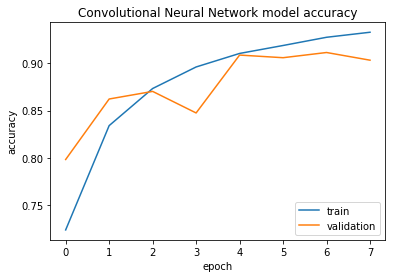

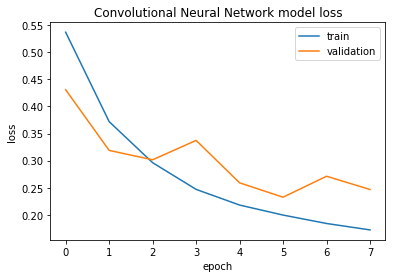

In [131]:
plot_history(history_model)

#### The process of fine-tuneing the model 

Underneath is a screenshot of a spreadsheet I've used while attempting to increase the performance of my model. 
Without prior experience, doing this was challenging but also forced me to look into the meaning of the different parameters used when creating and training the model. I also for the first time felt limited by computing resources.

![title](assets\fine-tuneing.png)

### Validation / performance measuring 

#### Remarks
The result of the model looks good, even though I would like to work with the whole dataset and with some other parameters to increase the accuracy and decrease the loss. There is also a gap between the validation and training loss, which might indicate slight overfitting. Looking at the history over epochs it might have been the best to stop the training at the 5'th epoch, before the gap started increasing.

#### Testing the model out on some of the test data

If I had the time and resources I would probably be doing some k-fold cross-validation at this point, to be more certain of my models performance. Instead I will be plotting some random predictions to check if the model is doing somewhat of a good job. It's also abit more fun to look at cats and dogs rather than lots of numbers! I will ofcourse be looking at images from the test data, which is unseen for the model until this point. 

In [182]:
def predict_image_class(img):
    image_list = np.array([img])
    predictions = model.predict(image_list)
    pred = ""
    if predictions[0, 0] >= 0.5: 
        pred = "cat"
    else: 
        pred = "dog"
        
    return pred

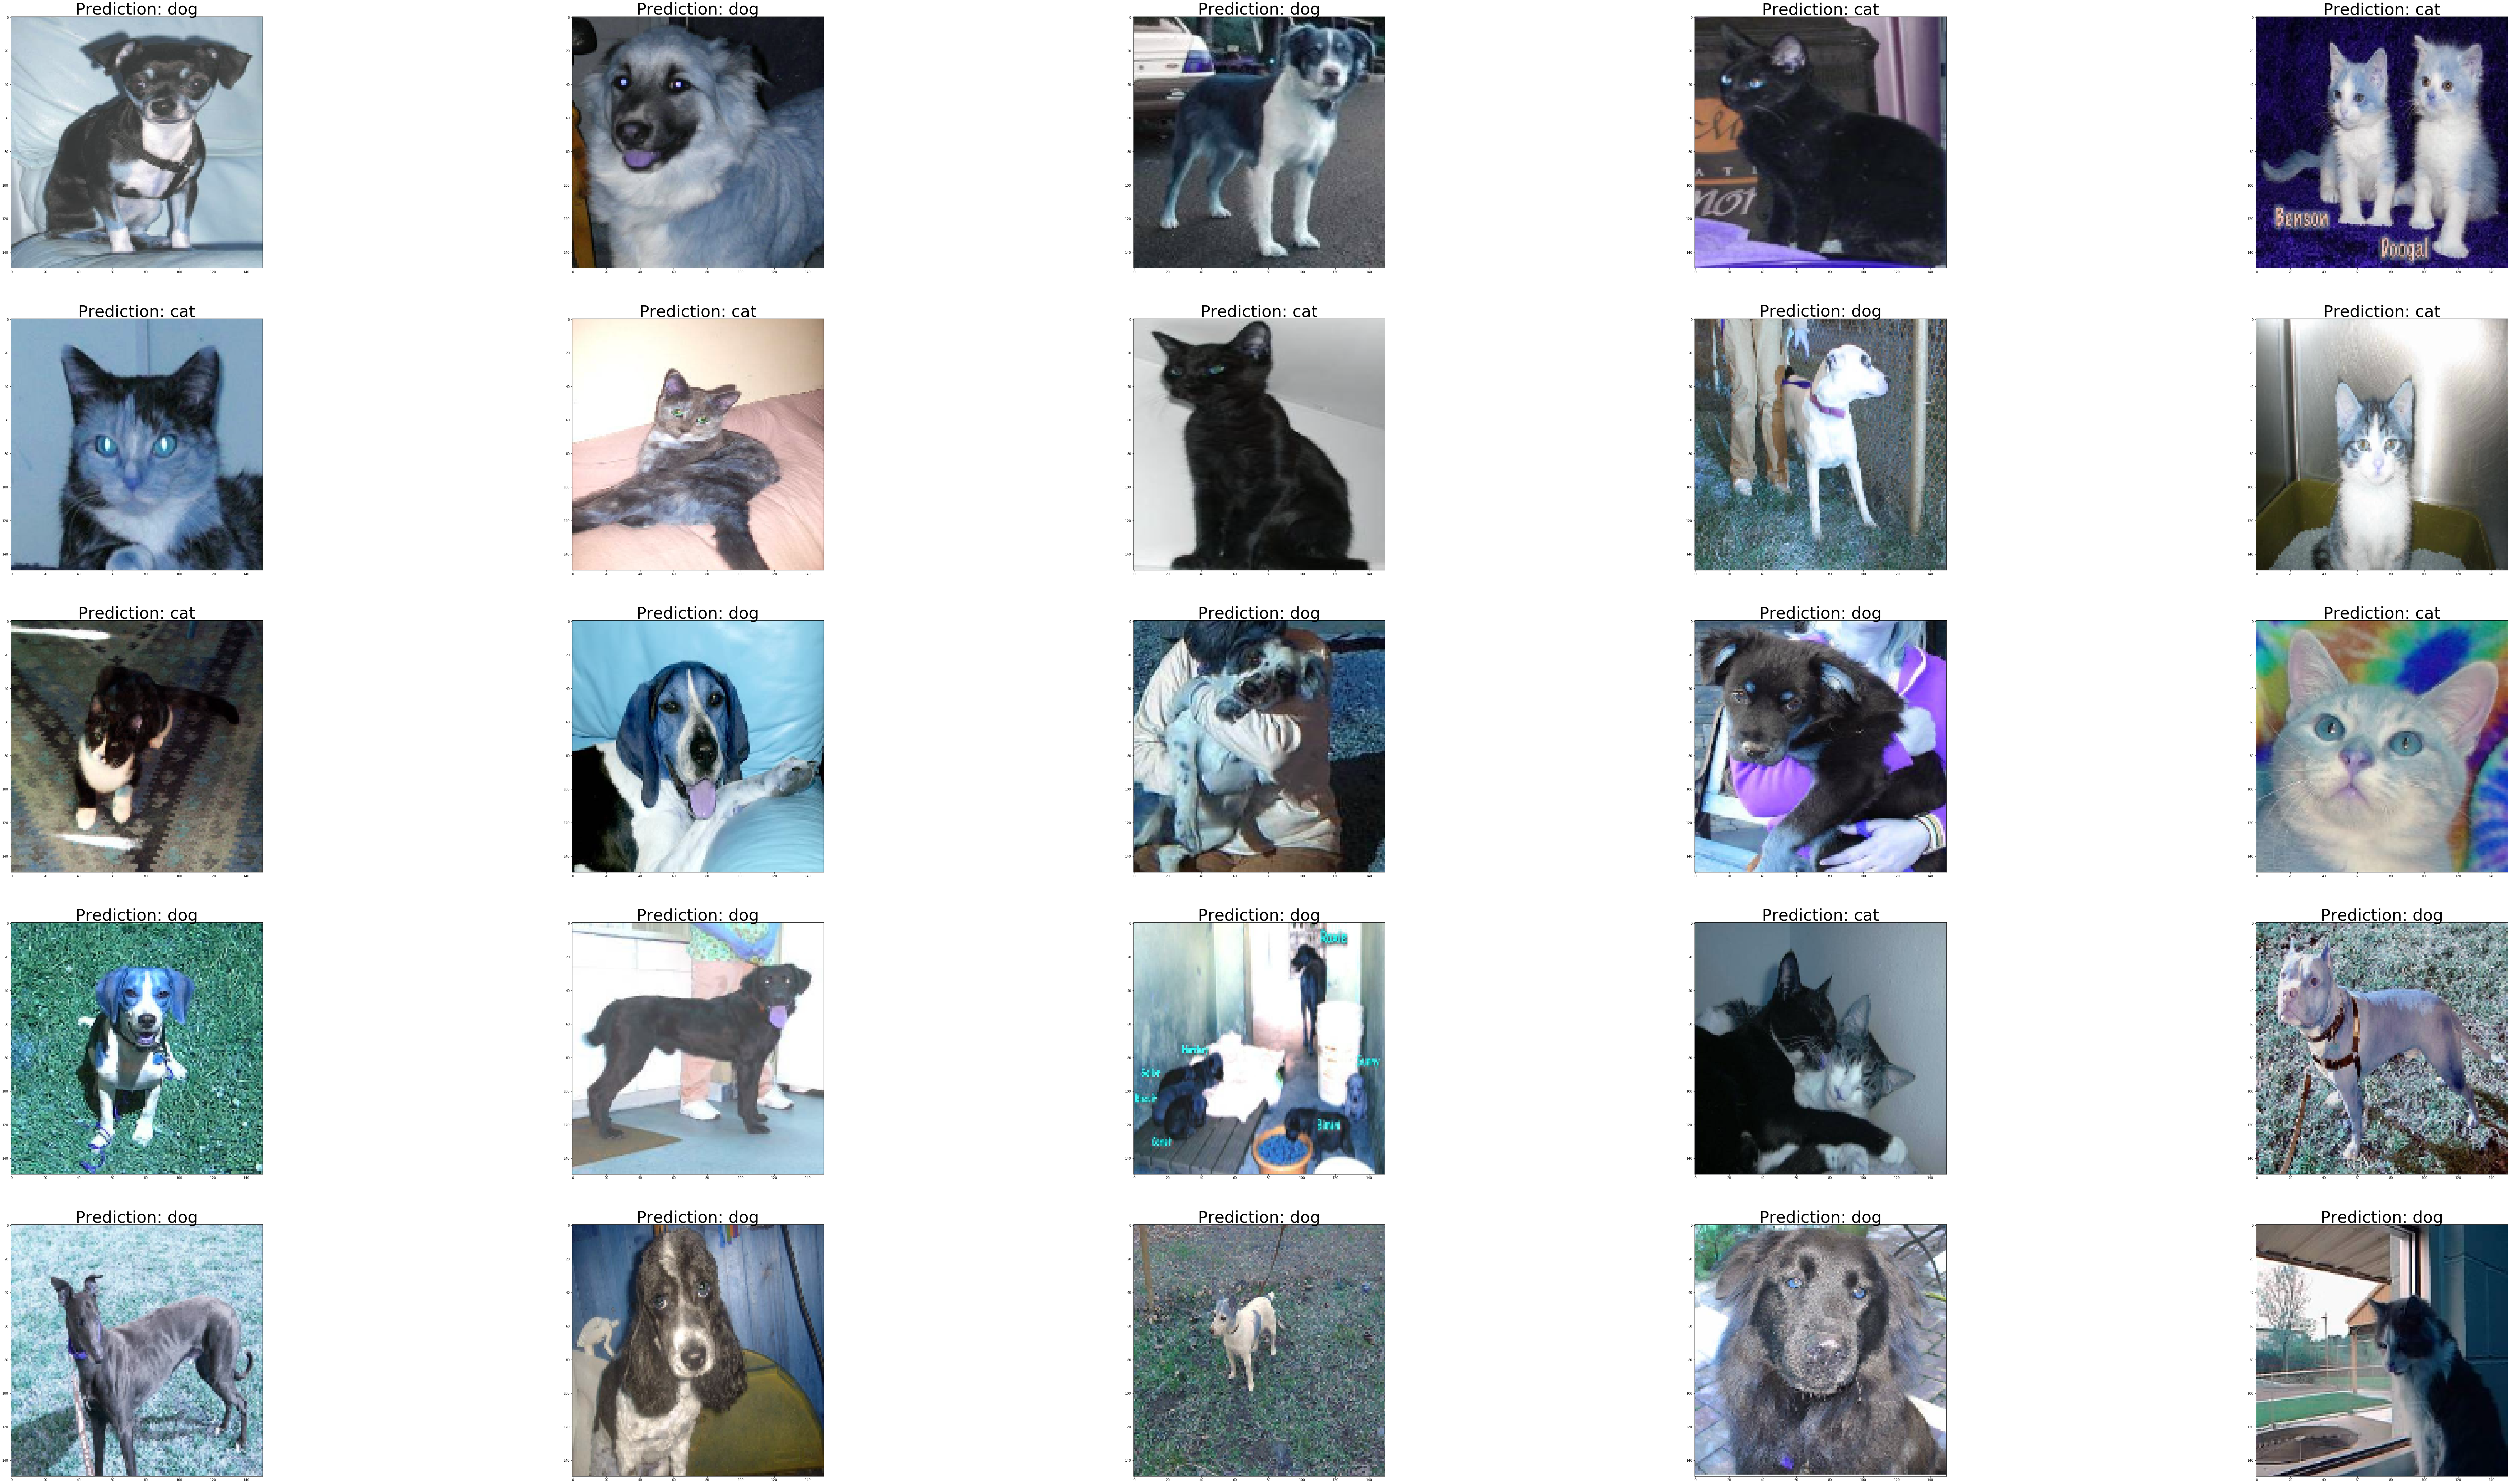

In [183]:
test_sample = test_data[0:25]
test_sample_predictions = []

for img in test_sample: 
    test_sample_predictions.append("Prediction: " + predict_image_class(img))

show_images(test_sample,6, test_sample_predictions)

Looking at the result below, even though It's not a big sample size It indicates that the model is somewhat competent of classifying wether or not the picture is of a dog or a cat! 

![celebration](assets/celebration.gif)

## Step 7: Presenting the solution

#### What I've done

I have used Keras together with Tensorflow and multiple other frameworks in order to create a fully functional image classifier. The key to this project is ofcourse the Convolutional neural network, which I have learned alot about during this process. Working my way through all the previous steps in the "Machine learning project Checklist" I've learned alot about little details which makes a solution works, as well as that machine learning and neural networks is not just pure magic and sorcery! 

#### The result 

The result is not perfect. There is plenty of room for improvement, im sure. But given the fact that I knew little to non about the process of creating an image classifier, I'm happy with my result! The model is able to classify the images with pretty high accuracy, which was the goal of the notebook (besides learning ofcourse). 

In [206]:
print ("Model accuracy: " + str(scores[1]))
print ("Model loss: " + str(scores[0]))

Model accuracy: 0.9171666665077209
Model loss: 0.22824253592888513


## Learning sources 

https://www.youtube.com/watch?v=YRhxdVk_sIs -- CNN's explained by deeplizard

https://www.youtube.com/playlist?list=PLZbbT5o_s2xrwRnXk_yCPtnqqo4_u2YGL - Keras by deeplizard

https://medium.com/@parthvadhadiya424/hello-world-program-in-keras-with-cnn-dog-vs-cat-classification-efc6f0da3cc5 - Blogpost about using keras for image classification by parthvadhadiya424

https://www.kaggle.com/jeffd23/catdognet-keras-convnet-starter - Kaggle kernel for the dog-vs-cat competition by jeffd23

https://www.youtube.com/playlist?list=PLQVvvaa0QuDfhTox0AjmQ6tvTgMBZBEXN - Deep Learning basics with Python, TensorFlow and Keras by sentdex

https://www.pugetsystems.com/labs/hpc/The-Best-Way-to-Install-TensorFlow-with-GPU-Support-on-Windows-10-Without-Installing-CUDA-1187/#vscode - Setup for environment 

https://www.kaggle.com/sentdex/full-classification-example-with-convnet - example notebook by sentdex

https://keras.io/getting-started/sequential-model-guide/ - The sequential model in Keras 

https://www.youtube.com/watch?v=VGCHcgmZu24 - The sequential model by Data Talks 

https://cran.rstudio.com/web/packages/keras/vignettes/about_keras_models.html - Keras models by The Comprehensive R Archive Network

https://www.youtube.com/watch?v=LhEMXbjGV_4 - Image preparation for CNN Image Classifier with Keras by deeplizard


https://stanford.edu/~shervine/teaching/cs-229/cheatsheet-deep-learning - Deep learning cheatsheet by Stanford CS229 

https://developers.google.com/machine-learning/practica/image-classification/convolutional-neural-networks - ML Practicum: CNN by Google 

https://machinelearningmastery.com/improve-deep-learning-performance/ - How to improve deep learning performance by Jason Browniee

https://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/ - Evaluate the performance of deep learning models in Keras by Jason Browniee 

https://www.jeremyjordan.me/convnet-architectures/#lenet5 - Convnet architectures by Jeremy Jordan

https://elitedatascience.com/overfitting-in-machine-learning#examples - Overfitting by EliteDataScience 

https://towardsdatascience.com/image-augmentation-for-deep-learning-histogram-equalization-a71387f609b2 - Image Augmentation for Deep Learning by Suki Lau 






## TODO

- Get the data using kaggle API and subroutine
- Combine CNN and XGBoost? 
- Cross validation 
- Confusion matrix 
- Plot picture with label function
- Check out data augmentation ( If your data are images, create randomly modified versions of existing images.) 
- Check out balance of data set 